In [ ]:
import os
import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
RAW_URL = "https://raw.githubusercontent.com/WinNatch/Dissertation/main/combined_sentiment_data.csv"
df = pd.read_csv(RAW_URL, low_memory=False)

assert "clean_text" in df.columns, "Expected 'clean_text' in the CSV."
df["source"] = df["source"].replace({"Twitter": "X (Twitter)"})

def light_normalize(s: str) -> str:
    s = re.sub(r"http\S+|www\.\S+", " ", str(s))
    s = re.sub(r"&amp;|&lt;|&gt;", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["clean_text"] = df["clean_text"].astype(str).map(light_normalize)
df["token_count"] = df["clean_text"].str.split().str.len()
df = df[df["token_count"] >= 3].copy()

dedupe_keys = ["id"] if "id" in df.columns else ["clean_text","date","source"]
df = df.drop_duplicates(subset=dedupe_keys).reset_index(drop=True)

print("Rows after light cleanup:", len(df))
df.tail()

Rows after light cleanup: 59539


date                                               text  \
59534  2024-06-19  Terrible support for hosts I'm an Airbnb owner...   
59535  2024-06-19  BEWARE BEWARE - Airbnb has created a platform ...   
59536  2024-06-18  We need to talk about AirBNB. You can not trus...   
59537  2024-06-18  Air BNB does not do any verification on… Air B...   
59538  2024-06-18  I had a very bad experience with Airbnb… I had...   

           source                                         clean_text  \
59534  Trustpilot  terrible pro bring con big cut greedy terrible...   
59535  Trustpilot  beware beware create charge ill health comply ...   
59536  Trustpilot  talk trust pay fortune talk awful notice rip a...   
59537  Trustpilot  air bnb verification air bnb verification veri...   
59538  Trustpilot  recently visit london item complain pay damage...   

      sentiment_label  sentiment_score  token_count  
59534         label_0         0.816478           24  
59535         label_0         0.686380           30  
59536         label_0         0.612329           51  
59537         label_1         0.513420           29  
59538         label_0         0.515081           27

In [ ]:
ARTIFACTS = Path("artifacts/event_only/spillovers")
ARTIFACTS.mkdir(parents=True, exist_ok=True)

In [ ]:
START_DATE = "2024-07-01"
END_DATE   = "2025-06-30"

assert {"date","source"}.issubset(df.columns), "Need 'date' and 'source' columns."

# Work on a clean string version
src = df["source"].astype(str).str.strip()
tp_mask = src.str.lower().eq("trustpilot")
date_str = df["date"].astype(str).str.strip()

# Add " 00:00" if no explicit time on Trustpilot rows
has_time = date_str.str.contains(r":")
date_str.loc[tp_mask & ~has_time] = date_str.loc[tp_mask & ~has_time] + " 00:00"

# Pass 1: parse everything month-first (handles '1/18/2025 00:00' and ISO)
d_all = pd.to_datetime(date_str, errors="coerce", dayfirst=False)

# Pass 2: for Trustpilot rows that are still NaT, try day-first (handles '17/01/2025 00:00')
need_df = tp_mask & d_all.isna()
if need_df.any():
    d_fix = pd.to_datetime(date_str[need_df], errors="coerce", dayfirst=True)
    d_all.loc[need_df] = d_fix

# Optional fallback for any leftovers (very few)
still = d_all.isna()
if still.any():
    d_fallback = pd.to_datetime(date_str[still], errors="coerce")
    d_all.loc[still] = d_fallback

# Strip tz if any and assign back
try:
    d_all = d_all.dt.tz_localize(None)
except Exception:
    pass
df["date"] = d_all

# Drop any rows that remain unparsed
bad = int(df["date"].isna().sum())
if bad:
    print(f"Warning: dropping {bad} rows with unparseable dates.")
df = df.dropna(subset=["date"]).copy()

# Quick coverage check (Monday-anchored, normalized at midnight)
wk = (
    df.assign(week_start=(df["date"] - pd.to_timedelta(df["date"].dt.weekday, unit="D")).dt.normalize())
      .drop_duplicates(["source","week_start"])
)
print("Trustpilot week coverage (min, max, count):")
print(wk[wk["source"]=="Trustpilot"]["week_start"].agg(["min","max","nunique"]))

Trustpilot week coverage (min, max, count):
min        2024-06-17 00:00:00
max        2025-07-07 00:00:00
nunique                     56
Name: week_start, dtype: object


/tmp/ipython-input-59319817.py:21: UserWarning: Parsing dates in %Y-%m-%d %H:%M format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  d_fix = pd.to_datetime(date_str[need_df], errors="coerce", dayfirst=True)


In [ ]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
try:
    df["date"] = df["date"].dt.tz_localize(None)
except Exception:
    pass

df = df.dropna(subset=["date", "source", "sentiment_label"]).copy()

sign_map = {"label_0": -1, "Negative": -1,
            "label_1": 0,  "Neutral": 0,
            "label_2": 1,  "Positive": 1}
df["sign"] = df["sentiment_label"].map(sign_map).astype(float)

conf_col = "confidence" if "confidence" in df.columns else "sentiment_score"
if conf_col not in df.columns:
    raise KeyError("Need a confidence column: add 'confidence' or reuse 'sentiment_score'.")

df[conf_col] = pd.to_numeric(df[conf_col], errors="coerce")
df = df.dropna(subset=[conf_col]).copy()

df["metric_soft"] = df["sign"] * df[conf_col]   # weighted (soft)
df["metric_hard"] = df["sign"]                  # unweighted (hard)

df_ready_soft = df[["date", "source", "metric_soft"]].rename(columns={"metric_soft": "metric"}).copy()
df_ready_hard = df[["date", "source", "metric_hard"]].rename(columns={"metric_hard": "metric"}).copy()

print("SOFT metric summary by source")
print(df_ready_soft.groupby("source")["metric"].agg(["size","mean","std"]).round(3))
print("\nHARD metric summary by source")
print(df_ready_hard.groupby("source")["metric"].agg(["size","mean","std"]).round(3))

SOFT metric summary by source
              size   mean    std
source                          
Reddit       10465 -0.205  0.394
Trustpilot    1638 -0.518  0.465
X (Twitter)  47436 -0.196  0.484

HARD metric summary by source
              size   mean    std
source                          
Reddit       10465 -0.290  0.547
Trustpilot    1638 -0.665  0.572
X (Twitter)  47436 -0.257  0.616


In [ ]:
def build_daily(df_ready, label):
    if "START_DATE" in globals() and "END_DATE" in globals():
        start, end = pd.to_datetime(START_DATE), pd.to_datetime(END_DATE)
        df_win = df_ready[(df_ready["date"] >= start) & (df_ready["date"] <= end)].copy()
    else:
        df_win = df_ready.copy()

    # aggregate to daily
    daily_raw = (
        df_win.assign(day=df_win["date"].dt.date)
              .groupby(["day","source"], as_index=False)
              .agg(mean=("metric","mean"),
                   n_posts=("metric","size"))
              .rename(columns={"day":"date"})
              .sort_values(["source","date"])
    )

    # z-score across days within each platform
    def z_by_group(s):
        mu, sd = s.mean(), s.std(ddof=0)
        if pd.isna(sd) or sd == 0:
            return pd.Series(np.zeros(len(s)), index=s.index)
        return (s - mu) / sd

    daily = daily_raw.copy()
    daily[f"sent_z_{label}"] = daily.groupby("source", group_keys=False)["mean"].apply(z_by_group)
    daily[f"sent_z_ra7_{label}"] = (
        daily.sort_values(["source","date"])
             .groupby("source", group_keys=False)[f"sent_z_{label}"]
             .apply(lambda s: s.rolling(7, min_periods=1).mean())
    )
    return daily

daily_soft = build_daily(df_ready_soft, "soft")
daily_hard = build_daily(df_ready_hard, "hard")

out_soft = ARTIFACTS / "sentiment_daily.csv"
out_hard = ARTIFACTS / "sentiment_daily_hard.csv"
out_both = ARTIFACTS / "sentiment_daily_both.csv"

daily_soft[["date","source","sent_z_soft","sent_z_ra7_soft","n_posts"]].to_csv(out_soft, index=False)
daily_hard[["date","source","sent_z_hard","sent_z_ra7_hard","n_posts"]].to_csv(out_hard, index=False)

daily_both = (daily_soft.merge(daily_hard, on=["date","source","n_posts"], how="outer")
                        .sort_values(["source","date"]))
daily_both.to_csv(out_both, index=False)

print(f"✅ Saved DAILY SOFT → {out_soft}   rows={len(daily_soft)}")
print(f"✅ Saved DAILY HARD → {out_hard}   rows={len(daily_hard)}")
print(f"✅ Saved DAILY BOTH → {out_both}   rows={len(daily_both)}")
display(daily_both.head())

✅ Saved DAILY SOFT → artifacts/event_only/spillovers/sentiment_daily.csv   rows=1033
✅ Saved DAILY HARD → artifacts/event_only/spillovers/sentiment_daily_hard.csv   rows=1033
✅ Saved DAILY BOTH → artifacts/event_only/spillovers/sentiment_daily_both.csv   rows=1033


date  source    mean_x  n_posts  sent_z_soft  sent_z_ra7_soft  \
0   2024-07-01  Reddit -0.206510        4     0.152983         0.152983   
3   2024-07-02  Reddit -0.186595       30     0.229082         0.191033   
6   2024-07-03  Reddit -0.173002       28     0.281023         0.221029   
9   2024-07-04  Reddit -0.048175        9     0.758015         0.355276   
12  2024-07-05  Reddit -0.187837       38     0.224336         0.329088   

      mean_y  sent_z_hard  sent_z_ra7_hard  
0  -0.250000     0.261009         0.261009  
3  -0.266667     0.212454         0.236732  
6  -0.250000     0.261009         0.244824  
9   0.000000     0.989325         0.430949  
12 -0.263158     0.222676         0.389295

In [ ]:
ROLL_DAYS   = 21
ROLL_WEEKS  = 4

roll_w = ROLL_WEEKS if "ROLL_WEEKS" in globals() else 3

def next_monday(d: pd.Timestamp) -> pd.Timestamp:
    d = pd.to_datetime(d)
    return d + pd.to_timedelta(7 - d.weekday(), unit="D")

def pad_weeks_per_source(wdf: pd.DataFrame) -> pd.DataFrame:
    if wdf.empty:
        return wdf
    min_m = wdf["week_start"].min()
    max_m = wdf["week_start"].max()
    all_mondays = pd.date_range(min_m, max_m, freq="W-MON")
    sources = wdf["source"].unique()
    full_ix = pd.MultiIndex.from_product([sources, all_mondays], names=["source","week_start"])
    out = wdf.set_index(["source","week_start"]).reindex(full_ix).reset_index()
    if "n_posts" in out.columns:
        out["n_posts"] = out["n_posts"].fillna(0)
    return out

def z_by_group(s: pd.Series) -> pd.Series:
    mu, sd = s.mean(), s.std(ddof=0)
    if pd.isna(sd) or sd == 0:
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - mu) / sd

def build_weekly(df_ready, label):
    if "START_DATE" in globals() and "END_DATE" in globals():
        start = pd.to_datetime(START_DATE)
        end = next_monday(pd.to_datetime(END_DATE))
        df_win = df_ready[(df_ready["date"] >= start) & (df_ready["date"] < end)].copy()
    else:
        df_win = df_ready.copy()

    weekly_raw = (
        df_win.set_index("date").groupby("source")
              .resample("W-MON", label="left", closed="left")
              .agg(mean=("metric","mean"),
                   n_posts=("metric","size"))
              .reset_index()
              .rename(columns={"date":"week_start"})
              .sort_values(["source","week_start"])
    )

    # pad missing Mondays per source
    weekly_pad = pad_weeks_per_source(weekly_raw)

    # z-score across weeks within each platform
    weekly_pad[f"sent_z_{label}"] = (
        weekly_pad.groupby("source", group_keys=False)["mean"].apply(z_by_group)
    )

    # rolling for plots
    weekly_pad[f"sent_z_ra{roll_w}_{label}"] = (
        weekly_pad.sort_values(["source","week_start"])
                  .groupby("source", group_keys=False)[f"sent_z_{label}"]
                  .apply(lambda s: s.rolling(roll_w, min_periods=1).mean())
    )
    return weekly_pad

weekly_soft = build_weekly(df_ready_soft, "soft")
weekly_hard = build_weekly(df_ready_hard, "hard")

out_soft = ARTIFACTS / "sentiment_weekly.csv"
out_hard = ARTIFACTS / "sentiment_weekly_hard.csv"
out_both = ARTIFACTS / "sentiment_weekly_both.csv"

weekly_soft[["week_start","source","sent_z_soft",f"sent_z_ra{roll_w}_soft","n_posts"]].to_csv(out_soft, index=False)
weekly_hard[["week_start","source","sent_z_hard",f"sent_z_ra{roll_w}_hard","n_posts"]].to_csv(out_hard, index=False)

weekly_both = (weekly_soft.merge(weekly_hard, on=["week_start","source","n_posts"], how="outer")
                          .sort_values(["source","week_start"]))
weekly_both.to_csv(out_both, index=False)

print(f"✅ Saved WEEKLY SOFT → {out_soft}   rows={len(weekly_soft)}")
print(f"✅ Saved WEEKLY HARD → {out_hard}   rows={len(weekly_hard)}")
print(f"✅ Saved WEEKLY BOTH → {out_both}   rows={len(weekly_both)}")
display(weekly_both.head())
display(weekly_both.tail())

✅ Saved WEEKLY SOFT → artifacts/event_only/spillovers/sentiment_weekly.csv   rows=159
✅ Saved WEEKLY HARD → artifacts/event_only/spillovers/sentiment_weekly_hard.csv   rows=159
✅ Saved WEEKLY BOTH → artifacts/event_only/spillovers/sentiment_weekly_both.csv   rows=159


source week_start    mean_x  n_posts  sent_z_soft  sent_z_ra4_soft  \
0   Reddit 2024-07-01 -0.183719    213.0     0.493963         0.493963   
3   Reddit 2024-07-08 -0.332633    156.0    -0.465527         0.014218   
6   Reddit 2024-07-15 -0.317691     45.0    -0.369247        -0.113603   
9   Reddit 2024-07-22 -0.432790    146.0    -1.110858        -0.362917   
12  Reddit 2024-07-29 -0.308537    124.0    -0.310265        -0.563974   

      mean_y  sent_z_hard  sent_z_ra4_hard  
0  -0.267606     0.478892         0.478892  
3  -0.429487    -0.373966         0.052463  
6  -0.355556     0.015536         0.040154  
9  -0.595890    -1.250647        -0.282546  
12 -0.443548    -0.448047        -0.514281

source week_start    mean_x  n_posts  sent_z_soft  sent_z_ra4_soft  \
146  X (Twitter) 2025-06-02 -0.291463     13.0    -2.000517        -0.111945   
149  X (Twitter) 2025-06-09 -0.192109    225.0    -0.546040        -0.635909   
152  X (Twitter) 2025-06-16 -0.217892    785.0    -0.923490        -0.869532   
155  X (Twitter) 2025-06-23 -0.071493    854.0     1.219691        -0.562589   
158  X (Twitter) 2025-06-30 -0.190255     50.0    -0.518900        -0.192185   

       mean_y  sent_z_hard  sent_z_ra4_hard  
146 -0.307692    -1.253019         0.108073  
149 -0.253333    -0.577313        -0.474528  
152 -0.286624    -0.991133        -0.709104  
155 -0.112412     1.174400        -0.411766  
158 -0.260000    -0.660182        -0.263557

In [ ]:
from statsmodels.tsa.stattools import adfuller

daily_both_path  = ARTIFACTS / "sentiment_daily_both.csv"
weekly_both_path = ARTIFACTS / "sentiment_weekly_both.csv"

daily_both  = (globals().get("daily_both")  if "daily_both"  in globals()
               else pd.read_csv(daily_both_path, parse_dates=["date"]))
weekly_both = (globals().get("weekly_both") if "weekly_both" in globals()
               else pd.read_csv(weekly_both_path, parse_dates=["week_start"]))

def _safe_adf(x, maxlag=8, regression="c"):
    """ADF with autolag=AIC; if maxlag too large, back off until it works."""
    x = pd.Series(x).dropna().astype(float)
    used_max = maxlag
    while used_max >= 0:
        try:
            res = adfuller(x, maxlag=used_max, regression=regression, autolag="AIC")
            stat, pval, usedlag, nobs, crit, icbest = res
            return {
                "adf_stat": stat,
                "pvalue": pval,
                "usedlag": usedlag,
                "nobs": nobs,
                "crit_1pct": crit.get("1%") if isinstance(crit, dict) else crit[0],
                "crit_5pct": crit.get("5%") if isinstance(crit, dict) else crit[1],
                "crit_10pct": crit.get("10%") if isinstance(crit, dict) else crit[2],
                "icbest": icbest,
                "maxlag_tried": used_max,
            }
        except Exception:
            used_max -= 1
    return {"adf_stat": np.nan, "pvalue": np.nan, "usedlag": np.nan,
            "nobs": len(x), "crit_1pct": np.nan, "crit_5pct": np.nan,
            "crit_10pct": np.nan, "icbest": np.nan, "maxlag_tried": np.nan}

rows = []

# Daily
for metric_col, metric_name in [("sent_z_soft","soft"), ("sent_z_hard","hard")]:
    for src, g in daily_both.groupby("source"):
        g = g.sort_values("date")
        res = _safe_adf(g[metric_col].values, maxlag=8, regression="c")
        rows.append({
            "frequency": "daily",
            "metric": metric_name,
            "source": src,
            "n_obs": int(res["nobs"]),
            "usedlag": res["usedlag"],
            "adf_stat": res["adf_stat"],
            "pvalue": res["pvalue"],
            "crit_1pct": res["crit_1pct"],
            "crit_5pct": res["crit_5pct"],
            "crit_10pct": res["crit_10pct"],
            "AIC_best": res["icbest"],
            "maxlag_tried": res["maxlag_tried"],
            "stationary_at_5pct": (res["pvalue"] < 0.05) if pd.notna(res["pvalue"]) else np.nan,
        })

# Weekly
for metric_col, metric_name in [("sent_z_soft","soft"), ("sent_z_hard","hard")]:
    for src, g in weekly_both.groupby("source"):
        g = g.sort_values("week_start")
        res = _safe_adf(g[metric_col].values, maxlag=8, regression="c")
        rows.append({
            "frequency": "weekly",
            "metric": metric_name,
            "source": src,
            "n_obs": int(res["nobs"]),
            "usedlag": res["usedlag"],
            "adf_stat": res["adf_stat"],
            "pvalue": res["pvalue"],
            "crit_1pct": res["crit_1pct"],
            "crit_5pct": res["crit_5pct"],
            "crit_10pct": res["crit_10pct"],
            "AIC_best": res["icbest"],
            "maxlag_tried": res["maxlag_tried"],
            "stationary_at_5pct": (res["pvalue"] < 0.05) if pd.notna(res["pvalue"]) else np.nan,
        })

adf_table = pd.DataFrame(rows).sort_values(["frequency","metric","source"]).reset_index(drop=True)
adf_out = ARTIFACTS / "adf_table.csv"
adf_table.to_csv(adf_out, index=False)

print(f"✅ Saved ADF table to {adf_out}")
display(adf_table.style.format({
    "adf_stat": "{:.3f}", "pvalue": "{:.3f}", "crit_1pct": "{:.3f}",
    "crit_5pct": "{:.3f}", "crit_10pct": "{:.3f}", "AIC_best": "{:.3f}"
}).hide(axis='index'))

✅ Saved ADF table to artifacts/event_only/spillovers/adf_table.csv


In [ ]:
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera

weekly_soft_path = ARTIFACTS / "sentiment_weekly.csv"
VAR_SUMMARY_PATH = ARTIFACTS / "var_summary.txt"

w = pd.read_csv(weekly_soft_path, parse_dates=["week_start"])
w_wide = (w.pivot(index="week_start", columns="source", values="sent_z_soft")
            .sort_index())

order = ["Reddit", "Trustpilot", "X (Twitter)"]
cols = [c for c in order if c in w_wide.columns]
Y = w_wide[cols].dropna().copy()

if Y.shape[1] < 2:
    raise ValueError(
        f"Need at least 2 platforms for VAR; got {Y.shape[1]} after dropping NaNs. "
        "Check weekly data alignment or missing platforms."
    )

Y.columns = ["zR", "zTP", "zX"][:Y.shape[1]]
print("Weekly–soft VAR matrix:", Y.shape)
display(Y.tail())

def select_lag(Y_df, cap=8):
    nobs = len(Y_df)
    maxlags = min(cap, max(1, nobs // 6))
    while maxlags >= 1:
        try:
            sel = VAR(Y_df).select_order(maxlags=maxlags)
            p = int(sel.aic) if sel.aic is not None else 1
            return max(1, min(p, maxlags)), sel
        except Exception:
            maxlags -= 1
    return 1, None

p_sel, sel_obj = select_lag(Y, cap=8)
print(f"Selected p by AIC: {p_sel}")

model = VAR(Y)
var_weekly_soft_res = model.fit(p_sel)
print(var_weekly_soft_res.summary())

aic_val = var_weekly_soft_res.aic
roots = var_weekly_soft_res.roots
max_root_mod = np.max(np.abs(roots)) if len(roots) else np.nan
is_stable = bool(var_weekly_soft_res.is_stable(verbose=False))

resid_df = pd.DataFrame(
    np.asarray(var_weekly_soft_res.resid),
    index=Y.index[var_weekly_soft_res.k_ar:],
    columns=var_weekly_soft_res.names
)

nlags = int(min(8, max(1, len(resid_df) - 2)))
lb_pvals, jb_pvals = {}, {}

for name in resid_df.columns:
    series = resid_df[name].astype(float).values

    lb = acorr_ljungbox(series, lags=[nlags], return_df=True)
    lb_pvals[name] = float(lb["lb_pvalue"].iloc[-1])

    jb_res = jarque_bera(series)
    try:
        jb_stat, jb_p = float(jb_res.statistic), float(jb_res.pvalue)
    except AttributeError:
        jb_stat, jb_p = map(float, jb_res)
    jb_pvals[name] = jb_p

lines = []
lines.append("=== VAR baseline: WEEKLY (soft) ===")
lines.append(f"Sample: {Y.index.min().date()} … {Y.index.max().date()}  (n={len(Y)})")
lines.append(f"Variables: {', '.join(var_weekly_soft_res.names)}  |  selected p (AIC) = {p_sel}")
lines.append(f"Model AIC: {aic_val:.3f}")
lines.append(f"Stability (all AR roots < 1): {is_stable}  |  max |root| = {max_root_mod:.3f}")
lines.append(f"Ljung–Box p-values @ lag {nlags}: " +
             ", ".join([f"{k}={v:.3f}" for k,v in lb_pvals.items()]))
lines.append("Jarque–Bera p-values (normality of residuals): " +
             ", ".join([f"{k}={v:.3f}" for k,v in jb_pvals.items()]))
lines.append("")

with open(VAR_SUMMARY_PATH, "a", encoding="utf-8") as f:
    f.write("\n".join(lines))

print(f"✅ Appended weekly–soft summary to {VAR_SUMMARY_PATH}")

Weekly–soft VAR matrix: (52, 3)


zR       zTP        zX
week_start                              
2025-05-26 -0.303582  0.256658 -0.008081
2025-06-02  0.891857  0.975910 -2.000517
2025-06-09  0.622156 -1.024083 -0.546040
2025-06-16  0.748596  1.041081 -0.923490
2025-06-23  0.782125  0.092230  1.219691

Selected p by AIC: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Aug, 2025
Time:                     14:29:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.573316
Nobs:                     51.0000    HQIC:                  0.292465
Log likelihood:          -208.126    FPE:                    1.12720
AIC:                     0.118769    Det(Omega_mle):        0.898718
--------------------------------------------------------------------
Results for equation zR
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.006712         0.143994           -0.047           0.963
L1.zR          0.199440         0.145120            1.374           0.169
L1.zTP        -0.005231         0.155858           -0.034           0.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [ ]:
def select_lag(Y, cap=8):
    maxlags = min(cap, max(1, len(Y)//6))
    while maxlags >= 1:
        try:
            sel = VAR(Y).select_order(maxlags=maxlags)
            p = int(sel.aic) if sel.aic is not None else 1
            return max(1, min(p, maxlags))
        except Exception:
            maxlags -= 1
    return 1

def run_var_from_csv(csv_path, date_col, value_col, tag):
    df = pd.read_csv(csv_path, parse_dates=[date_col])
    wide = df.pivot(index=date_col, columns="source", values=value_col).sort_index()
    order = ["Reddit","Trustpilot","X (Twitter)"]
    cols  = [c for c in order if c in wide.columns]
    Y = wide[cols].dropna().copy()
    if Y.shape[1] < 2:
        raise ValueError(f"{tag}: need ≥2 platforms, got {Y.shape[1]}.")
    Y.columns = ["zR","zTP","zX"][:Y.shape[1]]
    print(f"{tag} VAR matrix:", Y.shape)

    p = select_lag(Y, cap=8)
    print(f"Selected p by AIC: {p}")
    res = VAR(Y).fit(p)
    print(res.summary())

    resid_df = pd.DataFrame(np.asarray(res.resid),
                            index=Y.index[res.k_ar:], columns=res.names)
    nlags = int(min(8, max(1, len(resid_df)-2)))
    lb_p = {}; jb_p = {}
    for name in resid_df.columns:
        s = resid_df[name].astype(float).values
        lb_p[name] = float(acorr_ljungbox(s, lags=[nlags], return_df=True)["lb_pvalue"].iloc[-1])
        jb = jarque_bera(s)
        try: jb_p[name] = float(jb.pvalue)
        except AttributeError: jb_p[name] = float(jb[1])

    lines = [
        f"=== VAR baseline: {tag} ===",
        f"Sample: {Y.index.min().date()} … {Y.index.max().date()}  (n={len(Y)})",
        f"Variables: {', '.join(res.names)}  |  selected p (AIC) = {p}",
        f"Model AIC: {res.aic:.3f}",
        f"Stability (all AR roots < 1): {bool(res.is_stable())}  |  max |root| = {np.abs(res.roots).max():.3f}",
        "Ljung–Box p-values @ lag {}: {}".format(nlags, ", ".join(f"{k}={v:.3f}" for k,v in lb_p.items())),
        "Jarque–Bera p-values: " + ", ".join(f"{k}={v:.3f}" for k,v in jb_p.items()),
        ""
    ]
    with open(VAR_SUMMARY_PATH, "a", encoding="utf-8") as f:
        f.write("\n".join(lines))
    print(f"✅ Appended {tag} summary to {VAR_SUMMARY_PATH}")
    return res

In [ ]:
# WEEKLY – HARD
run_var_from_csv(
    csv_path=ARTIFACTS / "sentiment_weekly_hard.csv",
    date_col="week_start",
    value_col="sent_z_hard",
    tag="WEEKLY (hard)"
)

# DAILY – SOFT
daily_soft_path = ARTIFACTS / "sentiment_daily_both.csv"
if not daily_soft_path.exists():
    daily_soft_path = ARTIFACTS / "sentiment_daily.csv"
run_var_from_csv(
    csv_path=daily_soft_path,
    date_col="date",
    value_col="sent_z_soft" if daily_soft_path.name.endswith("_both.csv") else "sent_z",
    tag="DAILY (soft)"
)

# DAILY – HARD
daily_hard_path = ARTIFACTS / "sentiment_daily_both.csv"
value_col = "sent_z_hard"
if not daily_hard_path.exists():
    daily_hard_path = ARTIFACTS / "sentiment_daily_hard.csv"  # fallback if you saved separately
    value_col = "sent_z_hard"
run_var_from_csv(
    csv_path=daily_hard_path,
    date_col="date",
    value_col=value_col,
    tag="DAILY (hard)"
)

WEEKLY (hard) VAR matrix: (52, 3)
Selected p by AIC: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Aug, 2025
Time:                     14:29:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.647013
Nobs:                     51.0000    HQIC:                  0.366162
Log likelihood:          -210.005    FPE:                    1.21341
AIC:                     0.192466    Det(Omega_mle):        0.967454
--------------------------------------------------------------------
Results for equation zR
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.006888         0.145151           -0.047           0.962
L1.zR          0.157693         0.145479            1.084           0.278
L1.zTP        -0.007809         0.15

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarn

In [ ]:
def _select_lag(Y, cap=8):
    maxlags = min(cap, max(1, len(Y)//6))
    while maxlags >= 1:
        try:
            p = int(VAR(Y).select_order(maxlags=maxlags).aic)
            return max(1, min(p, maxlags))
        except Exception:
            maxlags -= 1
    return 1

def run_var(csv_path, date_col, value_col, tag, start=None, end=None):
    df = pd.read_csv(csv_path, parse_dates=[date_col])
    if start is not None: df = df[df[date_col] >= pd.to_datetime(start)]
    if end   is not None: df = df[df[date_col] <= pd.to_datetime(end)]
    wide = df.pivot(index=date_col, columns="source", values=value_col).sort_index()
    order = ["Reddit","Trustpilot","X (Twitter)"]
    cols = [c for c in order if c in wide.columns]
    Y = wide[cols].dropna().copy()
    if Y.shape[1] < 2: raise ValueError(f"{tag}: need ≥2 platforms.")
    Y.columns = ["zR","zTP","zX"][:Y.shape[1]]
    print(f"{tag} VAR matrix:", Y.shape)

    p = _select_lag(Y, cap=8)
    print(f"Selected p by AIC: {p}")
    res = VAR(Y).fit(p)
    print(res.summary())

    resid = pd.DataFrame(np.asarray(res.resid), index=Y.index[res.k_ar:], columns=res.names)
    nl = int(min(8, max(1, len(resid)-2)))
    lb = {n: float(acorr_ljungbox(resid[n].astype(float).values, lags=[nl], return_df=True)["lb_pvalue"].iloc[-1])
          for n in resid.columns}
    jb = {}
    for n in resid.columns:
        r = jarque_bera(resid[n].astype(float).values)
        try: jb[n] = float(r.pvalue)
        except AttributeError: jb[n] = float(r[1])

    lines = [
        f"=== VAR baseline: {tag} ===",
        f"Sample: {Y.index.min().date()} … {Y.index.max().date()}  (n={len(Y)})",
        f"Variables: {', '.join(res.names)}  |  selected p (AIC) = {p}",
        f"Model AIC: {res.aic:.3f}",
        f"Stability (all AR roots < 1): {bool(res.is_stable())}  |  max |root| = {np.abs(res.roots).max():.3f}",
        f"Ljung–Box p@{nl}: " + ", ".join(f"{k}={v:.3f}" for k,v in lb.items()),
        "Jarque–Bera: " + ", ".join(f"{k}={v:.3f}" for k,v in jb.items()),
        ""
    ]
    with open(VAR_SUMMARY_PATH, "a", encoding="utf-8") as f:
        f.write("\n".join(lines))
    print(f"✅ Appended {tag} to {VAR_SUMMARY_PATH}")
    return res

In [ ]:
# WEEKLY — SOFT (split)
weekly_soft = ARTIFACTS / "sentiment_weekly.csv"

run_var(weekly_soft, "week_start", "sent_z_soft",
        tag="WEEKLY soft (2024-H2)", start="2024-07-01", end="2024-12-31")

run_var(weekly_soft, "week_start", "sent_z_soft",
        tag="WEEKLY soft (2025-H1)", start="2025-01-01", end="2025-06-30")

# DAILY — SOFT (split)
daily_path = ARTIFACTS / "sentiment_daily_both.csv"
val_col = "sent_z_soft"
if not daily_path.exists():
    daily_path = ARTIFACTS / "sentiment_daily.csv"
    val_col = "sent_z"

run_var(daily_path, "date", val_col,
        tag="DAILY soft (2024-H2)", start="2024-07-01", end="2024-12-31")

run_var(daily_path, "date", val_col,
        tag="DAILY soft (2025-H1)", start="2025-01-01", end="2025-06-30")

WEEKLY soft (2024-H2) VAR matrix: (27, 3)
Selected p by AIC: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Aug, 2025
Time:                     14:30:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  0.0319974
Nobs:                     26.0000    HQIC:                 -0.381453
Log likelihood:          -91.5446    FPE:                   0.582006
AIC:                    -0.548663    Det(Omega_mle):        0.378864
--------------------------------------------------------------------
Results for equation zR
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.371359         0.274995           -1.350           0.177
L1.zR          0.021061         0.209893            0.100           0.920
L1.zTP        -0.205929     

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and 

In [ ]:
ARTIFACTS = Path("artifacts/event_only/spillovers")
ARTIFACTS.mkdir(parents=True, exist_ok=True)
WEEKLY_SOFT = ARTIFACTS / "sentiment_weekly.csv"
WEEKLY_SOFT_R4 = ARTIFACTS / "sentiment_weekly_soft_r4.csv"
VAR_SUMMARY_PATH = ARTIFACTS / "var_summary.txt"

if not WEEKLY_SOFT_R4.exists():
    w = pd.read_csv(WEEKLY_SOFT, parse_dates=["week_start"])
    def pad_weeks(df):
        mondays = pd.date_range(df["week_start"].min(), df["week_start"].max(), freq="W-MON")
        idx = pd.MultiIndex.from_product([df["source"].unique(), mondays], names=["source","week_start"])
        return df.set_index(["source","week_start"]).reindex(idx).reset_index()
    w2 = pad_weeks(w[["week_start","source","sent_z_soft"]].copy())
    w2["sent_z_soft_r4"] = (w2.sort_values(["source","week_start"])
                              .groupby("source", group_keys=False)["sent_z_soft"]
                              .apply(lambda s: s.rolling(4, min_periods=1).mean()))
    w_out = w2.dropna(subset=["sent_z_soft_r4"])[["week_start","source","sent_z_soft_r4"]]
    w_out.to_csv(WEEKLY_SOFT_R4, index=False)
    print(f"✅ Saved {WEEKLY_SOFT_R4}")

def _select_lag(Y):
    maxlags = min(8, max(1, len(Y)//6))
    while maxlags >= 1:
        try:
            return int(VAR(Y).select_order(maxlags=maxlags).aic)
        except Exception:
            maxlags -= 1
    return 1

def run_var(csv_path, date_col, value_col, tag, start=None, end=None):
    df = pd.read_csv(csv_path, parse_dates=[date_col])
    if start is not None: df = df[df[date_col] >= pd.to_datetime(start)]
    if end   is not None: df = df[df[date_col] <= pd.to_datetime(end)]
    wide = df.pivot(index=date_col, columns="source", values=value_col).sort_index()
    order = ["Reddit","Trustpilot","X (Twitter)"]
    Y = wide[[c for c in order if c in wide.columns]].dropna().copy()
    Y.columns = ["zR","zTP","zX"][:Y.shape[1]]
    print(f"{tag} VAR matrix:", Y.shape)
    p = _select_lag(Y)
    res = VAR(Y).fit(p)
    print(res.summary())

    resid = pd.DataFrame(np.asarray(res.resid), index=Y.index[res.k_ar:], columns=res.names)
    nl = int(min(8, max(1, len(resid)-2)))
    lb = {n: float(acorr_ljungbox(resid[n].values, lags=[nl], return_df=True)["lb_pvalue"].iloc[-1]) for n in resid}
    jb = {}
    for n in resid:
        r = jarque_bera(resid[n].values)
        try: jb[n] = float(r.pvalue)
        except AttributeError: jb[n] = float(r[1])
    lines = [
        f"=== VAR baseline: {tag} ===",
        f"Sample: {Y.index.min().date()} … {Y.index.max().date()}  (n={len(Y)})",
        f"Variables: {', '.join(res.names)}  |  selected p (AIC) = {p}",
        f"Model AIC: {res.aic:.3f}",
        f"Stability (all AR roots < 1): {bool(res.is_stable())}  |  max |root| = {np.abs(res.roots).max():.3f}",
        f"Ljung–Box p@{nl}: " + ", ".join(f"{k}={v:.3f}" for k,v in lb.items()),
        "Jarque–Bera: " + ", ".join(f"{k}={v:.3f}" for k,v in jb.items()),
        ""
    ]
    with open(VAR_SUMMARY_PATH, "a", encoding="utf-8") as f:
        f.write("\n".join(lines))
    print(f"✅ Appended {tag} to {VAR_SUMMARY_PATH}")

FULL_START, FULL_END = "2024-07-01", "2025-06-30"
run_var(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4", "WEEKLY soft r4 (Full)", FULL_START, FULL_END)
run_var(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4", "WEEKLY soft r4 (2024-H2)", "2024-07-01", "2024-12-31")
run_var(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4", "WEEKLY soft r4 (2025-H1)", "2025-01-01", "2025-06-30")

✅ Saved artifacts/event_only/spillovers/sentiment_weekly_soft_r4.csv
WEEKLY soft r4 (Full) VAR matrix: (53, 3)
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Aug, 2025
Time:                     14:30:07
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -4.12802
Nobs:                     45.0000    HQIC:                  -6.01662
Log likelihood:           44.0736    FPE:                 0.00121359
AIC:                     -7.13913    Det(Omega_mle):     0.000322416
--------------------------------------------------------------------
Results for equation zR
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.067870         0.054201            1.252           0.210
L1.zR          0.791491         0.192267            4.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  

In [ ]:
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera

DAILY_SOFT_R7 = ARTIFACTS / "sentiment_daily_soft_r7.csv"
VAR_SUMMARY_PATH = ARTIFACTS / "var_summary.txt"

if not DAILY_SOFT_R7.exists():
    candidates = [
        ARTIFACTS / "sentiment_daily_both.csv",
        ARTIFACTS / "sentiment_daily.csv",
        ARTIFACTS / "sentiment_daily_soft.csv",
    ]
    src = next((p for p in candidates if p.exists()), None)
    if src is None:
        raise FileNotFoundError("No daily soft source file found in artifacts.")
    val_col = "sent_z_soft" if src.name == "sentiment_daily_both.csv" else ("sent_z_soft" if "soft" in src.name else "sent_z")

    d = pd.read_csv(src, parse_dates=["date"])
    wide = d.pivot(index="date", columns="source", values=val_col).sort_index()
    days = pd.date_range(wide.index.min(), wide.index.max(), freq="D")
    wide = wide.reindex(days); wide.index.name = "date"
    sm = wide.rolling(7, min_periods=1).mean()
    sm_long = (sm.reset_index()
                 .melt(id_vars="date", var_name="source", value_name="sent_z_soft_r7")
                 .dropna(subset=["sent_z_soft_r7"]))
    sm_long.to_csv(DAILY_SOFT_R7, index=False)
    print(f"✅ Saved {DAILY_SOFT_R7}")

def _select_lag(Y):
    maxlags = min(8, max(1, len(Y)//6))
    while maxlags >= 1:
        try:
            return int(VAR(Y).select_order(maxlags=maxlags).aic)
        except Exception:
            maxlags -= 1
    return 1

def run_var(csv_path, date_col, value_col, tag, start=None, end=None):
    df = pd.read_csv(csv_path, parse_dates=[date_col])
    if start is not None: df = df[df[date_col] >= pd.to_datetime(start)]
    if end   is not None: df = df[df[date_col] <= pd.to_datetime(end)]
    wide = df.pivot(index=date_col, columns="source", values=value_col).sort_index()
    order = ["Reddit","Trustpilot","X (Twitter)"]
    Y = wide[[c for c in order if c in wide.columns]].dropna().copy()
    Y.columns = ["zR","zTP","zX"][:Y.shape[1]]
    print(f"{tag} VAR matrix:", Y.shape)
    p = _select_lag(Y)
    res = VAR(Y).fit(p)
    print(res.summary())

    resid = pd.DataFrame(np.asarray(res.resid), index=Y.index[res.k_ar:], columns=res.names)
    nl = int(min(8, max(1, len(resid)-2)))
    lb = {n: float(acorr_ljungbox(resid[n].values, lags=[nl], return_df=True)["lb_pvalue"].iloc[-1]) for n in resid}
    jb = {}
    for n in resid:
        r = jarque_bera(resid[n].values)
        try: jb[n] = float(r.pvalue)
        except AttributeError: jb[n] = float(r[1])
    lines = [
        f"=== VAR baseline: {tag} ===",
        f"Sample: {Y.index.min().date()} … {Y.index.max().date()}  (n={len(Y)})",
        f"Variables: {', '.join(res.names)}  |  selected p (AIC) = {p}",
        f"Model AIC: {res.aic:.3f}",
        f"Stability (all AR roots < 1): {bool(res.is_stable())}  |  max |root| = {np.abs(res.roots).max():.3f}",
        f"Ljung–Box p@{nl}: " + ", ".join(f"{k}={v:.3f}" for k,v in lb.items()),
        "Jarque–Bera: " + ", ".join(f"{k}={v:.3f}" for k,v in jb.items()),
        ""
    ]
    with open(VAR_SUMMARY_PATH, "a", encoding="utf-8") as f:
        f.write("\n".join(lines))
    print(f"✅ Appended {tag} to {VAR_SUMMARY_PATH}")

FULL_START, FULL_END = "2024-07-01", "2025-06-30"
run_var(DAILY_SOFT_R7, "date", "sent_z_soft_r7", "DAILY soft r7 (Full)", FULL_START, FULL_END)
run_var(DAILY_SOFT_R7, "date", "sent_z_soft_r7", "DAILY soft r7 (2024-H2)", "2024-07-01", "2024-12-31")
run_var(DAILY_SOFT_R7, "date", "sent_z_soft_r7", "DAILY soft r7 (2025-H1)", "2025-01-01", "2025-06-30")

✅ Saved artifacts/event_only/spillovers/sentiment_daily_soft_r7.csv
DAILY soft r7 (Full) VAR matrix: (365, 3)
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Aug, 2025
Time:                     14:30:09
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.76865
Nobs:                     357.000    HQIC:                  -9.25928
Log likelihood:           265.936    FPE:                6.89168e-05
AIC:                     -9.58330    Det(Omega_mle):     5.62522e-05
--------------------------------------------------------------------
Results for equation zR
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.002928         0.012203           -0.240           0.810
L1.zR          1.033454         0.050993           20.2

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

VAR matrix: (53, 3) | window: 2024-07-01 → 2025-06-30
Selected (fixed) lag p=8; nobs: 45

Pairwise Granger p-values (rows → columns):


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


zR    zTP     zX
zR     NaN  0.044  0.186
zTP  0.471    NaN  0.453
zX   0.572  0.051    NaN

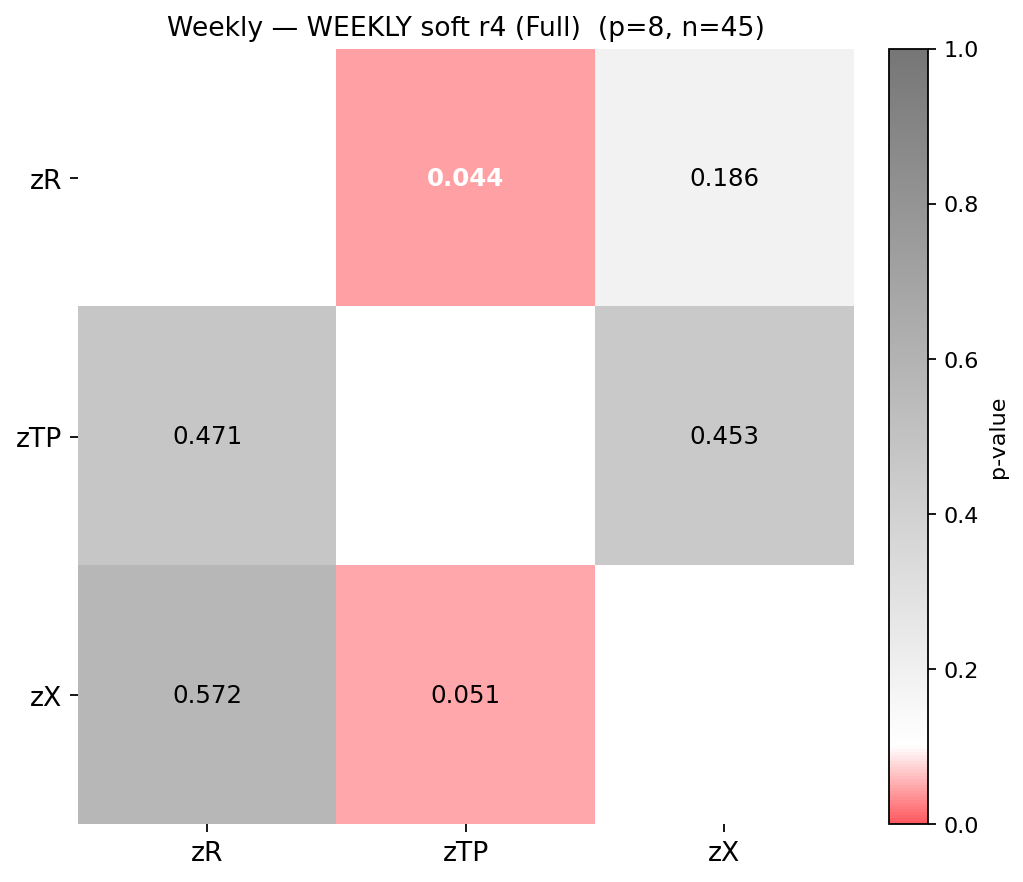

Saved: artifacts/granger_plots_main/granger_heatmap__weekly_soft_r4_full_p8.png


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.tsa.api import VAR

CAND = [
    Path("artifacts/event_only/spillovers/sentiment_weekly_soft_r4.csv"),
    Path("artifacts/spillovers/sentiment_weekly_soft_r4.csv"),
    Path("artifacts/sentiment_weekly_soft_r4.csv"),
]
p_csv = next((p for p in CAND if p.exists()), None)
assert p_csv is not None, f"Could not find weekly soft r4 CSV in: {CAND}"

df = pd.read_csv(p_csv, parse_dates=["week_start"])
assert "sent_z_soft_r4" in df.columns, "Expected column 'sent_z_soft_r4' not found."

KEEP = ["Reddit", "Trustpilot", "X (Twitter)"]
df = df[df["source"].isin(KEEP)].copy()
df = df[(df["week_start"] >= pd.to_datetime("2024-07-01")) &
        (df["week_start"] <= pd.to_datetime("2025-06-30"))]

wide = (df.pivot(index="week_start", columns="source", values="sent_z_soft_r4")
          .sort_index())
Y = wide[KEEP].dropna()
Y.columns = ["zR","zTP","zX"]
print("VAR matrix:", Y.shape, "| window:", Y.index.min().date(), "→", Y.index.max().date())

model = VAR(Y.astype(float))
res = model.fit(maxlags=8, trend="c")
print("Selected (fixed) lag p=8; nobs:", res.nobs)

names = res.names
P = pd.DataFrame(np.nan, index=names, columns=names, dtype=float)
for j in names:
    for i in names:
        if i == j:
            continue
        test = res.test_causality(j, [i], kind="f")
        try:
            pval = float(test.pvalue)
        except Exception:
            pval = float(test.summary().tables[0].data[-1][-1])
        P.loc[i, j] = pval

# Save the p-value table
OUT_DIR = Path("artifacts/granger_plots_main"); OUT_DIR.mkdir(parents=True, exist_ok=True)
(P.round(3)
   .to_csv(OUT_DIR / "granger_pvalues__weekly_soft_r4_full_p8.csv"))
print("\nPairwise Granger p-values (rows → columns):")
display(P.round(3))

CORAL_WHITE_GREY = LinearSegmentedColormap.from_list(
    "coral_white_grey",
    [(0.00, "#FF5A5F"), (0.10, "#FFFFFF"), (1.00, "#767676")],
)

fig, ax = plt.subplots(figsize=(6.6, 5.4), dpi=160, constrained_layout=True)
im = ax.imshow(P.values, cmap=CORAL_WHITE_GREY, vmin=0, vmax=1)
ax.set_xticks(range(len(P.columns))); ax.set_xticklabels(P.columns, fontsize=12)
ax.set_yticks(range(len(P.index)));   ax.set_yticklabels(P.index, fontsize=12)
ax.set_title("Weekly — WEEKLY soft r4 (Full)  (p=8, n={})".format(int(res.nobs)),
             fontsize=12, pad=6)

for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        v = P.iat[i, j]
        if np.isfinite(v):
            ax.text(j, i, f"{v:.3f}",
                    ha="center", va="center",
                    color=("#FFFFFF" if v < 0.05 else "#000000"),
                    fontweight=("bold" if v < 0.05 else "normal"), fontsize=11)

cbar = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.04)
cbar.set_label("p-value")
ax.set_aspect("equal")
for sp in ax.spines.values(): sp.set_visible(False)

png_out = OUT_DIR / "granger_heatmap__weekly_soft_r4_full_p8.png"
fig.savefig(png_out, dpi=220, bbox_inches="tight"); plt.show()
print("Saved:", png_out)

WEEKLY soft r4 (Full): VAR matrix (53, 3)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


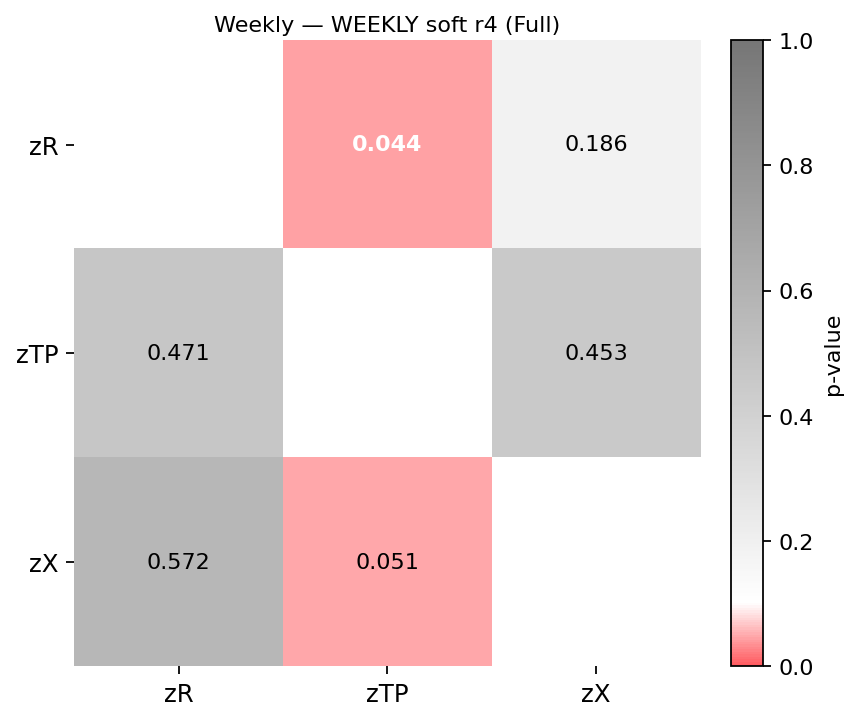

WEEKLY soft r4 (2024-H2): VAR matrix (27, 3)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


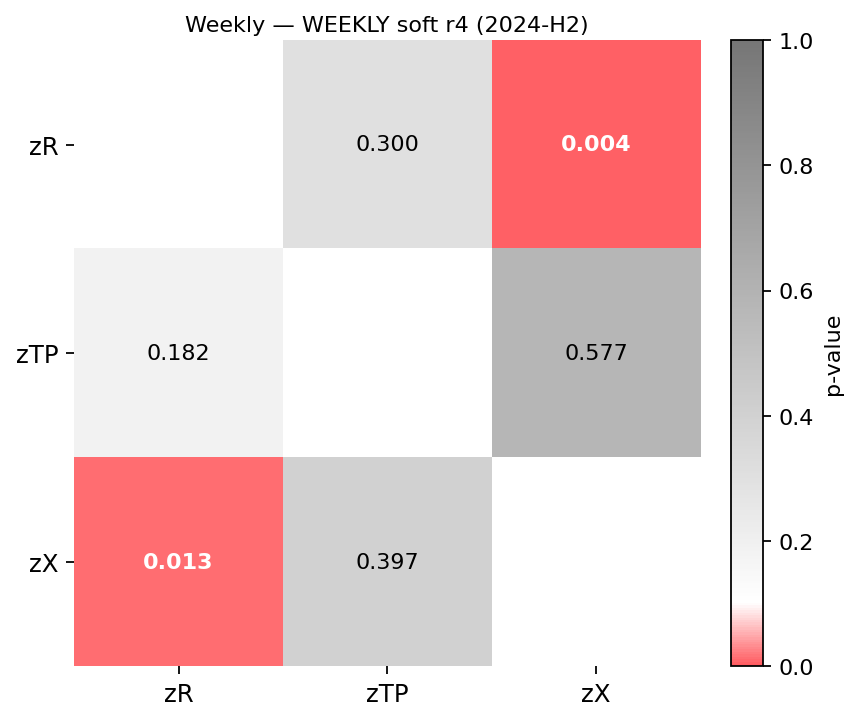

WEEKLY soft r4 (2025-H1): VAR matrix (26, 3)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


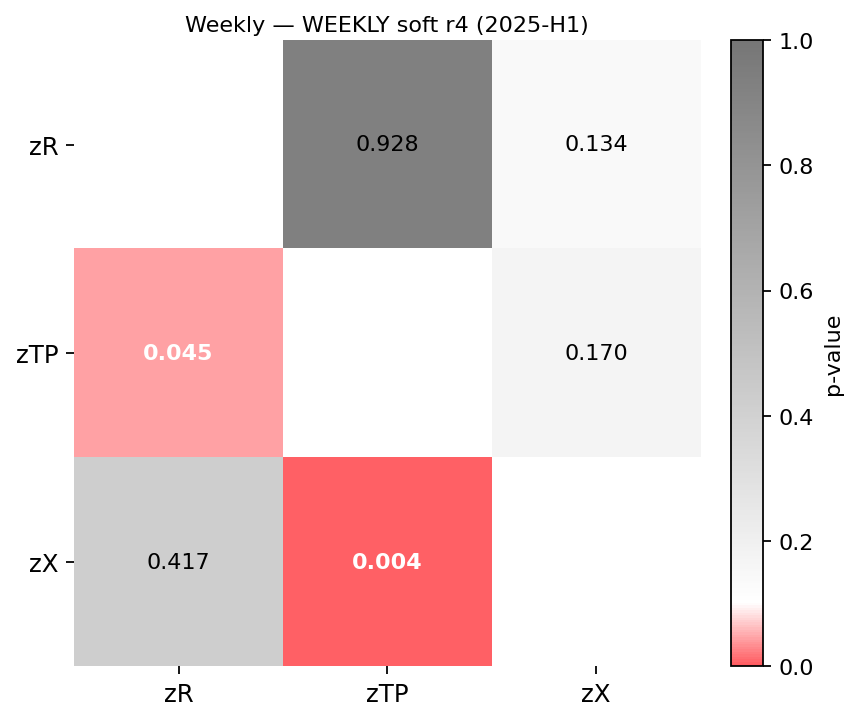

DAILY soft r7 (Full): VAR matrix (365, 3)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


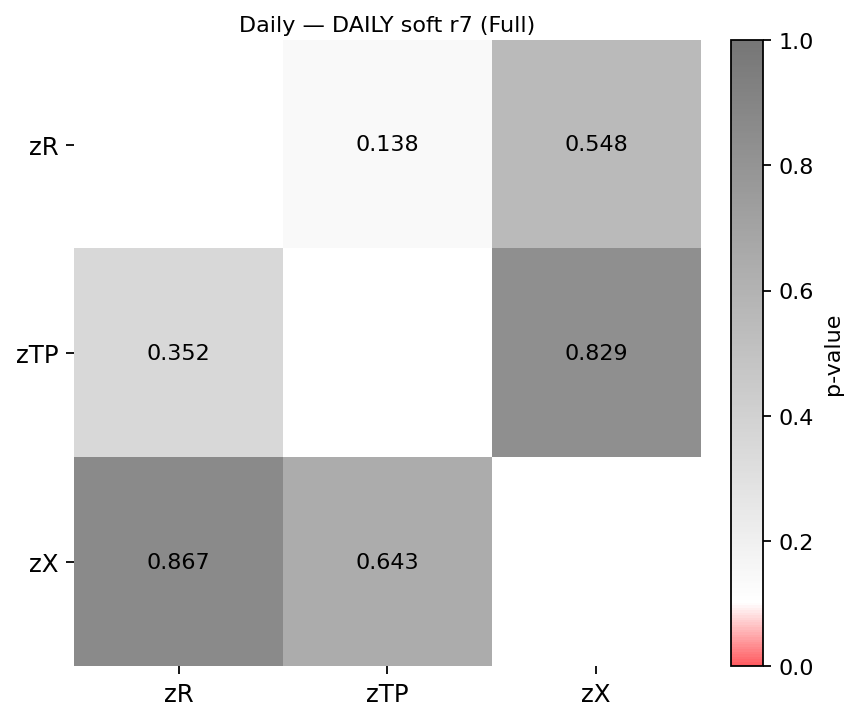

DAILY soft r7 (2024-H2): VAR matrix (184, 3)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


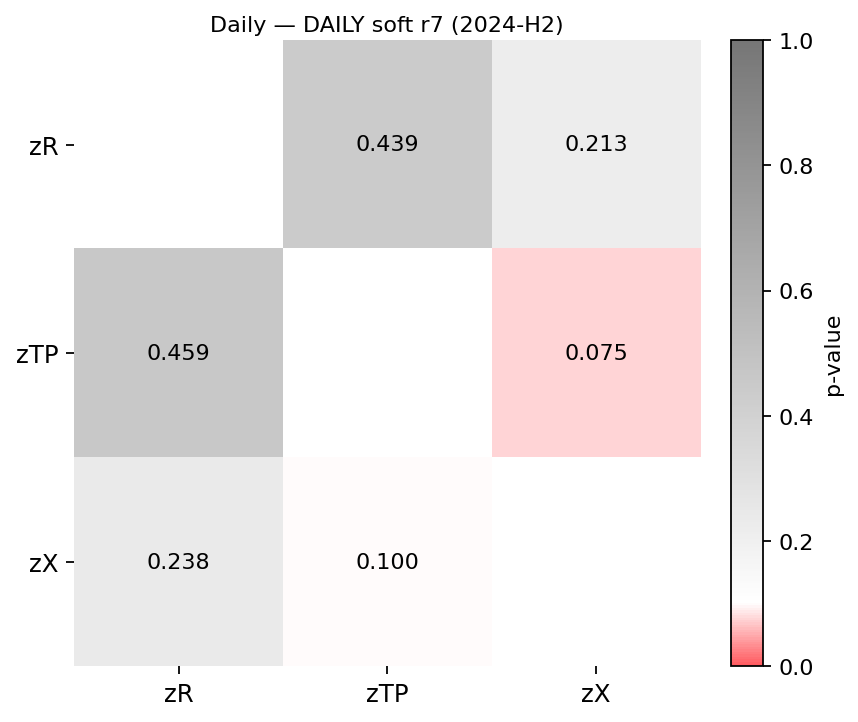

DAILY soft r7 (2025-H1): VAR matrix (181, 3)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


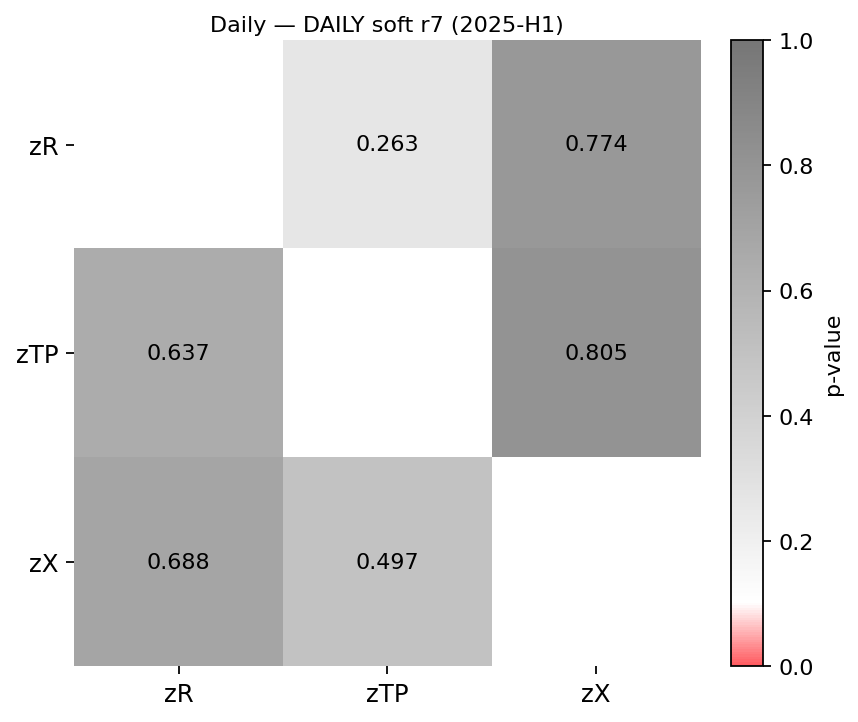

✅ Saved Granger p-values to artifacts/event_only/spillovers/granger_pvalues_smoothed.csv


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.tsa.api import VAR

WEEKLY_SOFT_R4 = ARTIFACTS / "sentiment_weekly_soft_r4.csv"
DAILY_SOFT_R7  = ARTIFACTS / "sentiment_daily_soft_r7.csv"
OUT_GRANGER    = ARTIFACTS / "granger_pvalues_smoothed.csv"

ORDER = ["Reddit", "Trustpilot", "X (Twitter)"]
NAMES = ["zR", "zTP", "zX"]

def _select_lag(Y: pd.DataFrame, cap=8) -> int:
    maxlags = min(cap, max(1, len(Y)//6))
    while maxlags >= 1:
        try:
            sel = VAR(Y).select_order(maxlags=maxlags)
            p = int(sel.aic) if sel.aic is not None else 1
            return max(1, min(p, maxlags))
        except Exception:
            maxlags -= 1
    return 1

def _prep_wide(csv_path: Path, date_col: str, value_col: str,
               start=None, end=None) -> pd.DataFrame:
    df = pd.read_csv(csv_path, parse_dates=[date_col])
    if start is not None: df = df[df[date_col] >= pd.to_datetime(start)]
    if end   is not None: df = df[df[date_col] <= pd.to_datetime(end)]
    wide = (df.pivot(index=date_col, columns="source", values=value_col)
              .sort_index())
    cols = [c for c in ORDER if c in wide.columns]
    Y = wide[cols].dropna().copy()
    Y.columns = NAMES[:len(cols)]
    return Y

def granger_pairs(Y: pd.DataFrame, tag: str, freq: str) -> pd.DataFrame:
    p = _select_lag(Y, cap=8)
    res = VAR(Y).fit(p)
    out = []
    for j in res.names:
        for i in res.names:
            if i == j:
                continue
            test = res.test_causality(j, [i], kind="f")
            pval = getattr(test, "pvalue", None)
            if pval is None:
                pval = float(test.summary().tables[1].data[-1][-1])
            out.append({
                "frequency": freq,
                "window": tag,
                "from": i,
                "to": j,
                "pvalue": float(pval),
                "selected_p": p,
                "n": int(res.nobs),
                "start": Y.index.min().date(),
                "end": Y.index.max().date(),
            })
    return pd.DataFrame(out)

CORAL_WHITE_GREY = LinearSegmentedColormap.from_list(
    "coral_white_grey",
    [
        (0.00, "#FF5A5F"),  # vivid coral for p ≈ 0
        (0.10, "#FFFFFF"),  # neutral white around mid-range p
        (1.00, "#767676")   # light grey for p → 1
    ]
)

def style_granger(df_one_window: pd.DataFrame, title: str):
    mat = (df_one_window
           .pivot(index="from", columns="to", values="pvalue")
           .reindex(index=NAMES[:len(df_one_window["from"].unique())],
                    columns=NAMES[:len(df_one_window["to"].unique())]))
    def _fmt(v):
        if pd.isna(v): return ""
        stars = "***" if v < 0.001 else ("**" if v < 0.01 else ("*" if v < 0.05 else ""))
        return f"{v:.3f}{('*' if stars else '')}".replace("*", stars)
    styled = (mat.style
              .format(_fmt)
              .background_gradient(cmap=CORAL_WHITE_GREY, vmin=0.0, vmax=1.0, axis=None)
              .set_caption(title))
    return styled

def heatmap_granger_coralwhitegrey(df_one, title, figsize=(5.8, 4.4), title_size=10, save_path=None):
    mat = (df_one.pivot(index="from", columns="to", values="pvalue")
                 .reindex(index=["zR","zTP","zX"], columns=["zR","zTP","zX"]))
    fig, ax = plt.subplots(figsize=figsize, dpi=160, constrained_layout=True)
    im = ax.imshow(mat.values, cmap=CORAL_WHITE_GREY, vmin=0, vmax=1)

    ax.set_xticks(range(mat.shape[1])); ax.set_xticklabels(mat.columns, fontsize=11)
    ax.set_yticks(range(mat.shape[0])); ax.set_yticklabels(mat.index, fontsize=11)
    ax.set_title(title, fontsize=title_size, fontweight=400, pad=4)

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            v = mat.iat[i, j]
            if pd.notna(v):
                ax.text(j, i, f"{v:.3f}",
                        ha="center", va="center",
                        color=("#FFFFFF" if v < 0.05 else "#000000"),
                        fontweight=("bold" if v < 0.05 else "normal"), fontsize=10)

    cbar = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.04)
    cbar.set_label("p-value")

    ax.set_aspect("equal")
    for spine in ax.spines.values(): spine.set_visible(False)

    if save_path:
        fig.savefig(save_path, dpi=220, bbox_inches="tight")
    plt.show()
    return fig, ax

def _matrix(df_one_window: pd.DataFrame, title: str, save_dir: Path | None = None):
    """Thin wrapper to draw (and optionally save) the heatmap for a window."""
    fname = None
    if save_dir is not None:
        save_dir.mkdir(parents=True, exist_ok=True)
        safe = title.replace(" ", "_").replace("/", "-")
        fname = save_dir / f"granger_heatmap_{safe}.png"
    return heatmap_granger_coralwhitegrey(df_one_window, title, save_path=fname)

weekly_windows = [
    ("WEEKLY soft r4 (Full)",    "2024-07-01", "2025-06-30"),
    ("WEEKLY soft r4 (2024-H2)", "2024-07-01", "2024-12-31"),
    ("WEEKLY soft r4 (2025-H1)", "2025-01-01", "2025-06-30"),
]

weekly_rows = []
for tag, start, end in weekly_windows:
    Y = _prep_wide(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4", start, end)
    print(f"{tag}: VAR matrix {Y.shape}")
    rows = granger_pairs(Y, tag=tag, freq="weekly")
    weekly_rows.append(rows)
    _matrix(rows, title=f"Weekly — {tag}", save_dir=ARTIFACTS / "granger_plots")

weekly_df = pd.concat(weekly_rows, ignore_index=True)

daily_windows = [
    ("DAILY soft r7 (Full)",    "2024-07-01", "2025-06-30"),
    ("DAILY soft r7 (2024-H2)", "2024-07-01", "2024-12-31"),
    ("DAILY soft r7 (2025-H1)", "2025-01-01", "2025-06-30"),
]

daily_rows = []
for tag, start, end in daily_windows:
    Y = _prep_wide(DAILY_SOFT_R7, "date", "sent_z_soft_r7", start, end)
    print(f"{tag}: VAR matrix {Y.shape}")
    rows = granger_pairs(Y, tag=tag, freq="daily")
    daily_rows.append(rows)
    _matrix(rows, title=f"Daily — {tag}", save_dir=ARTIFACTS / "granger_plots")

daily_df = pd.concat(daily_rows, ignore_index=True)

granger_all = pd.concat([weekly_df, daily_df], ignore_index=True)
granger_all.to_csv(OUT_GRANGER, index=False)
print(f"✅ Saved Granger p-values to {OUT_GRANGER}")

for (freq, window), g in granger_all.groupby(["frequency","window"], sort=False):
    p_used = int(g["selected_p"].iloc[0])
    n_used = int(g["n"].iloc[0])
    title  = f"{freq.upper()} — {window} (p={p_used}, n={n_used})"
    display(style_granger(g, title))

In [ ]:
from statsmodels.stats.multitest import multipletests
def add_fdr(df):
    mask = df["pvalue"].notna()
    df = df.copy()
    df.loc[mask, "fdr_q10"] = multipletests(df.loc[mask,"pvalue"], method="fdr_bh", alpha=0.10)[0]
    return df
sig_fdr = granger_all.groupby(["frequency","window"], group_keys=False).apply(add_fdr)
display(sig_fdr.query("fdr_q10==True")[["frequency","window","from","to","pvalue"]])

/tmp/ipython-input-828225945.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sig_fdr = granger_all.groupby(["frequency","window"], group_keys=False).apply(add_fdr)


frequency                    window from   to    pvalue
7     weekly  WEEKLY soft r4 (2024-H2)   zX   zR  0.013497
10    weekly  WEEKLY soft r4 (2024-H2)   zR   zX  0.004113
15    weekly  WEEKLY soft r4 (2025-H1)   zX  zTP  0.004428

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


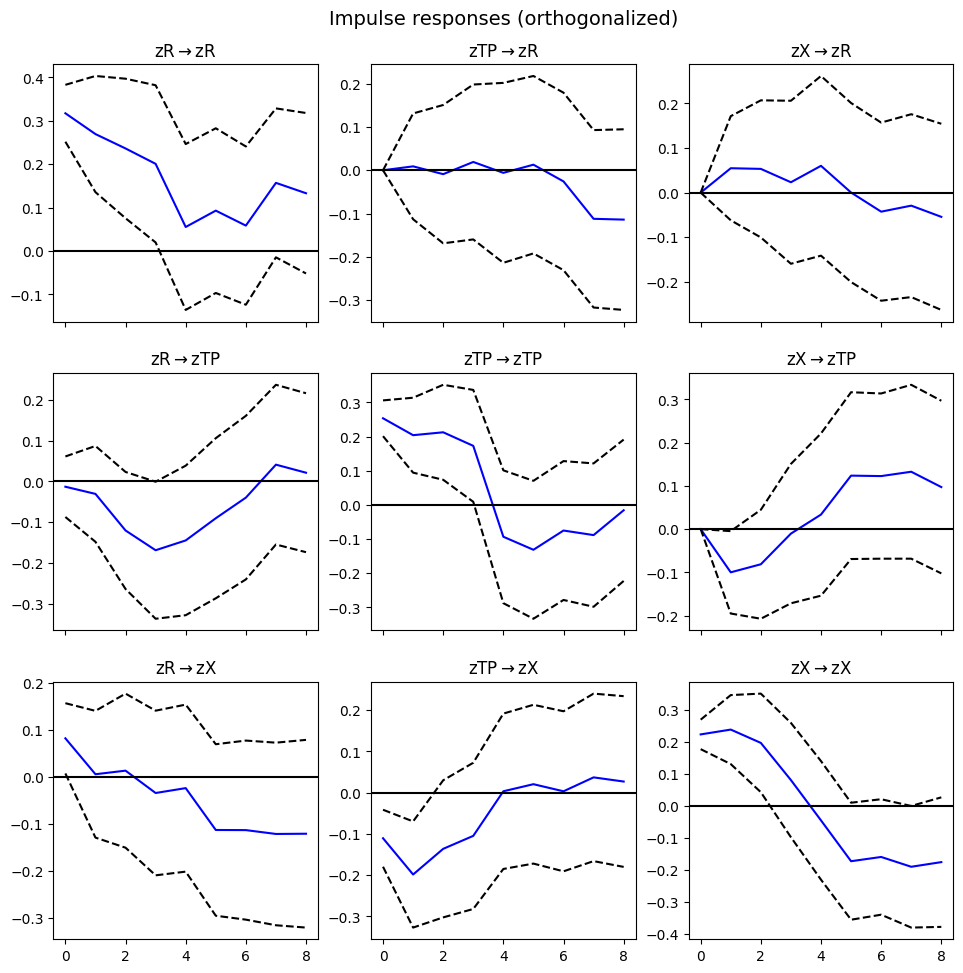

In [ ]:
def fit_var_irf(Y, p):
    res = VAR(Y).fit(p)
    irf = res.irf(8)
    fig = irf.plot(orth=True)
    return res, fig

w = pd.read_csv(WEEKLY_SOFT_R4, parse_dates=["week_start"])
Y = (w.pivot(index="week_start", columns="source", values="sent_z_soft_r4")
       .reindex(columns=["Reddit","Trustpilot","X (Twitter)"]).dropna())
Y.columns = ["zR","zTP","zX"]
p = max(1, min(8, len(Y)//6))
res, irf_fig = fit_var_irf(Y, p)

**H3**

In [ ]:
WEEKLY_SOFT_R4 = ARTIFACTS / "sentiment_weekly_soft_r4.csv"
DAILY_SOFT_R7  = ARTIFACTS / "sentiment_daily_soft_r7.csv"

ORDER = ["Reddit","Trustpilot","X (Twitter)"]
NAMES = ["zR","zTP","zX"]

# Airbnb palette
AIRBNB = {
    "rausch": "#FF5A5F",   # < .01
    "arches": "#FC642D",   # .01–.05
    "babu":   "#00A699",   # .05–.10
    "foggy":  "#767676",   # text/neutral
}

def _select_lag(Y: pd.DataFrame, cap=8) -> int:
    maxlags = min(cap, max(1, len(Y)//6))
    while maxlags >= 1:
        try:
            sel = VAR(Y).select_order(maxlags=maxlags)
            p = int(sel.aic) if sel.aic is not None else 1
            return max(1, min(p, maxlags))
        except Exception:
            maxlags -= 1
    return 1

def _prep_wide(csv_path: Path, date_col: str, value_col: str, start=None, end=None) -> pd.DataFrame:
    df = pd.read_csv(csv_path, parse_dates=[date_col])
    if start is not None: df = df[df[date_col] >= pd.to_datetime(start)]
    if end   is not None: df = df[df[date_col] <= pd.to_datetime(end)]
    wide = df.pivot(index=date_col, columns="source", values=value_col).sort_index()
    cols = [c for c in ORDER if c in wide.columns]
    Y = wide[cols].dropna().copy()
    Y.columns = NAMES[:len(cols)]
    return Y

def girf_with_bands(res, H=8, repl=1000, seed=123, generalized=True):
    want_nonorth = bool(generalized)

    try:
        irf_obj = res.irf(H, orth=(not want_nonorth))
    except TypeError:
        irf_obj = res.irf(H)

    g = irf_obj.irfs

    try:
        lo, hi = res.irf_errband_mc(repl=repl, orth=(not want_nonorth), seed=seed)
    except TypeError:
        try:
            lo, hi = res.irf_errband_mc(repl=repl, seed=seed)
        except TypeError:
            lo, hi = res.irf_errband_mc(repl=repl)

    return g, lo, hi

def cum_along_h(arr):
    return arr.cumsum(axis=0)

def bar_grid_cum8(girf_cum, lo_cum, hi_cum, names, title, outdir=None):
    H = girf_cum.shape[0] - 1
    k = girf_cum.shape[1]

    fig, axes = plt.subplots(k, k, figsize=(9, 9), dpi=140)
    for i in range(k):
        for j in range(k):
            ax = axes[i, j]
            if i == j:
                ax.axis("off")
                continue

            val = float(girf_cum[H, i, j])
            lo  = float(lo_cum[H, i, j])
            hi  = float(hi_cum[H, i, j])

            if lo > 0:
                color = AIRBNB["babu"]
            elif hi < 0:
                color = AIRBNB["rausch"]
            else:
                color = AIRBNB["arches"]

            err_low  = max(0.0, val - lo)
            err_high = max(0.0, hi - val)
            yerr = np.array([[err_low], [err_high]])

            ax.bar([0], [val], width=0.6, color=color, edgecolor="none",
                   yerr=yerr, capsize=4, linewidth=0)
            ax.axhline(0, color="#bbbbbb", lw=1)
            ax.set_xticks([])
            ax.set_title(f"{names[j]} → {names[i]}", fontsize=10, color=AIRBNB["foggy"])

        for j in range(k):
            axes[i, j].tick_params(axis="y", labelsize=8)

    fig.suptitle(f"{title}\nCumulated response (0..8)", y=0.98, fontsize=14, fontweight=600)
    plt.tight_layout()

    if outdir:
        outdir.mkdir(parents=True, exist_ok=True)
        (outdir / f"{title.replace(' ','_').replace('/','-')}_cum8.png").write_bytes(fig_to_png_bytes(fig))

    return fig

def fig_to_png_bytes(fig):
    import io
    bio = io.BytesIO()
    fig.savefig(bio, format="png", bbox_inches="tight", dpi=160)
    return bio.getvalue()

def fevd_tables(res, steps=(4, 8), names=None):
    if names is None:
        names = list(res.names)
    k = len(names)
    Hmax = max(steps)

    fe = res.fevd(Hmax)
    dec = getattr(fe, "decomp", None)

    def _frame(arr2d):
        return pd.DataFrame(np.asarray(arr2d), index=names, columns=names)

    if callable(dec):
        def get(h): return _frame(dec(h))

    else:
        D = None if dec is None else np.asarray(dec)

        if D is None or D.ndim != 3:
            if hasattr(fe, "decomp"):
                def get(h): return _frame(fe.decomp(h))
            else:
                raise RuntimeError("FEVD format not recognized.")

        else:
            cand = [ax for ax, s in enumerate(D.shape) if s >= Hmax and s != k]
            if not cand:
                cand = [ax for ax, s in enumerate(D.shape) if s >= Hmax]
            if not cand:
                raise ValueError(f"Unexpected FEVD shape: {D.shape}")
            step_axis = cand[0]

            if step_axis == 0:
                def get(h): return _frame(D[h-1, :, :])
            elif step_axis == 1:
                def get(h): return _frame(D[:, h-1, :])
            elif step_axis == 2:
                def get(h): return _frame(D[:, :, h-1])
            else:
                raise ValueError(f"Unexpected FEVD shape: {D.shape}")

    tables = {h: (get(h) * 100.0).round(1) for h in steps}
    return tables

def wald_cum8_pos_vs_neg(res, H=8, repl=1000, seed=123):
    g, lo, hi = girf_with_bands(res, H=H, repl=repl, seed=seed)
    g_cum = g.cumsum(axis=0)
    diff = 2.0 * g_cum

    eps = 1e-12
    se = (hi.cumsum(axis=0)[H] - lo.cumsum(axis=0)[H]) / (2 * 1.96 + eps)
    z  = diff[H] / (se + eps)
    p = 2.0 * (1.0 - 0.5 * (1.0 + np.erf(np.abs(z) / np.sqrt(2.0))))

    idx = list(res.names)
    diff_df = pd.DataFrame(diff[H], index=idx, columns=idx)
    p_df    = pd.DataFrame(p,        index=idx, columns=idx)
    return diff_df, p_df

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


WEEKLY soft r4 (Full): fitted VAR(p=8), n=45, sample=2024-07-01…2025-06-30

FEVD @ h=4 — WEEKLY soft r4 (Full)


zR   zTP    zX
zR   97.5   0.2   2.3
zTP  18.2  74.9   6.9
zX    3.4  33.7  62.9


FEVD @ h=8 — WEEKLY soft r4 (Full)


zR   zTP    zX
zR   92.1   4.2   3.8
zTP  21.1  60.8  18.1
zX   13.0  22.0  65.1

WEEKLY soft r4 (2024-H2): fitted VAR(p=2), n=25, sample=2024-07-01…2024-12-30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)



FEVD @ h=4 — WEEKLY soft r4 (2024-H2)


zR   zTP    zX
zR   68.5   1.4  30.1
zTP  14.3  83.3   2.4
zX   39.3  27.8  32.9


FEVD @ h=8 — WEEKLY soft r4 (2024-H2)


zR   zTP    zX
zR   60.7   4.4  34.8
zTP  23.6  64.8  11.6
zX   38.0  23.9  38.1

WEEKLY soft r4 (2025-H1): fitted VAR(p=2), n=24, sample=2025-01-06…2025-06-30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)



FEVD @ h=4 — WEEKLY soft r4 (2025-H1)


zR   zTP    zX
zR   90.0   7.1   2.8
zTP   0.5  55.6  43.9
zX    1.6   7.1  91.3


FEVD @ h=8 — WEEKLY soft r4 (2025-H1)


zR   zTP    zX
zR   80.9  14.1   5.0
zTP  11.7  44.6  43.7
zX   20.6   8.5  70.9

DAILY soft r7 (Full): fitted VAR(p=8), n=357, sample=2024-07-01…2025-06-30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



FEVD @ h=4 — DAILY soft r7 (Full)


zR   zTP    zX
zR   99.1   0.2   0.8
zTP   0.5  98.9   0.6
zX    0.0   1.2  98.8


FEVD @ h=8 — DAILY soft r7 (Full)


zR   zTP    zX
zR   98.7   0.5   0.8
zTP   0.5  95.9   3.6
zX    1.6   0.8  97.6

DAILY soft r7 (2024-H2): fitted VAR(p=8), n=176, sample=2024-07-01…2024-12-31


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



FEVD @ h=4 — DAILY soft r7 (2024-H2)


zR   zTP    zX
zR   99.2   0.7   0.2
zTP   1.2  90.4   8.4
zX    0.8   0.5  98.6


FEVD @ h=8 — DAILY soft r7 (2024-H2)


zR   zTP    zX
zR   93.3   1.4   5.4
zTP   2.5  81.0  16.5
zX    1.2   1.3  97.5

DAILY soft r7 (2025-H1): fitted VAR(p=8), n=173, sample=2025-01-01…2025-06-30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



FEVD @ h=4 — DAILY soft r7 (2025-H1)


zR   zTP    zX
zR   98.4   0.4   1.2
zTP   0.8  98.9   0.3
zX    0.4   2.8  96.8


FEVD @ h=8 — DAILY soft r7 (2025-H1)


zR   zTP    zX
zR   91.0   2.2   6.8
zTP   2.0  94.2   3.8
zX    0.4   2.1  97.6

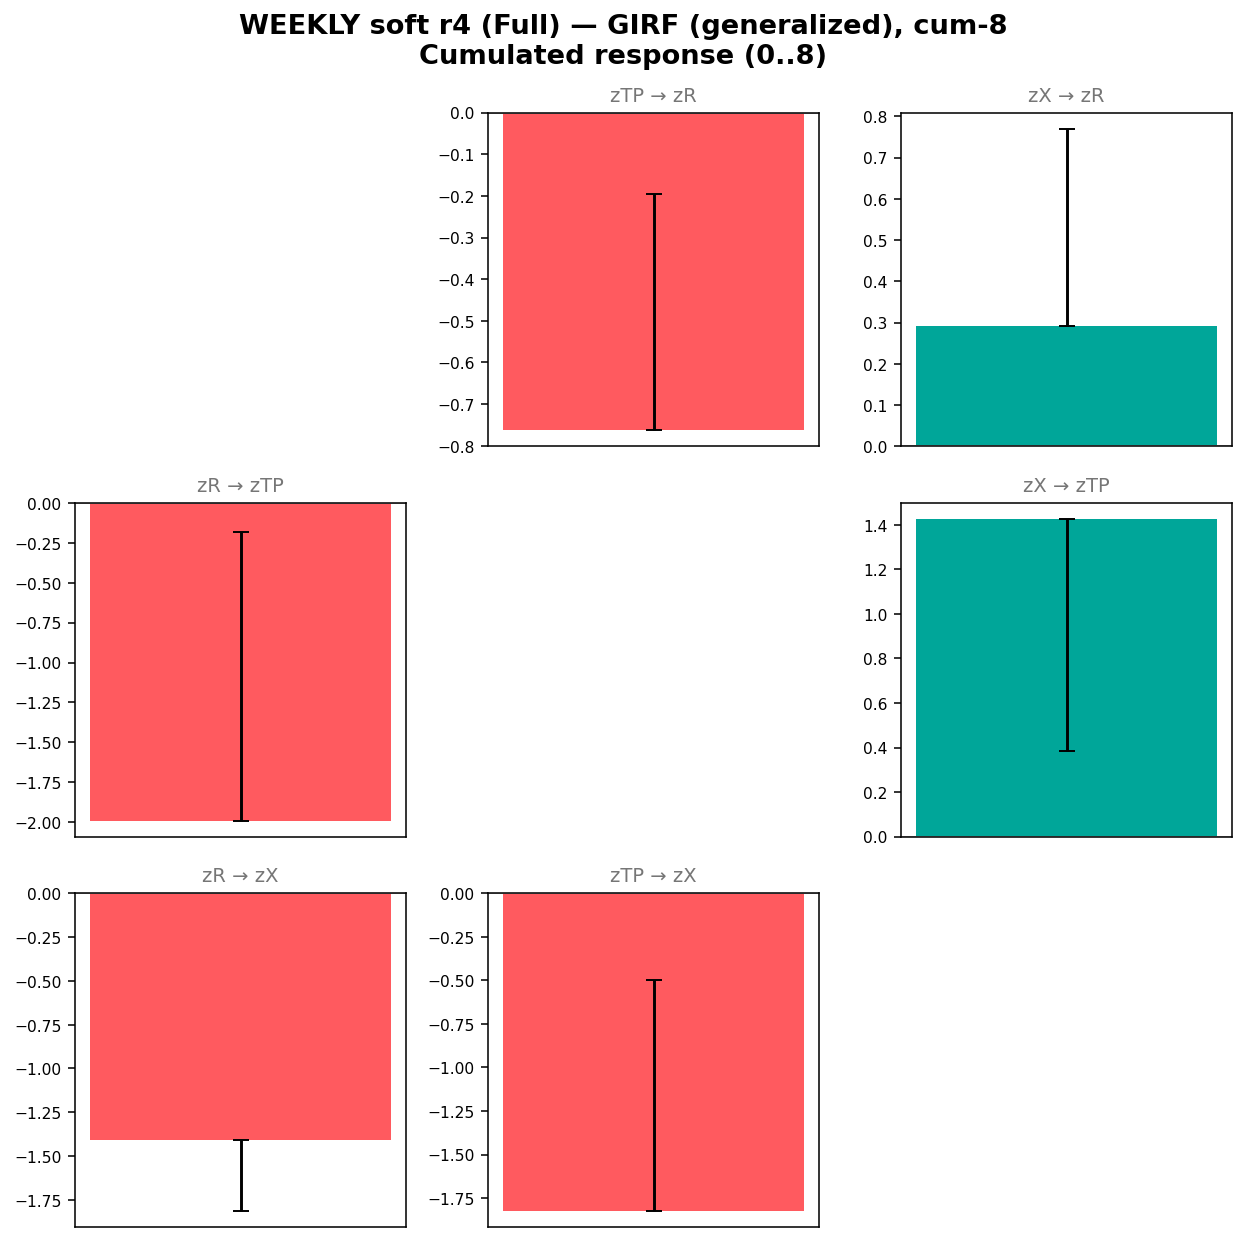

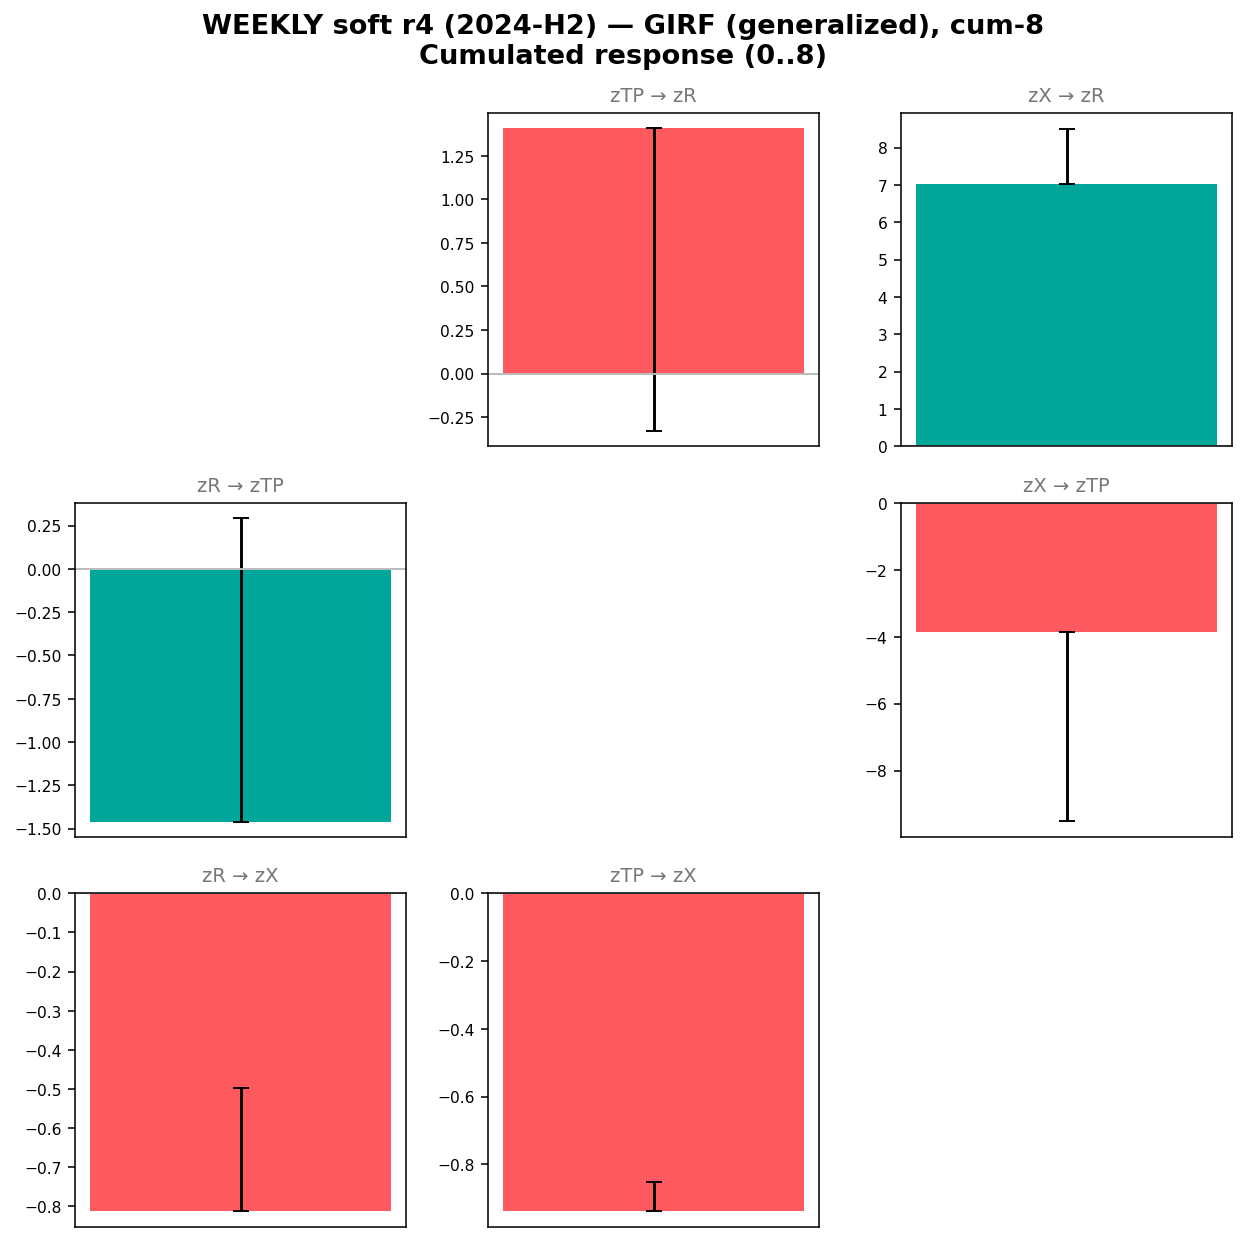

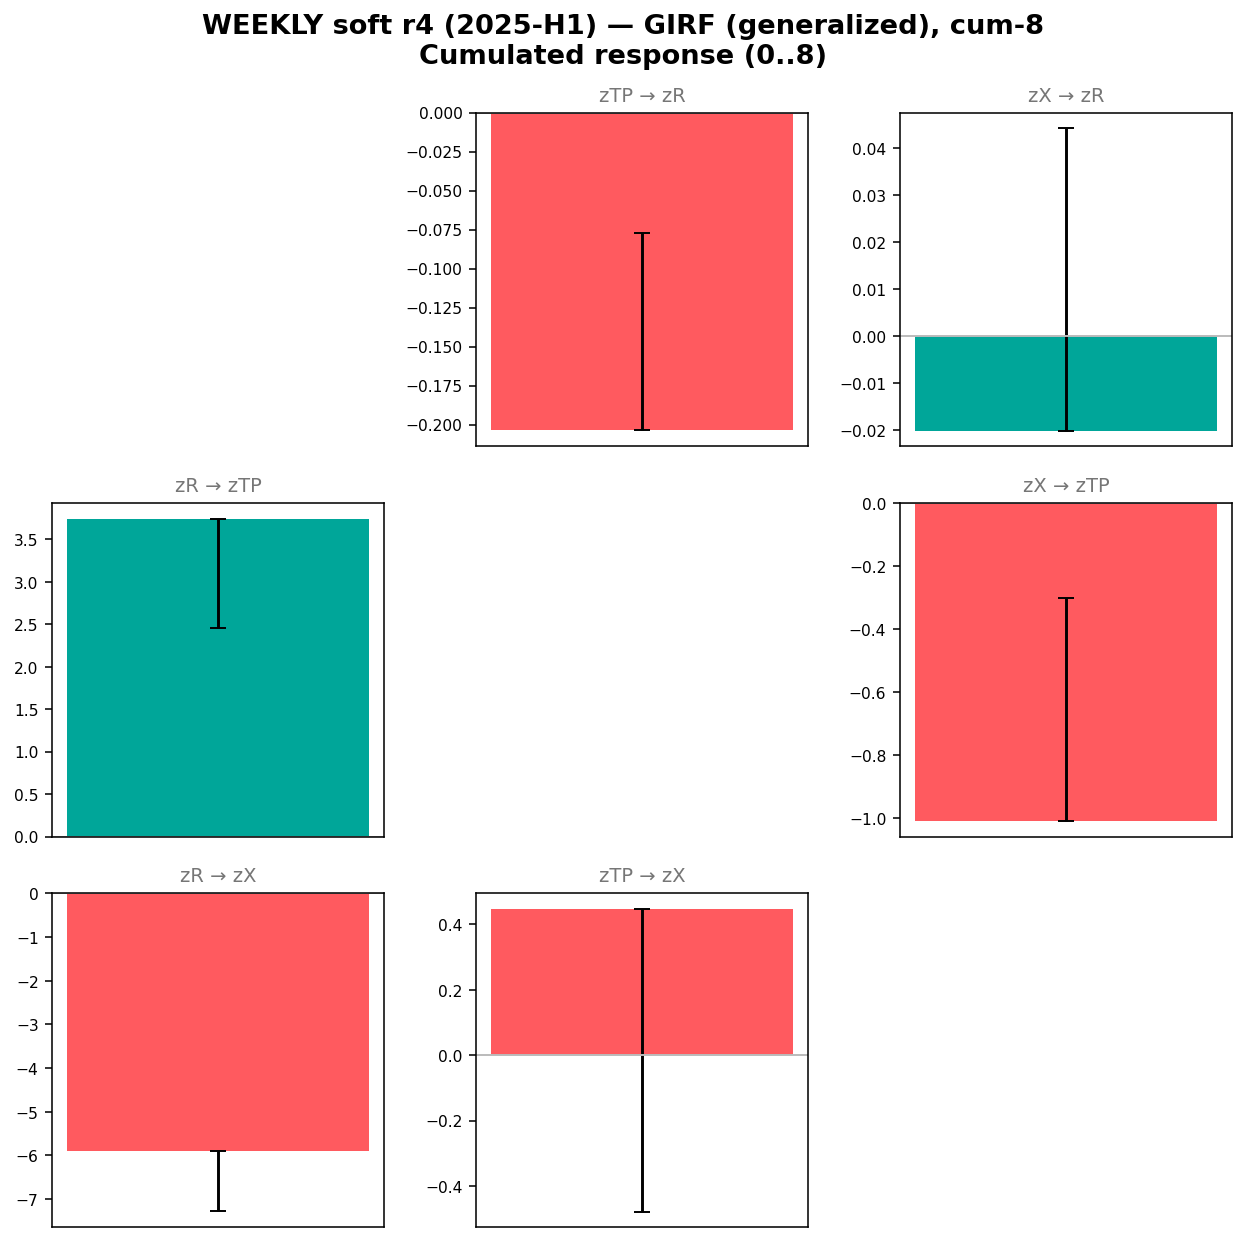

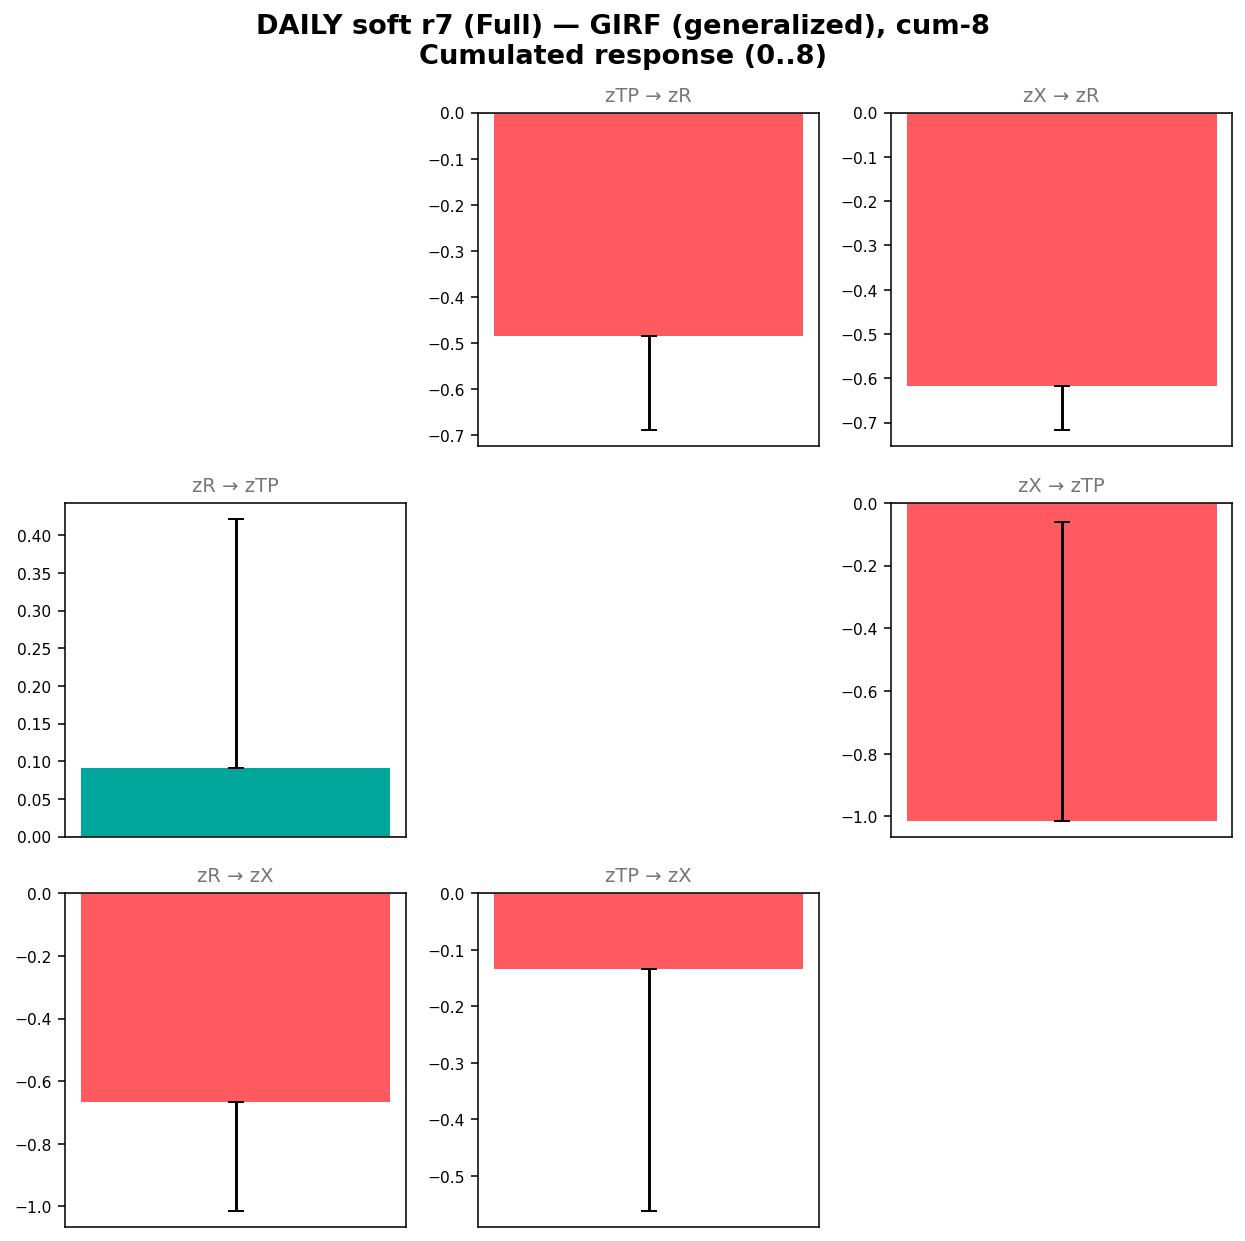

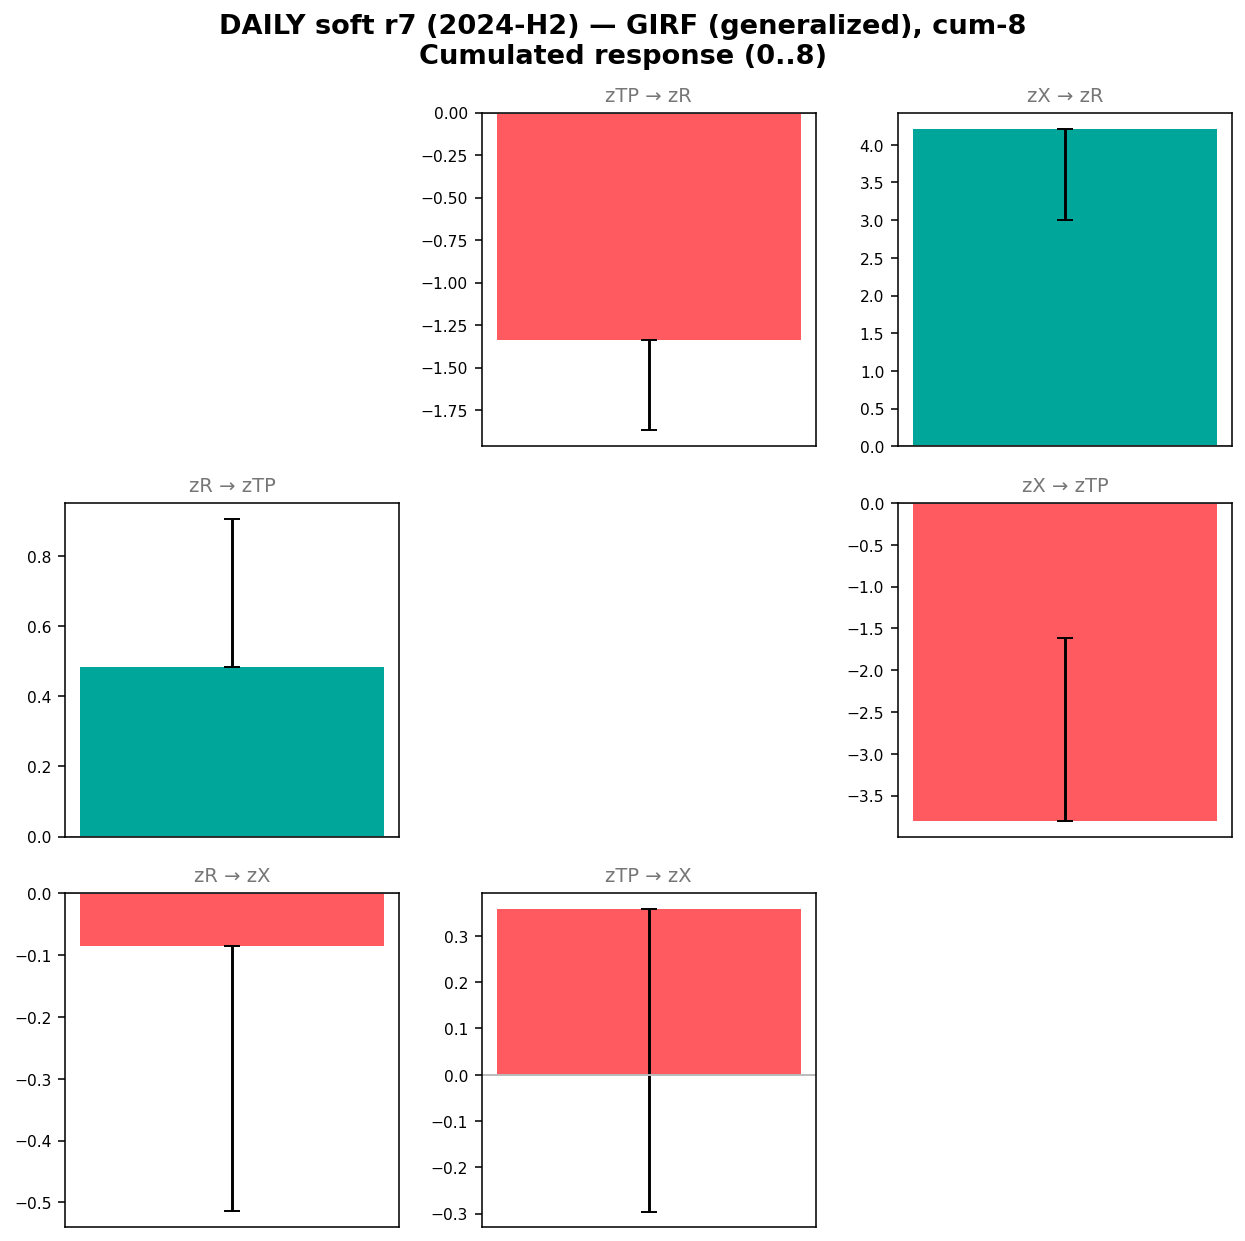

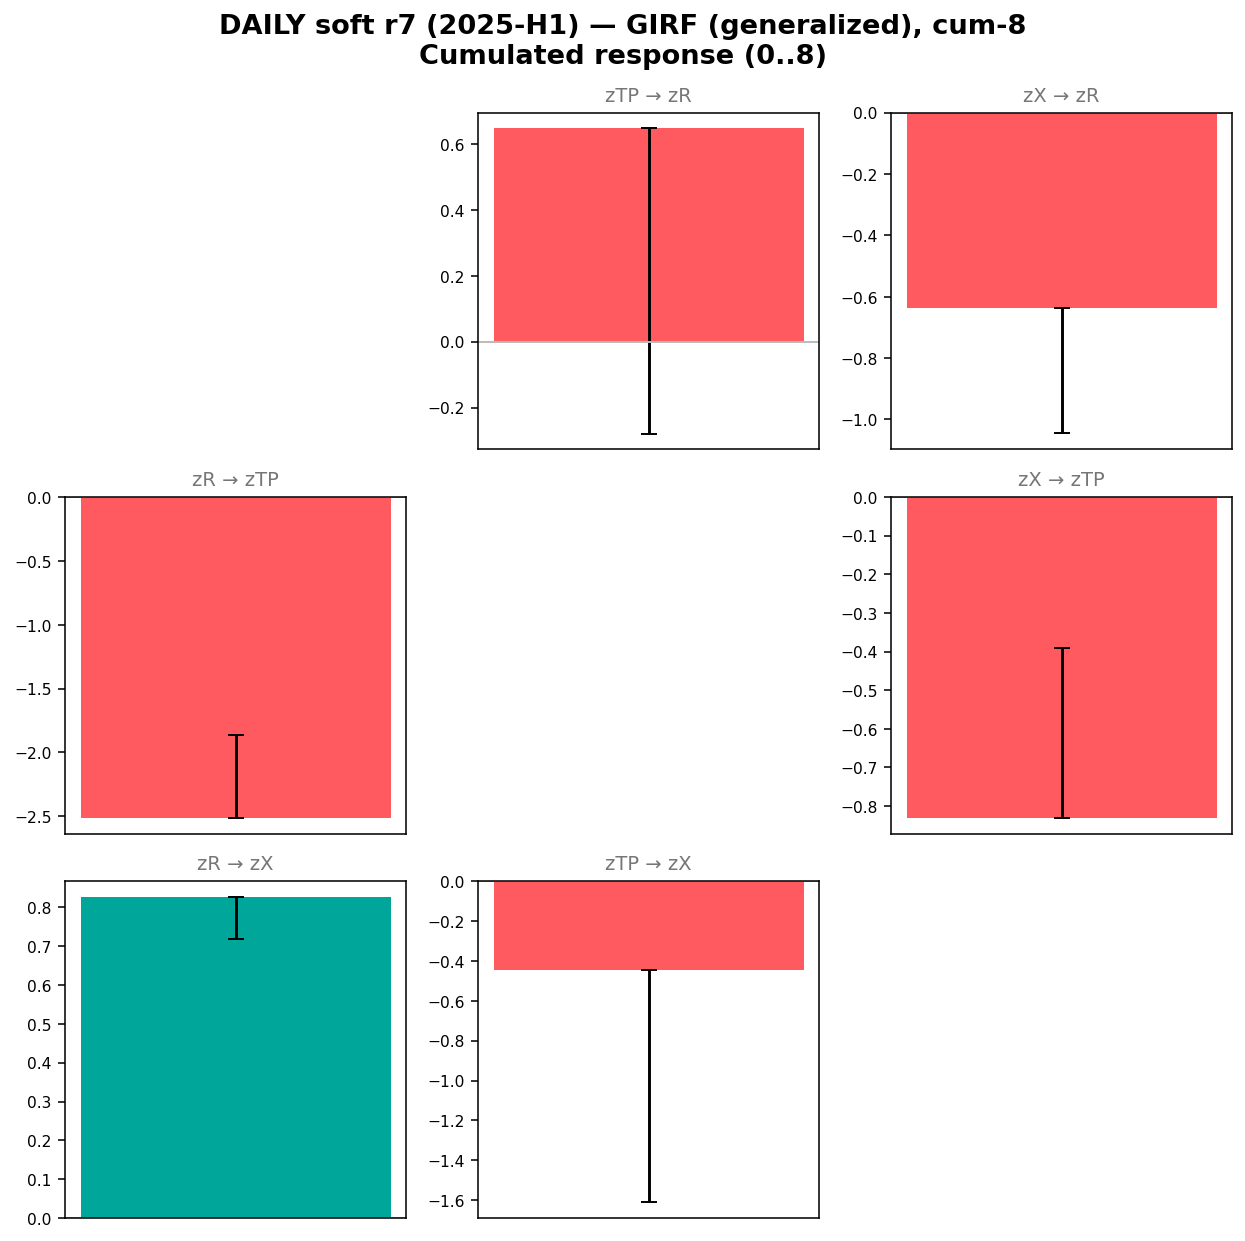

In [ ]:
SAVE_DIR = ARTIFACTS / "irf_fevd"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

def run_irf_and_fevd(csv_path, date_col, value_col, tag,
                     start=None, end=None, cap=8, H=8, repl=1200, seed=123):
    Y = _prep_wide(csv_path, date_col, value_col, start, end)
    if Y.shape[1] < 2:
        print(f"{tag}: need >=2 series; got {Y.shape[1]}")
        return None

    p   = _select_lag(Y, cap=cap)
    res = VAR(Y).fit(p)
    print(f"{tag}: fitted VAR(p={p}), n={res.nobs}, sample={Y.index.min().date()}…{Y.index.max().date()}")

    # GIRFs + cum-8 bars
    g, lo, hi = girf_with_bands(res, H=H, repl=repl, seed=seed)
    bar_grid_cum8(
        cum_along_h(g), cum_along_h(lo), cum_along_h(hi),
        list(res.names),
        f"{tag} — GIRF (generalized), cum-8",
        outdir=SAVE_DIR
    )

    # FEVD tables (already in %, rounded)
    tables = fevd_tables(res, steps=(4, 8), names=list(res.names))

    if 4 in tables and not tables[4].empty:
        print(f"\nFEVD @ h=4 — {tag}")
        display(tables[4])                      # already percent
        # If you want a % sign in the cells:
        # display(tables[4].astype(str) + "%")

    if 8 in tables and not tables[8].empty:
        print(f"\nFEVD @ h=8 — {tag}")
        display(tables[8])
        # display(tables[8].astype(str) + "%")

    return res

# === Weekly (soft r4) ===
res_w_full = run_irf_and_fevd(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4", "WEEKLY soft r4 (Full)")
res_w_2024 = run_irf_and_fevd(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4", "WEEKLY soft r4 (2024-H2)", start="2024-07-01", end="2024-12-31")
res_w_2025 = run_irf_and_fevd(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4", "WEEKLY soft r4 (2025-H1)", start="2025-01-01", end="2025-06-30")

# === Daily (soft r7) ===
res_d_full = run_irf_and_fevd(DAILY_SOFT_R7, "date", "sent_z_soft_r7", "DAILY soft r7 (Full)")
res_d_2024 = run_irf_and_fevd(DAILY_SOFT_R7, "date", "sent_z_soft_r7", "DAILY soft r7 (2024-H2)", start="2024-07-01", end="2024-12-31")
res_d_2025 = run_irf_and_fevd(DAILY_SOFT_R7, "date", "sent_z_soft_r7", "DAILY soft r7 (2025-H1)", start="2025-01-01", end="2025-06-30")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


WEEKLY soft r4 (Full): fitted VAR(p=8), n=45, sample=2024-07-01…2025-06-30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


WEEKLY soft r4 (2024-H2): fitted VAR(p=2), n=25, sample=2024-07-01…2024-12-30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


WEEKLY soft r4 (2025-H1): fitted VAR(p=2), n=24, sample=2025-01-06…2025-06-30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


DAILY soft r7 (Full): fitted VAR(p=8), n=357, sample=2024-07-01…2025-06-30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


DAILY soft r7 (2024-H2): fitted VAR(p=8), n=176, sample=2024-07-01…2024-12-31


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


DAILY soft r7 (2025-H1): fitted VAR(p=8), n=173, sample=2025-01-01…2025-06-30

Saved FEVD tables:
  • tidy  -> artifacts/event_only/spillovers/irf_fevd/FEVD_all_tidy.csv
  • wide  -> artifacts/event_only/spillovers/irf_fevd/FEVD_all_wide.csv


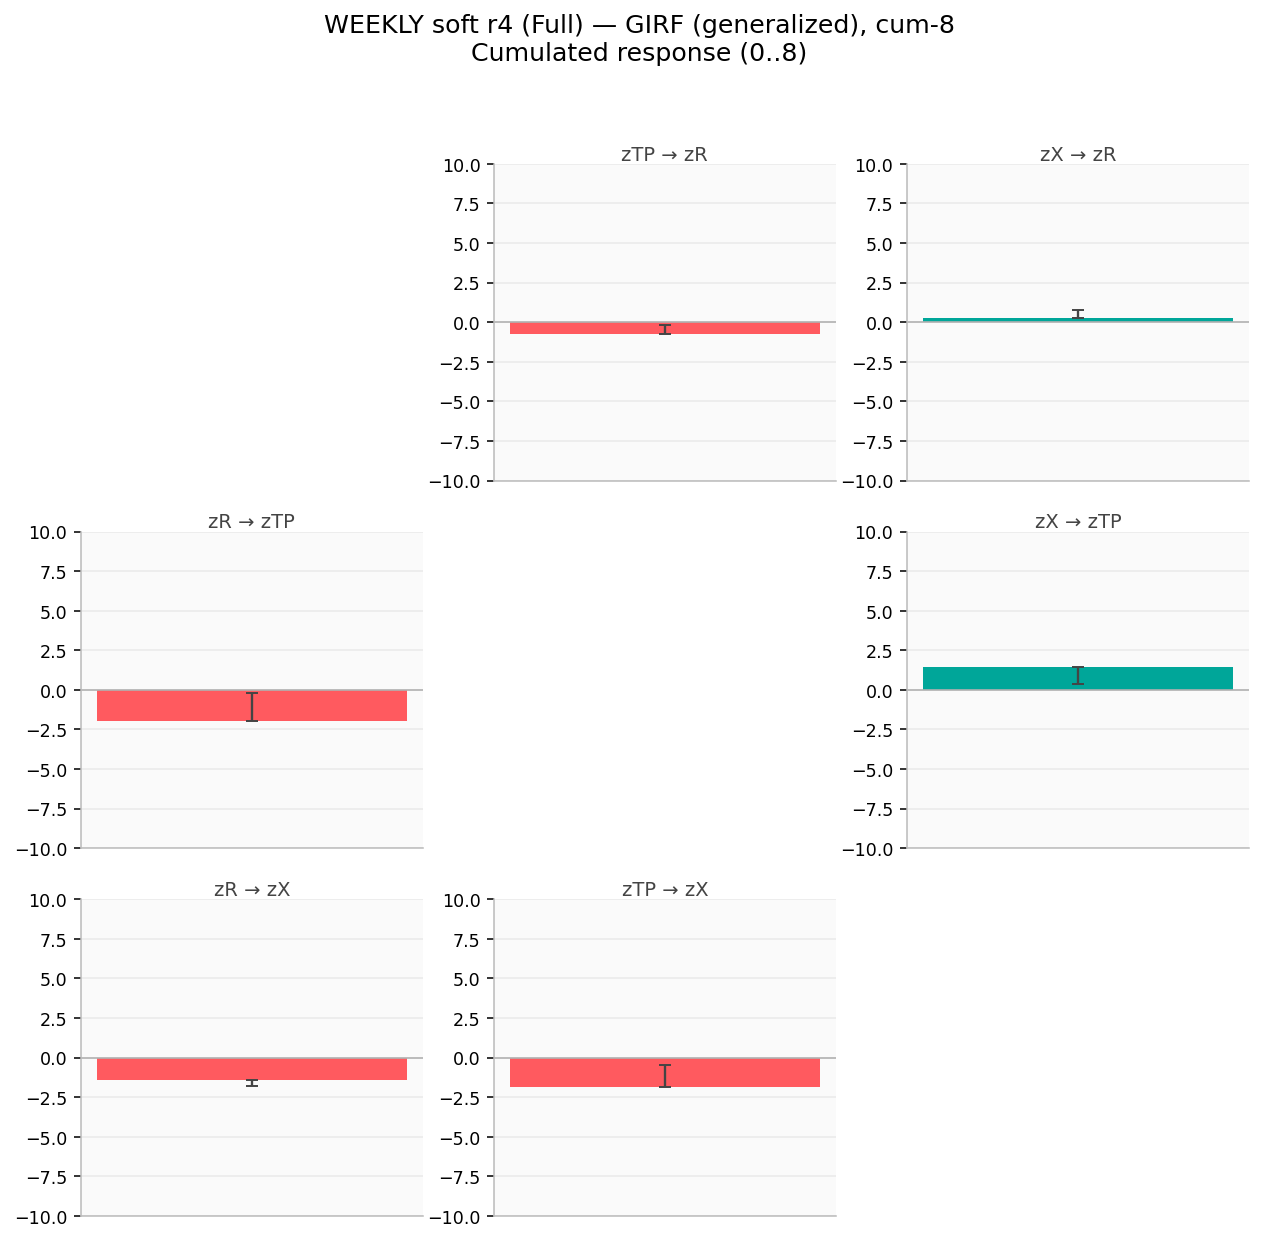

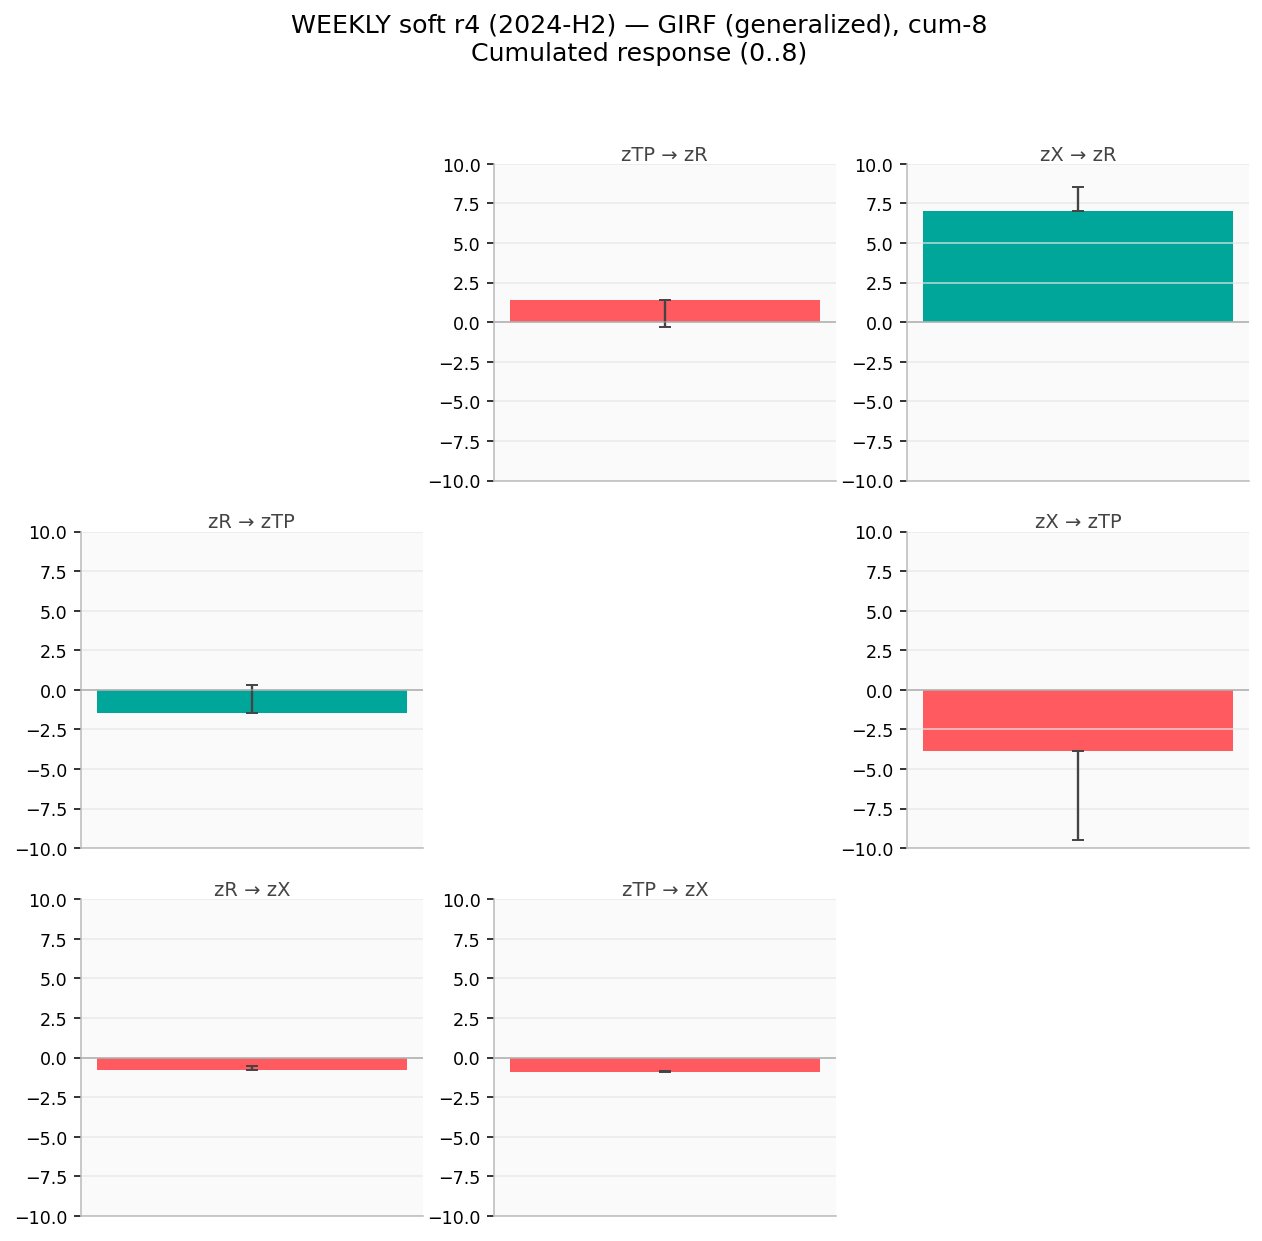

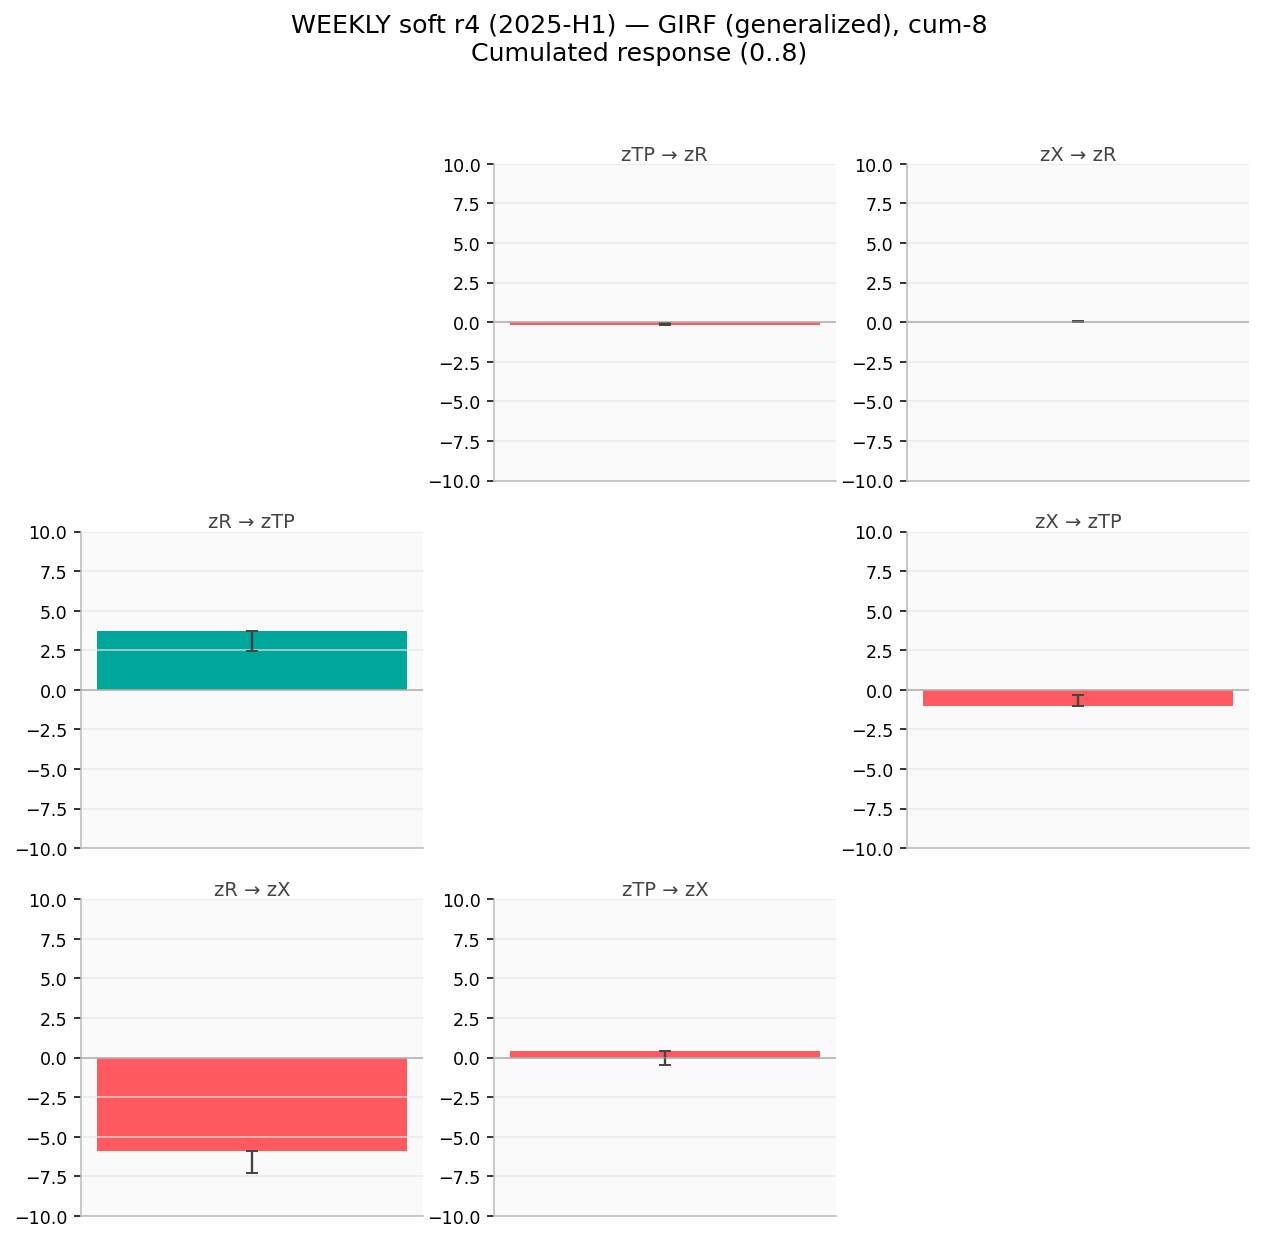

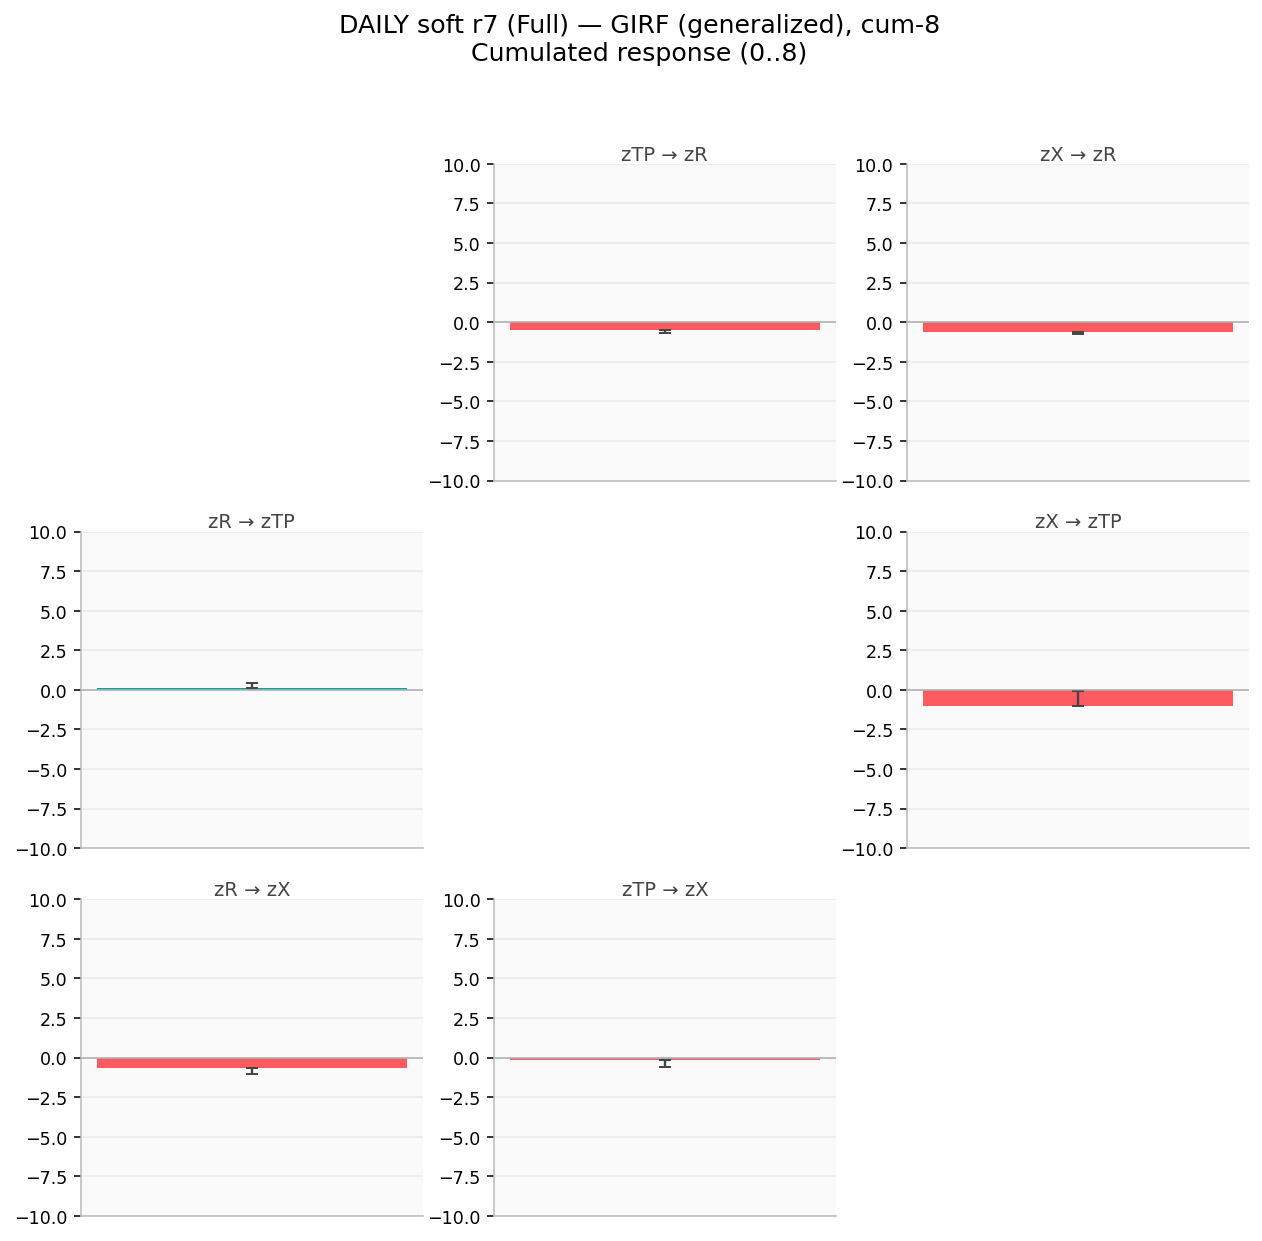

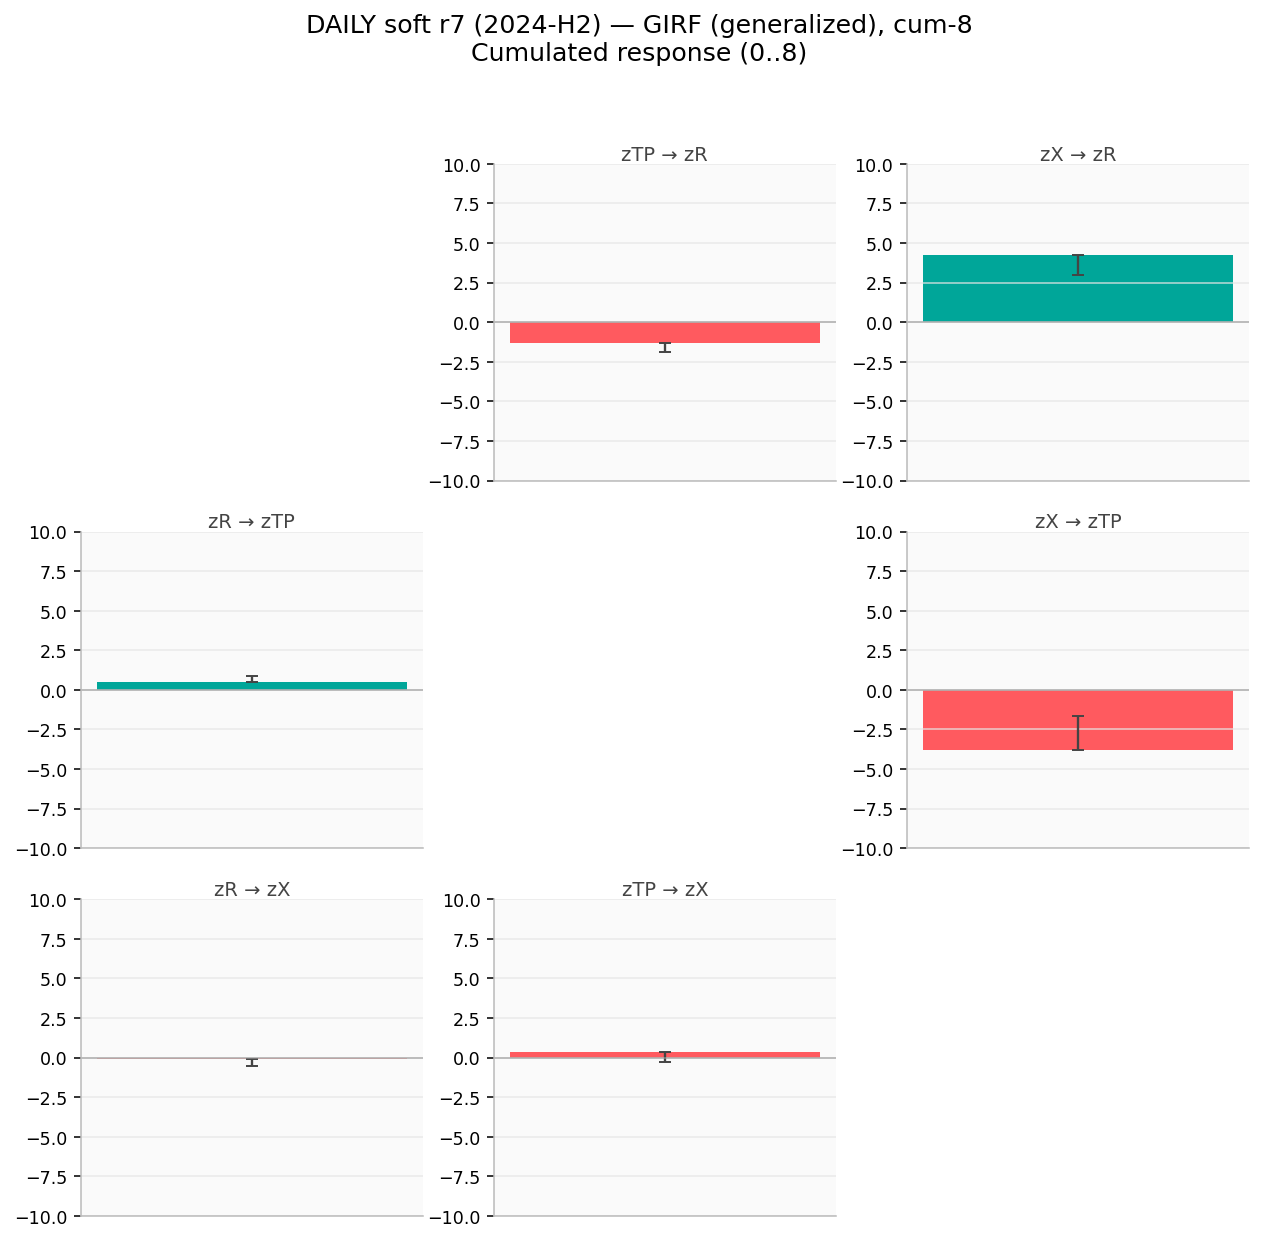

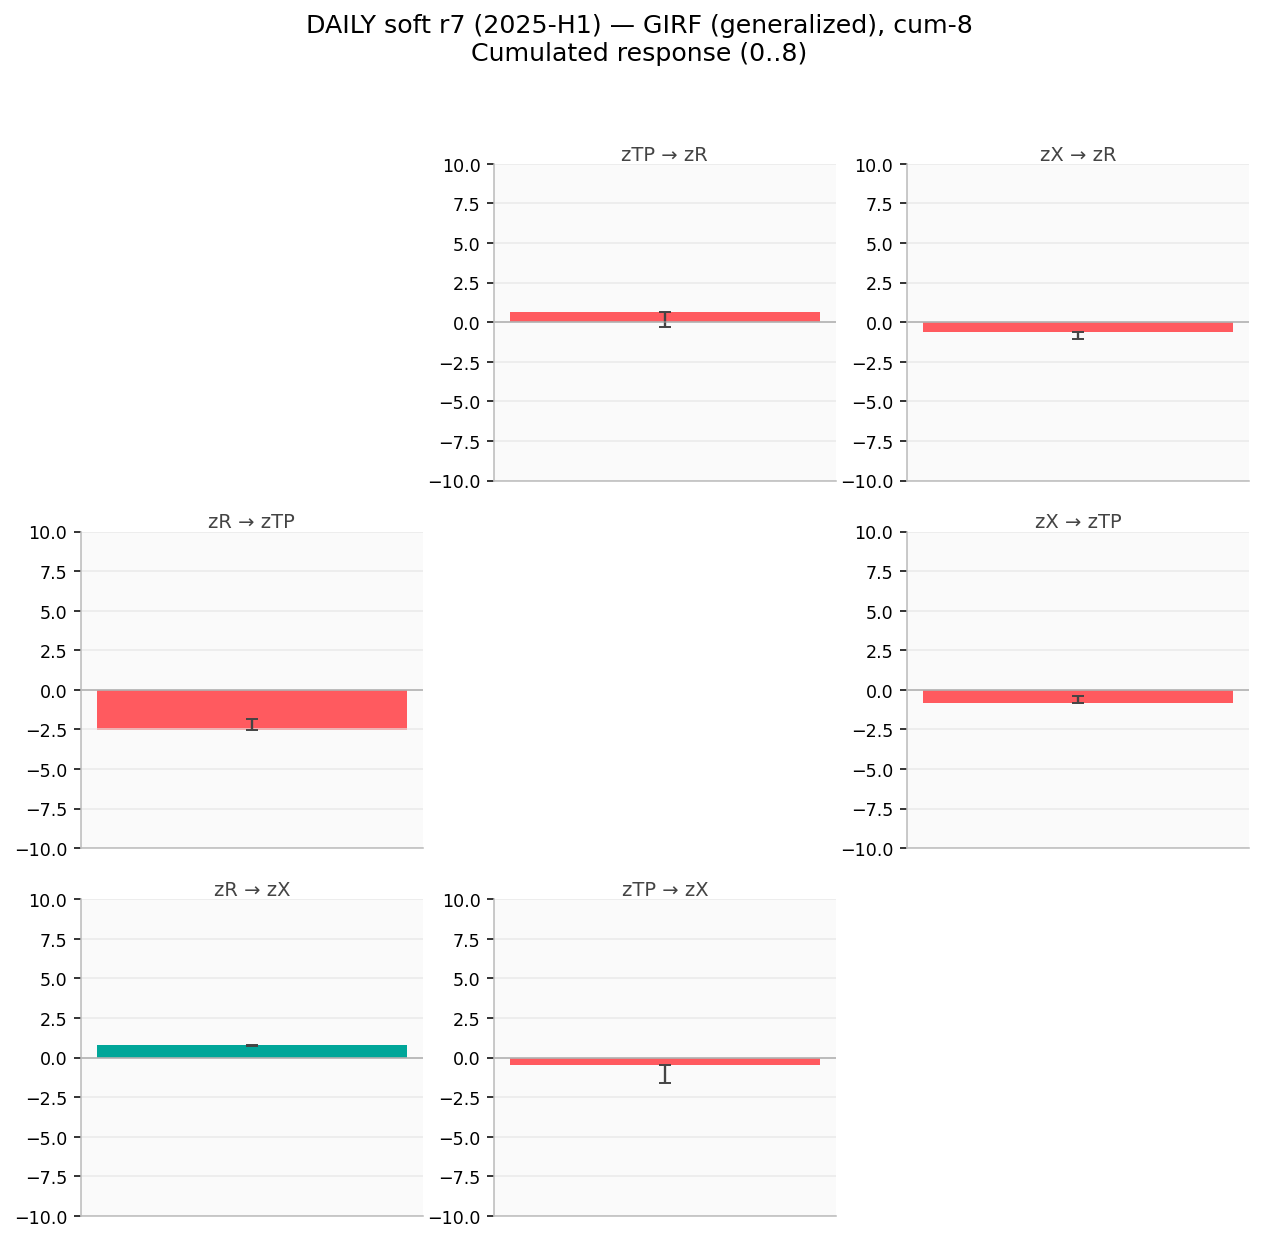

In [ ]:
SPILLOVERS_ROOT = Path("artifacts/event_only/spillovers")

def _ensure_path(filename: str, prefer_dir: Path) -> Path:
    p = prefer_dir / filename
    if p.exists():
        return p
    # fallback: search under top-level "artifacts"
    top = Path("artifacts")
    if top.exists():
        for cand in top.rglob(filename):
            print(f"[info] Using discovered file: {cand}")
            return cand
    raise FileNotFoundError(f"Could not find {filename}. Looked under {prefer_dir}/ and artifacts/**")

WEEKLY_SOFT_R4 = _ensure_path("sentiment_weekly_soft_r4.csv", SPILLOVERS_ROOT)
DAILY_SOFT_R7  = _ensure_path("sentiment_daily_soft_r7.csv",  SPILLOVERS_ROOT)

SAVE_DIR = SPILLOVERS_ROOT / "irf_fevd"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

ORDER  = ["Reddit","Trustpilot","X (Twitter)"]
NAMES  = ["zR","zTP","zX"]

AIRBNB = {
    "rausch": "#FF5A5F",  # strong negative
    "arches": "#FC642D",  # mid (CI crosses 0)
    "babu":   "#00A699",  # strong positive
    "foggy":  "#767676",  # neutral text
}

# ---- GIRF plotting defaults
GIRF_YMODE = "fixed"   # "fixed" or "auto"
GIRF_YLIM  = 10        # used when y_mode="fixed"
GIRF_PAD   = 1.15      # multiplicative padding for y_mode="auto"

def _select_lag(Y: pd.DataFrame, cap=8) -> int:
    maxlags = min(cap, max(1, len(Y)//6))
    while maxlags >= 1:
        try:
            sel = VAR(Y).select_order(maxlags=maxlags)
            p = int(sel.aic) if sel.aic is not None else 1
            return max(1, min(p, maxlags))
        except Exception:
            maxlags -= 1
    return 1

def _prep_wide(csv_path: Path, date_col: str, value_col: str, start=None, end=None) -> pd.DataFrame:
    df = pd.read_csv(csv_path, parse_dates=[date_col])
    if start is not None: df = df[df[date_col] >= pd.to_datetime(start)]
    if end   is not None: df = df[df[date_col] <= pd.to_datetime(end)]
    wide = df.pivot(index=date_col, columns="source", values=value_col).sort_index()
    cols = [c for c in ORDER if c in wide.columns]
    Y = wide[cols].dropna().copy()
    Y.columns = NAMES[:len(cols)]
    return Y

def girf_with_bands(res, H=8, repl=1000, seed=123, generalized=True):
    want_nonorth = bool(generalized)
    try:
        irf_obj = res.irf(H, orth=(not want_nonorth))
    except TypeError:
        irf_obj = res.irf(H)
    g = irf_obj.irfs
    try:
        lo, hi = res.irf_errband_mc(repl=repl, orth=(not want_nonorth), seed=seed)
    except TypeError:
        try:
            lo, hi = res.irf_errband_mc(repl=repl, seed=seed)
        except TypeError:
            lo, hi = res.irf_errband_mc(repl=repl)
    return g, lo, hi

def cum_along_h(arr):
    return arr.cumsum(axis=0)

def fig_to_png_bytes(fig):
    import io
    bio = io.BytesIO()
    fig.savefig(bio, format="png", bbox_inches="tight", dpi=160)
    return bio.getvalue()

def bar_grid_cum8(
    girf_cum, lo_cum, hi_cum, names, title,
    outdir=None, y_mode=GIRF_YMODE, y_lim=GIRF_YLIM, pad=GIRF_PAD
):

    H = girf_cum.shape[0] - 1
    k = girf_cum.shape[1]

    fig, axes = plt.subplots(k, k, figsize=(9, 9), dpi=140)

    for ax in axes.ravel():
        ax.set_facecolor("#FAFAFA")
        ax.grid(True, axis="y", color="#E6E6E6", lw=0.8, alpha=0.8)
        ax.spines["left"].set_color("#BBBBBB")
        ax.spines["bottom"].set_color("#BBBBBB")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

    for i in range(k):
        for j in range(k):
            ax = axes[i, j]
            if i == j:
                ax.axis("off")
                continue

            val = float(girf_cum[H, i, j])
            lo  = float(lo_cum[H, i, j])
            hi  = float(hi_cum[H, i, j])

            if lo > 0:
                color = AIRBNB["babu"]
            elif hi < 0:
                color = AIRBNB["rausch"]
            else:
                color = AIRBNB["arches"]

            err_low  = max(0.0, val - lo)
            err_high = max(0.0, hi - val)
            yerr = np.array([[err_low], [err_high]])
            errkw = dict(elinewidth=1.2, capsize=3, ecolor="#444")

            ax.bar([0], [val], width=0.55, color=color, edgecolor="none",
                   yerr=yerr, error_kw=errkw)
            ax.axhline(0, color="#999999", lw=1.0, alpha=0.6)

            # y-limits
            if y_mode == "fixed":
                ax.set_ylim(-abs(y_lim), abs(y_lim))
            else:
                m = max(abs(val), abs(lo), abs(hi), 1e-6)
                lim = max(pad * m, 0.05)
                ax.set_ylim(-lim, lim)

            ax.set_xticks([])
            ax.tick_params(axis="y", labelsize=9)
            ax.set_title(f"{names[j]} → {names[i]}", fontsize=10, fontweight=400, color="#444", pad=2)

    fig.suptitle(f"{title}\nCumulated response (0..8)", y=0.98, fontsize=13, fontweight=400)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    if outdir:
        outdir.mkdir(parents=True, exist_ok=True)
        (outdir / f"{title.replace(' ','_').replace('/','-')}_cum8.png").write_bytes(fig_to_png_bytes(fig))
    return fig

def fevd_tables(res, steps=(4, 8), names=None):
    if names is None:
        names = list(res.names)
    Hmax = max(steps)

    fe = res.fevd(Hmax)
    dec = getattr(fe, "decomp", None)

    def _frame(arr2d):
        return pd.DataFrame(np.asarray(arr2d), index=names, columns=names)

    if callable(dec):
        def get(h): return _frame(dec(h))
    else:
        D = None if dec is None else np.asarray(dec)
        if D is None or D.ndim != 3:
            if hasattr(fe, "decomp"):
                def get(h): return _frame(fe.decomp(h))
            else:
                raise RuntimeError("FEVD format not recognized.")
        else:
            cand = [ax for ax, s in enumerate(D.shape) if s >= Hmax and s != len(names)]
            if not cand:
                cand = [ax for ax, s in enumerate(D.shape) if s >= Hmax]
            if not cand:
                raise ValueError(f"Unexpected FEVD shape: {D.shape}")
            step_axis = cand[0]
            if step_axis == 0:
                def get(h): return _frame(D[h-1, :, :])
            elif step_axis == 1:
                def get(h): return _frame(D[:, h-1, :])
            elif step_axis == 2:
                def get(h): return _frame(D[:, :, h-1])
            else:
                raise ValueError(f"Unexpected FEVD shape: {D.shape}")

    tables = {h: (get(h) * 100.0).round(1) for h in steps}
    return tables

def run_irf_and_fevd(csv_path, date_col, value_col, tag,
                     start=None, end=None, cap=8, H=8, repl=1200, seed=123,
                     y_mode=GIRF_YMODE, y_lim=GIRF_YLIM, pad=GIRF_PAD):
    Y = _prep_wide(csv_path, date_col, value_col, start, end)
    if Y.shape[1] < 2:
        print(f"{tag}: need >=2 series; got {Y.shape[1]}")
        return None

    p   = _select_lag(Y, cap=cap)
    res = VAR(Y).fit(p)
    print(f"{tag}: fitted VAR(p={p}), n={res.nobs}, sample={Y.index.min().date()}…{Y.index.max().date()}")

    g, lo, hi = girf_with_bands(res, H=H, repl=repl, seed=seed)
    bar_grid_cum8(
        cum_along_h(g), cum_along_h(lo), cum_along_h(hi),
        list(res.names),
        f"{tag} — GIRF (generalized), cum-8",
        outdir=SAVE_DIR,
        y_mode=y_mode, y_lim=y_lim, pad=pad
    )

    tables = fevd_tables(res, steps=(4, 8), names=list(res.names))
    return {"tag": tag, "fevd": tables, "names": list(res.names)}

def combine_and_save_fevd(run_outputs, outfile_base="FEVD_all"):
    tidy_rows = []
    wide_blocks = []

    for r in run_outputs:
        if r is None:
            continue
        tag   = r["tag"]
        names = r["names"]
        fevd  = r["fevd"]  # {4: df, 8: df}

        for h, df in fevd.items():
            # tidy
            T = df.reset_index().melt(id_vars="index", var_name="shock", value_name="share")
            T = T.rename(columns={"index": "row"})
            T["tag"] = tag
            T["h"]   = h
            tidy_rows.append(T[["tag","h","row","shock","share"]])

            # wide (block)
            W = df.copy()
            W.index = pd.MultiIndex.from_product([(tag,), (h,), W.index], names=["tag","h","row"])
            wide_blocks.append(W)

    tidy = pd.concat(tidy_rows, ignore_index=True).sort_values(["tag","h","row","shock"])
    wide = pd.concat(wide_blocks).sort_index()

    tidy_path = SAVE_DIR / f"{outfile_base}_tidy.csv"
    wide_path = SAVE_DIR / f"{outfile_base}_wide.csv"
    tidy.to_csv(tidy_path, index=False)
    wide.to_csv(wide_path)

    print(f"\nSaved FEVD tables:")
    print(f"  • tidy  -> {tidy_path}")
    print(f"  • wide  -> {wide_path}")

    return tidy, wide

runs = []

# Weekly soft r4
runs.append(run_irf_and_fevd(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4",
                             "WEEKLY soft r4 (Full)",    H=8, cap=8,
                             y_mode=GIRF_YMODE, y_lim=GIRF_YLIM, pad=GIRF_PAD))
runs.append(run_irf_and_fevd(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4",
                             "WEEKLY soft r4 (2024-H2)", H=8, cap=8,
                             start="2024-07-01", end="2024-12-31",
                             y_mode=GIRF_YMODE, y_lim=GIRF_YLIM, pad=GIRF_PAD))
runs.append(run_irf_and_fevd(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4",
                             "WEEKLY soft r4 (2025-H1)", H=8, cap=8,
                             start="2025-01-01", end="2025-06-30",
                             y_mode=GIRF_YMODE, y_lim=GIRF_YLIM, pad=GIRF_PAD))

# Daily soft r7
runs.append(run_irf_and_fevd(DAILY_SOFT_R7, "date", "sent_z_soft_r7",
                             "DAILY soft r7 (Full)",     H=8, cap=8,
                             y_mode=GIRF_YMODE, y_lim=GIRF_YLIM, pad=GIRF_PAD))
runs.append(run_irf_and_fevd(DAILY_SOFT_R7, "date", "sent_z_soft_r7",
                             "DAILY soft r7 (2024-H2)",  H=8, cap=8,
                             start="2024-07-01", end="2024-12-31",
                             y_mode=GIRF_YMODE, y_lim=GIRF_YLIM, pad=GIRF_PAD))
runs.append(run_irf_and_fevd(DAILY_SOFT_R7, "date", "sent_z_soft_r7",
                             "DAILY soft r7 (2025-H1)",  H=8, cap=8,
                             start="2025-01-01", end="2025-06-30",
                             y_mode=GIRF_YMODE, y_lim=GIRF_YLIM, pad=GIRF_PAD))

tidy_fevd, wide_fevd = combine_and_save_fevd(runs, outfile_base="FEVD_all")

In [ ]:
import statsmodels.api as sm
from matplotlib.colors import ListedColormap, BoundaryNorm

WEEKLY_SOFT_R4 = ARTIFACTS / "sentiment_weekly_soft_r4.csv"
DAILY_SOFT_R7  = ARTIFACTS / "sentiment_daily_soft_r7.csv"
OUTDIR         = ARTIFACTS / "asymmetry_h3"
OUTDIR.mkdir(parents=True, exist_ok=True)

ORDER = ["Reddit","Trustpilot","X (Twitter)"]
NAMES = ["zR","zTP","zX"]

# Airbnb colors
AIRBNB = {"rausch":"#FF5A5F","arches":"#FC642D","babu":"#00A699","ns":"#EAEAEA"}
cmap  = ListedColormap([AIRBNB["rausch"], AIRBNB["arches"], AIRBNB["babu"], AIRBNB["ns"]])
bounds = [0.0, 0.01, 0.05, 0.10, 1.0]
norm   = BoundaryNorm(bounds, cmap.N)

def _select_lag(Y, cap=8):
    maxlags = min(cap, max(1, len(Y)//6))
    while maxlags >= 1:
        try:
            sel = VAR(Y).select_order(maxlags=maxlags)
            p = int(sel.aic) if sel.aic is not None else 1
            return max(1, min(p, maxlags))
        except Exception:
            maxlags -= 1
    return 1

def _prep_wide(csv_path: Path, date_col: str, value_col: str, start=None, end=None):
    df = pd.read_csv(csv_path, parse_dates=[date_col])
    if start is not None: df = df[df[date_col] >= pd.to_datetime(start)]
    if end   is not None: df = df[df[date_col] <= pd.to_datetime(end)]
    wide = (df.pivot(index=date_col, columns="source", values=value_col)
              .sort_index())
    cols = [c for c in ORDER if c in wide.columns]
    Y = wide[cols].dropna().copy()
    Y.columns = NAMES[:len(cols)]
    return Y

def _make_lp_frame(Y: pd.DataFrame, p: int, H: int):
    T, k = Y.shape
    df = Y.copy()
    for L in range(1, p+1):
        dlag = Y.shift(L)
        dlag.columns = [f"{c}_L{L}" for c in Y.columns]
        df = pd.concat([df, dlag], axis=1)
    for h in range(0, H+1):
        lead = Y.shift(-h)
        lead.columns = [f"{c}_F{h}" for c in Y.columns]
        df = pd.concat([df, lead], axis=1)
    df["t"] = np.arange(T)
    return df

def _bootstrap_indices(n, L=4, B=600, seed=123):
    rng = np.random.default_rng(seed)
    all_idx = []
    nblocks = int(np.ceil(n / L))
    for b in range(B):
        starts = rng.integers(0, n, size=nblocks)
        idx = []
        for s in starts:
            idx.extend((s + np.arange(L)) % n)
        all_idx.append(np.array(idx[:n], dtype=int))
    return all_idx

def asymmetry_lp(Y: pd.DataFrame, H=8, cap=8, B=600, seed=123):
    k = Y.shape[1]
    p = _select_lag(Y, cap=cap)
    res = VAR(Y).fit(p)

    Yfull = pd.DataFrame(res.model.endog, columns=Y.columns)
    U = pd.DataFrame(res.resid, columns=Y.columns)
    sigma = U.std(ddof=1).values
    U_std = U.values / sigma
    DF = _make_lp_frame(Yfull, p=p, H=H)

    T = len(Yfull)
    base = DF[(DF["t"] >= p) & (DF["t"] <= T-1-H)].copy()
    pad = pd.DataFrame(np.full((p, k), np.nan), columns=[f"u_{c}" for c in Y.columns])
    U_df = pd.DataFrame(U_std, columns=[f"u_{c}" for c in Y.columns])
    U_aligned = pd.concat([pad, U_df], axis=0).reset_index(drop=True)
    base = pd.concat([base.reset_index(drop=True), U_aligned.reset_index(drop=True)], axis=1)

    # positive/negative parts (magnitudes)
    for j, name in enumerate(Y.columns):
        u = base[f"u_{name}"].to_numpy()
        base[f"{name}_POS"] = np.where(u>0,  u, 0.0)
        base[f"{name}_NEG"] = np.where(u<0, -u, 0.0)

    lag_cols = [c for c in base.columns if c.endswith(tuple([f"_L{L}" for L in range(1, p+1)]))]
    Xlags = sm.add_constant(base[lag_cols].to_numpy())

    n = len(base)
    idx_boot = _bootstrap_indices(n, L=max(4, p+1), B=B, seed=seed)

    # Storage
    pvals = np.ones((k, k))

    for i, resp in enumerate(Y.columns):
        YF = np.stack([base[f"{resp}_F{h}"].to_numpy() for h in range(0, H+1)], axis=0)

        for j, sh in enumerate(Y.columns):
            u_pos = base[f"{sh}_POS"].to_numpy()
            u_neg = base[f"{sh}_NEG"].to_numpy()

            # estimate betas at each horizon
            beta_pos = np.zeros(H+1)
            beta_neg = np.zeros(H+1)

            for h in range(0, H+1):
                y = YF[h]
                X = np.column_stack([Xlags, u_pos, u_neg])
                fit = sm.OLS(y, X, missing="drop").fit()
                beta_pos[h] = fit.params[-2]
                beta_neg[h] = fit.params[-1]

            # cum-8 sums
            cum_pos = beta_pos.sum()
            cum_neg = beta_neg.sum()

            d_obs = cum_pos - (-cum_neg)

            d_boot = np.empty(B)
            for b, idx in enumerate(idx_boot):
                Xb = Xlags[idx]
                up = u_pos[idx]
                un = u_neg[idx]
                db_sum_pos = 0.0
                db_sum_neg = 0.0
                for h in range(0, H+1):
                    yb = YF[h][idx]
                    Xb_full = np.column_stack([Xb, up, un])
                    fitb = sm.OLS(yb, Xb_full, missing="drop").fit()
                    db_sum_pos += fitb.params[-2]
                    db_sum_neg += fitb.params[-1]
                d_boot[b] = db_sum_pos - (-db_sum_neg)

            pvals[i, j] = np.mean(np.abs(d_boot) >= np.abs(d_obs))

    P = pd.DataFrame(pvals, index=Y.columns, columns=Y.columns)
    return res, P

def heatmap_airbnb(P: pd.DataFrame, title: str, save_png=True, save_csv=True):
    mat = P.copy()
    fig, ax = plt.subplots(figsize=(6.4, 5.0), dpi=150)
    im = ax.imshow(mat.values, cmap=cmap, norm=norm)
    ax.set_xticks(range(mat.shape[1])); ax.set_xticklabels(mat.columns, fontsize=11)
    ax.set_yticks(range(mat.shape[0])); ax.set_yticklabels(mat.index, fontsize=11)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if i==j: continue
            v = mat.iat[i, j]
            ax.text(j, i, f"{v:.3f}", ha="center", va="center", color="#333333", fontsize=10)
    ax.set_title(title, fontsize=13, pad=8, fontweight=600)
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=[0.005, 0.03, 0.075, 0.5])
    cbar.ax.set_yticklabels(["< .01", ".01–.05", ".05–.10", "≥ .10"])
    cbar.set_label("p-value bands")
    ax.set_aspect("equal")
    for spine in ax.spines.values(): spine.set_visible(False)
    plt.tight_layout()

    stem = title.replace(" ", "_").replace("/", "-")
    if save_png:
        fig.savefig(OUTDIR / f"asymmetry_{stem}.png", dpi=200, bbox_inches="tight")
    if save_csv:
        mat.to_csv(OUTDIR / f"asymmetry_{stem}.csv")
    plt.show()
    return mat

def run_h3(csv_path, date_col, value_col, title, start=None, end=None, H=8, cap=8, B=600, seed=123):
    Y = _prep_wide(csv_path, date_col, value_col, start, end)
    res, P = asymmetry_lp(Y, H=H, cap=cap, B=B, seed=seed)
    print(f"{title}: VAR(p={res.k_ar}), n={res.nobs}, sample={Y.index.min().date()}…{Y.index.max().date()}")
    return heatmap_airbnb(P, f"{title} — H3 (asymmetry, cum-8)")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


WEEKLY soft r4 (Full): VAR(p=8), n=45, sample=2024-07-01…2025-06-30


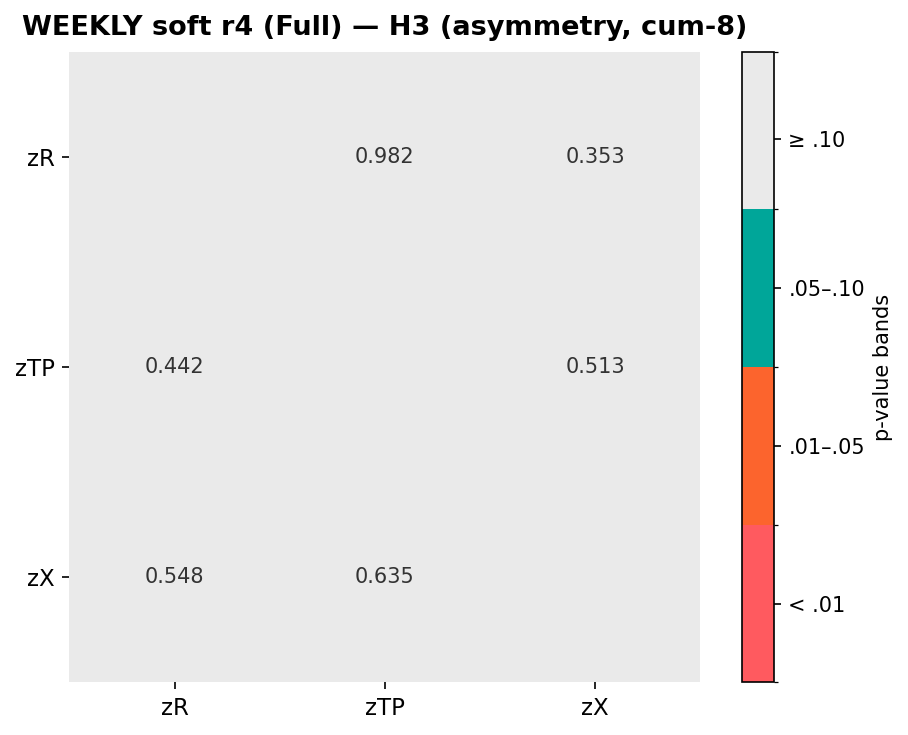

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


WEEKLY soft r4 (2024-H2): VAR(p=2), n=25, sample=2024-07-01…2024-12-30


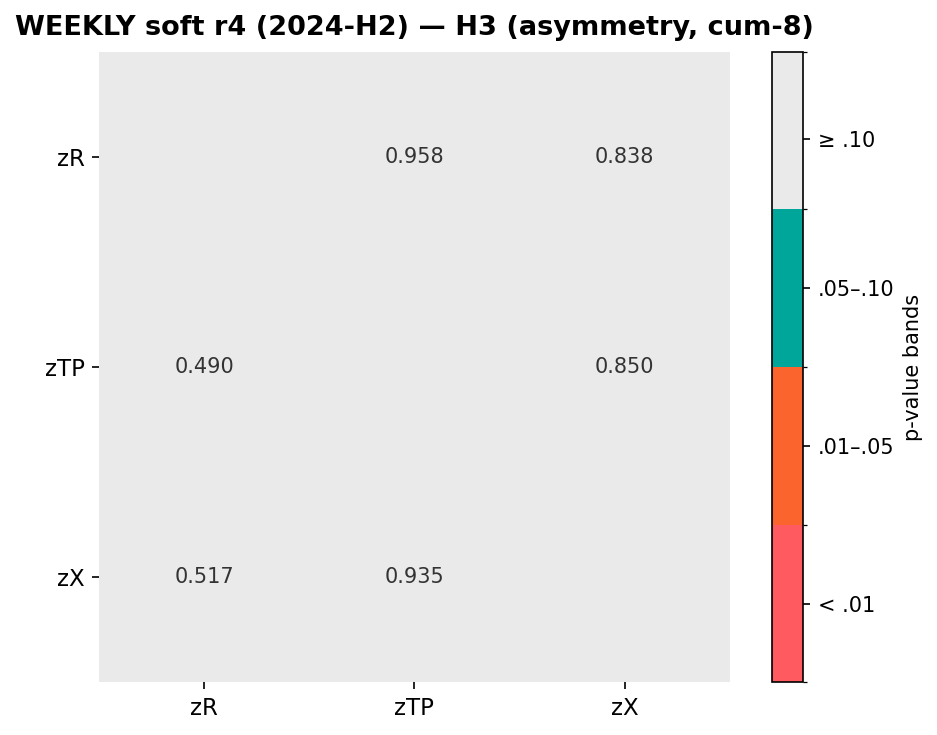

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


WEEKLY soft r4 (2025-H1): VAR(p=2), n=24, sample=2025-01-06…2025-06-30


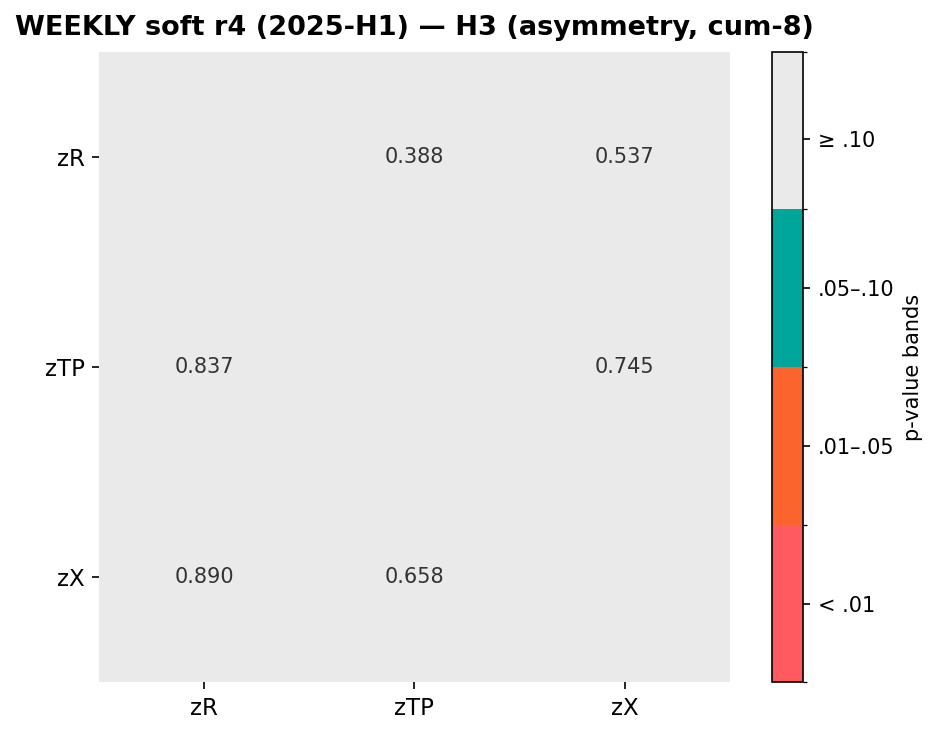

zR       zTP        zX
zR   0.871667  0.388333  0.536667
zTP  0.836667  0.540000  0.745000
zX   0.890000  0.658333  0.416667

In [ ]:
# Weekly soft r4
run_h3(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4", "WEEKLY soft r4 (Full)")
run_h3(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4", "WEEKLY soft r4 (2024-H2)",
       start="2024-07-01", end="2024-12-31")
run_h3(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4", "WEEKLY soft r4 (2025-H1)",
       start="2025-01-01", end="2025-06-30")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


DAILY soft r7 (Full): VAR(p=8), n=357, sample=2024-07-01…2025-06-30


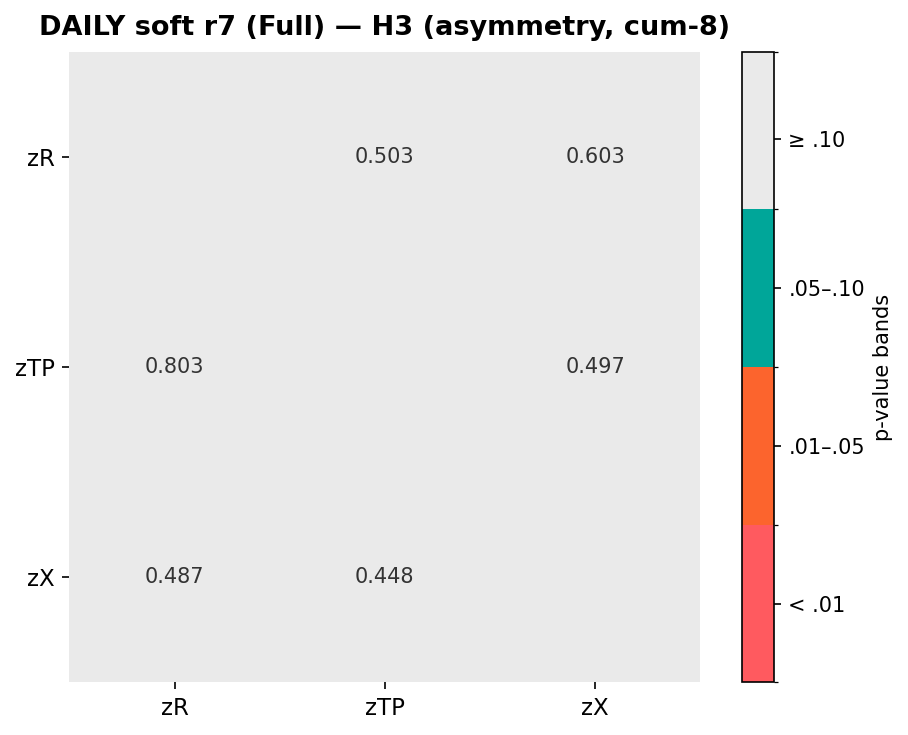

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


DAILY soft r7 (2024-H2): VAR(p=8), n=176, sample=2024-07-01…2024-12-31


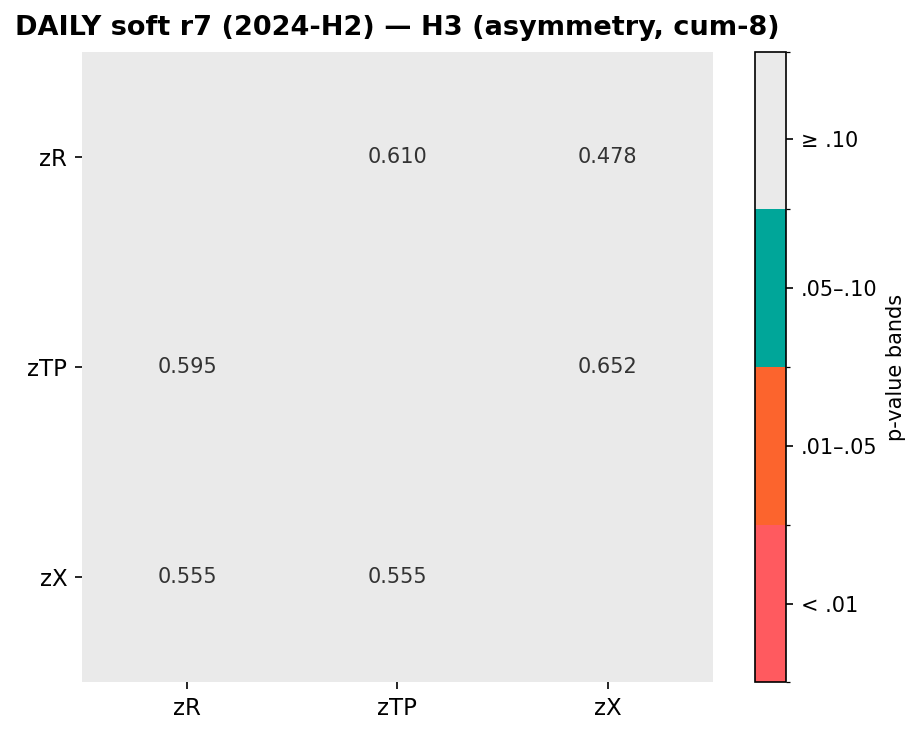

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


DAILY soft r7 (2025-H1): VAR(p=8), n=173, sample=2025-01-01…2025-06-30


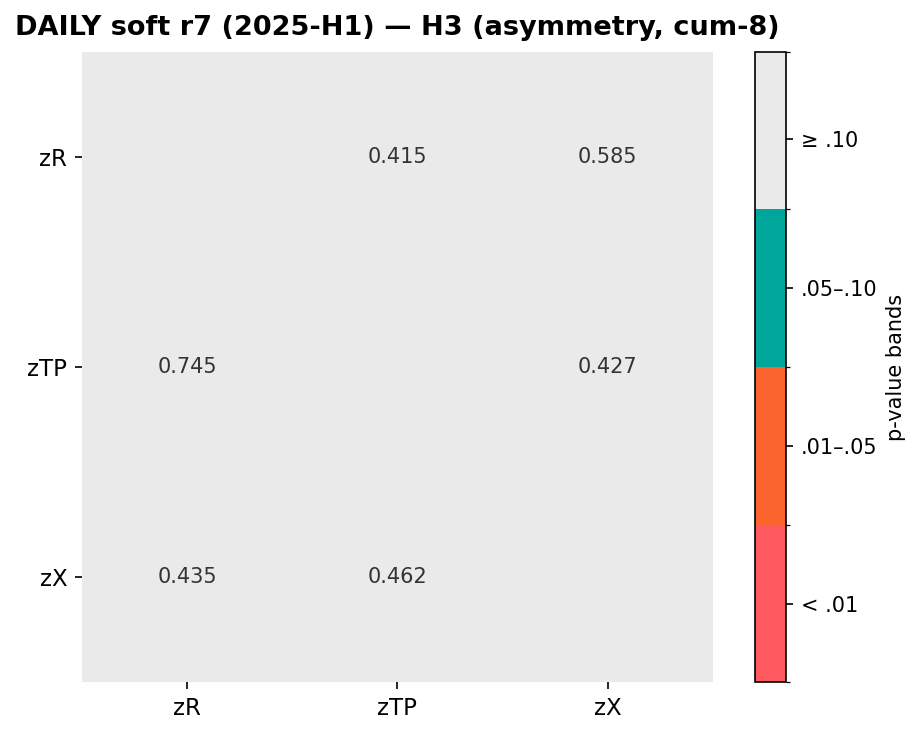

zR       zTP        zX
zR   0.411667  0.415000  0.585000
zTP  0.745000  0.458333  0.426667
zX   0.435000  0.461667  0.405000

In [ ]:
# Daily soft r7
run_h3(DAILY_SOFT_R7, "date", "sent_z_soft_r7", "DAILY soft r7 (Full)")
run_h3(DAILY_SOFT_R7, "date", "sent_z_soft_r7", "DAILY soft r7 (2024-H2)",
       start="2024-07-01", end="2024-12-31")
run_h3(DAILY_SOFT_R7, "date", "sent_z_soft_r7", "DAILY soft r7 (2025-H1)",
       start="2025-01-01", end="2025-06-30")

In [ ]:
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2

ARTIFACTS = Path("artifacts/event_only/spillovers")
if not ARTIFACTS.exists():
    ARTIFACTS = Path("spillovers")

WEEKLY_SOFT_R4 = ARTIFACTS / "sentiment_weekly_soft_r4.csv"
DAILY_SOFT_R7  = ARTIFACTS / "sentiment_daily_soft_r7.csv"

OUTDIR = ARTIFACTS / "irf_fevd"
OUTDIR.mkdir(parents=True, exist_ok=True)

airbnb_cmap   = ListedColormap([AIRBNB["rausch"], AIRBNB["arches"], AIRBNB["babu"], AIRBNB["ns"]])
airbnb_bounds = [0.0, 0.01, 0.05, 0.10, 1.0]
airbnb_norm   = BoundaryNorm(airbnb_bounds, airbnb_cmap.N)

def _select_lag(Y: pd.DataFrame, cap=8) -> int:
    maxlags = min(cap, max(1, len(Y)//6))
    while maxlags >= 1:
        try:
            sel = sm.tsa.VAR(Y).select_order(maxlags=maxlags)
            p = int(sel.aic) if sel.aic is not None else 1
            return max(1, min(p, maxlags))
        except Exception:
            maxlags -= 1
    return 1

def _prep_wide(csv_path: Path, date_col: str, value_col: str,
               start=None, end=None) -> pd.DataFrame:
    df = pd.read_csv(csv_path, parse_dates=[date_col])
    if start is not None:
        df = df[df[date_col] >= pd.to_datetime(start)]
    if end is not None:
        df = df[df[date_col] <= pd.to_datetime(end)]
    wide = (df.pivot(index=date_col, columns="source", values=value_col)
              .sort_index())
    cols = [c for c in ORDER if c in wide.columns]
    Y = wide[cols].dropna().copy()
    Y.columns = NAMES[:len(cols)]
    return Y

def lp_asymmetry(Y: pd.DataFrame, H=8, cap=8) -> pd.DataFrame:
    k = Y.shape[1]
    p = _select_lag(Y, cap=cap)
    res = sm.tsa.VAR(Y).fit(p)

    U = pd.DataFrame(res.resid, index=Y.index[p:], columns=Y.columns)

    lagged = {}
    for L in range(1, p+1):
        lagged[L] = Y.shift(L)
    Xlags = pd.concat([lagged[L] for L in range(1, p+1)], axis=1)
    Xlags.columns = [f"{c}_L{L}" for L in range(1, p+1) for c in Y.columns]
    Xlags = Xlags.loc[U.index]

    # Storage for Fisher p-values
    fisher_mat = pd.DataFrame(np.nan, index=Y.columns, columns=Y.columns)

    for i, yi in enumerate(Y.columns):         # response
        for j, yj in enumerate(Y.columns):     # shock source
            if i == j:
                continue

            pvals_h = []

            for h in range(0, H+1):
                y_fwd = Y[yi].shift(-h).loc[U.index]

                uj = U[yj]
                x_plus = (uj * (uj > 0)).rename(f"{yj}_plus")
                x_minus = (uj * (uj < 0)).rename(f"{yj}_minus")

                X = pd.concat([x_plus, x_minus, Xlags], axis=1)
                df = pd.concat([y_fwd.rename(yi), X], axis=1).dropna()
                if len(df) < (10 + 2*k):
                    continue

                Yh = df[yi].to_numpy()
                Xh = add_constant(df.drop(columns=[yi]).to_numpy())
                model = sm.OLS(Yh, Xh)
                res_h = model.fit(cov_type="HAC", cov_kwds={"maxlags": max(1, h+1)})

                R = np.zeros((1, Xh.shape[1]))
                R[0, 1] = 1.0   # plus
                R[0, 2] = -1.0  # minus
                w = res_h.wald_test(R)
                pvals_h.append(float(w.pvalue))

            pvals_h = np.array([p for p in pvals_h if np.isfinite(p) and p > 0])
            if pvals_h.size == 0:
                fisher_p = np.nan
            else:
                stat = -2.0 * np.sum(np.log(pvals_h))
                df_chi = 2 * pvals_h.size
                fisher_p = float(chi2.sf(stat, df_chi))
            fisher_mat.loc[yi, yj] = fisher_p

    return fisher_mat

def heatmap_asymmetry_airbnb(pmat: pd.DataFrame, title: str,
                             figsize=(6.6, 5.0), title_fs=10, tick_fs=11, cbar_fs=10,
                             save=True, filename=None):
    k = pmat.shape[0]
    fig, ax = plt.subplots(figsize=figsize, dpi=160)

    im = ax.imshow(pmat.to_numpy(), cmap=airbnb_cmap, norm=airbnb_norm)
    ax.set_xticks(range(k)); ax.set_xticklabels(pmat.columns, fontsize=tick_fs)
    ax.set_yticks(range(k)); ax.set_yticklabels(pmat.index, fontsize=tick_fs)

    ax.set_title(title, fontsize=title_fs, fontweight=500, pad=6)

    for r in range(k):
        for c in range(k):
            v = pmat.iat[r, c]
            if np.isfinite(v):
                ax.text(c, r, f"{v:.3f}", ha="center", va="center",
                        color="#333333", fontsize=11)

    cbar = fig.colorbar(im, ax=ax, boundaries=airbnb_bounds, ticks=[0.005, 0.03, 0.075, 0.5])
    cbar.ax.set_yticklabels(["< .01", ".01–.05", ".05–.10", "≥ .10"])
    cbar.ax.tick_params(labelsize=cbar_fs)
    cbar.set_label("joint p-value (Fisher)", fontsize=cbar_fs)

    ax.set_aspect("equal")
    for s in ax.spines.values():
        s.set_visible(False)

    fig.tight_layout()
    if save:
        if filename is None:
            filename = title.replace(" ", "_").replace("/", "-") + "_LP_asym.png"
        out = OUTDIR / filename
        plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    return fig, ax

def run_lp_asymmetry_window(csv_path: Path, date_col: str, value_col: str,
                            title: str, start=None, end=None,
                            H=8, cap=8, title_fs=10, tick_fs=11, cbar_fs=10):
    Y = _prep_wide(csv_path, date_col, value_col, start=start, end=end)
    if Y.shape[1] < 2:
        print(f"{title}: need >=2 series; got {Y.shape[1]}")
        return None
    pmat = lp_asymmetry(Y, H=H, cap=cap)
    heatmap_asymmetry_airbnb(
        pmat, f"{title} — H3 (asymmetry, cum-8)",
        title_fs=title_fs, tick_fs=tick_fs, cbar_fs=cbar_fs,
        filename=f"LP_asym_{title.replace(' ','_').replace('/','-')}.png"
    )
    return pmat

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message whi

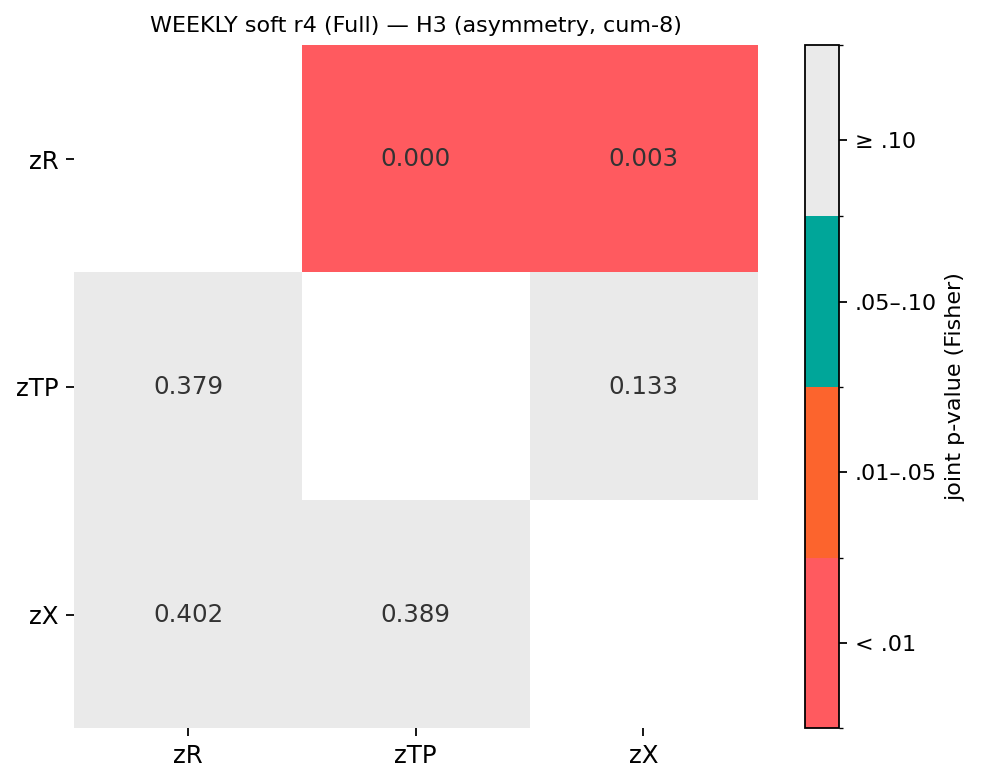

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message whi

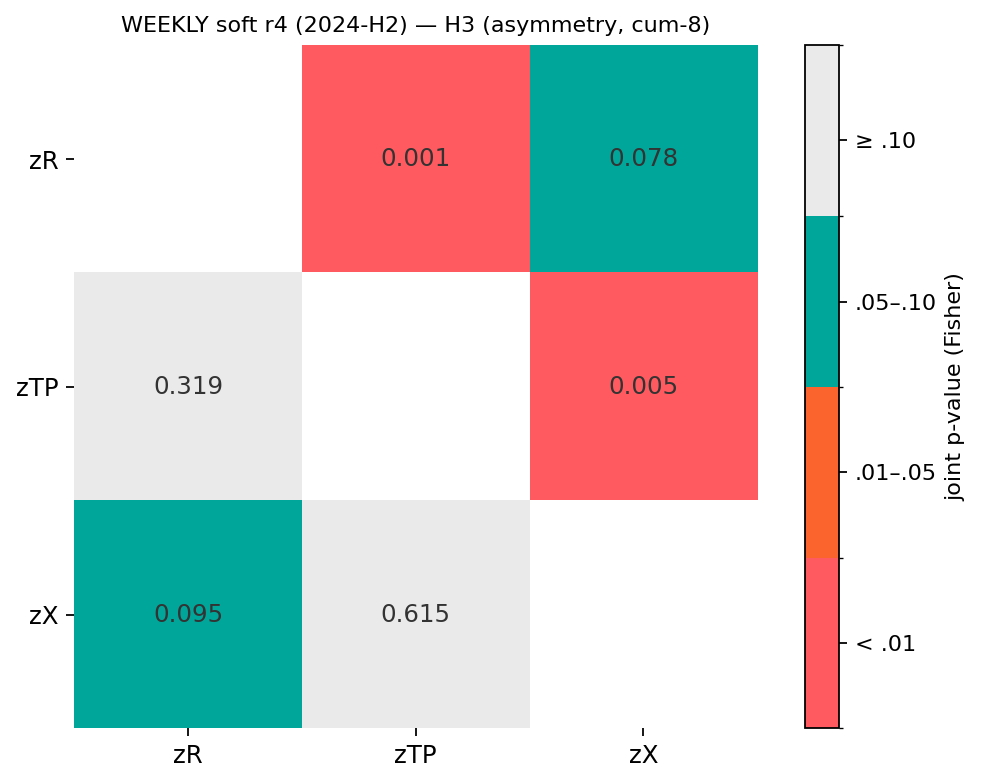

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message whi

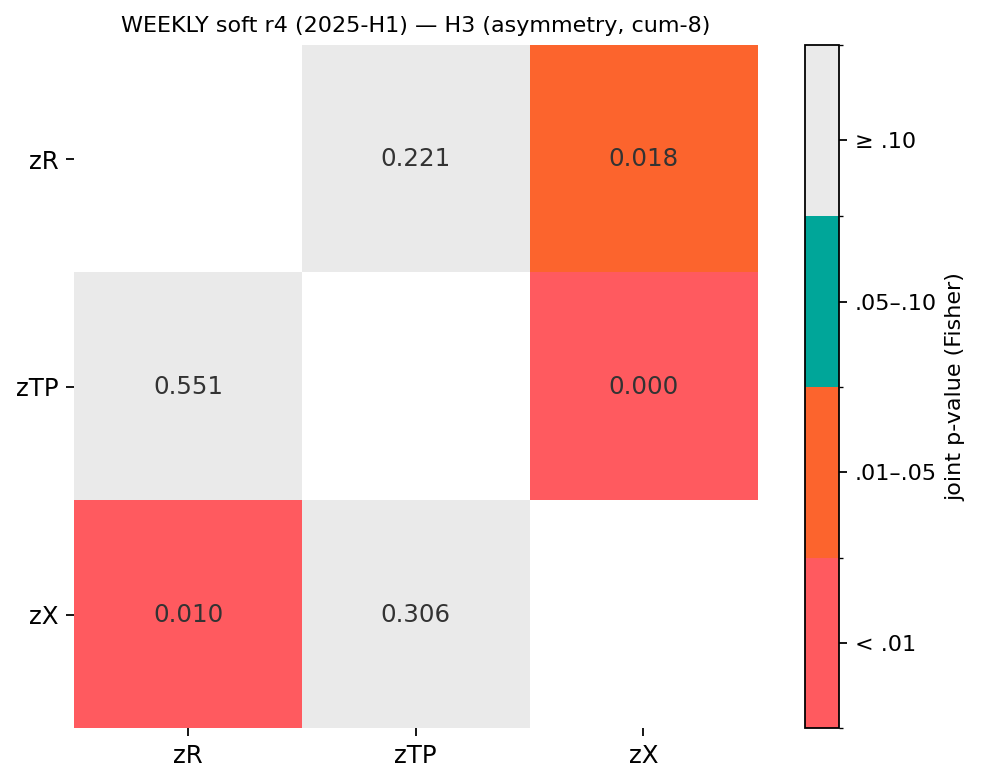

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retai

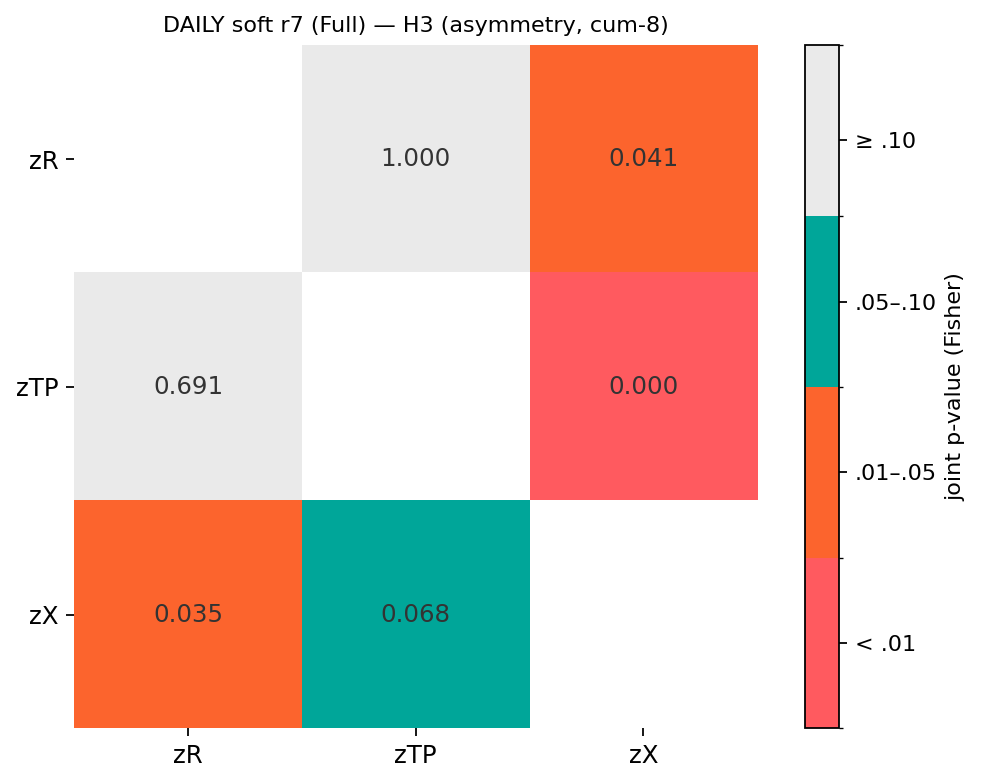

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retai

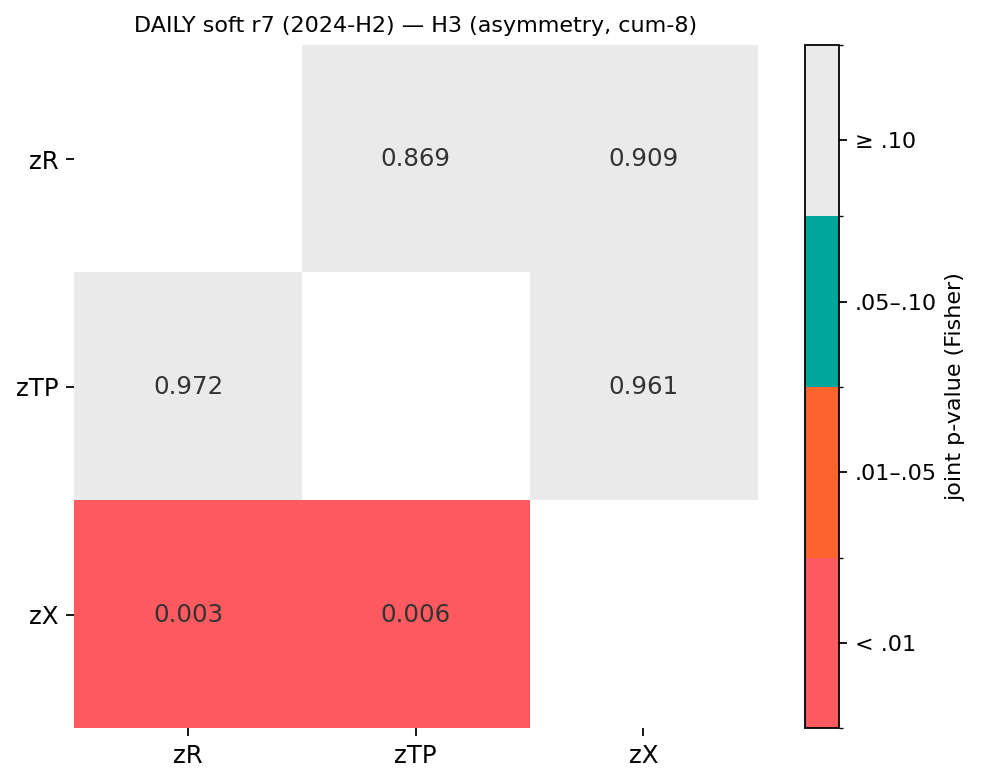

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retai

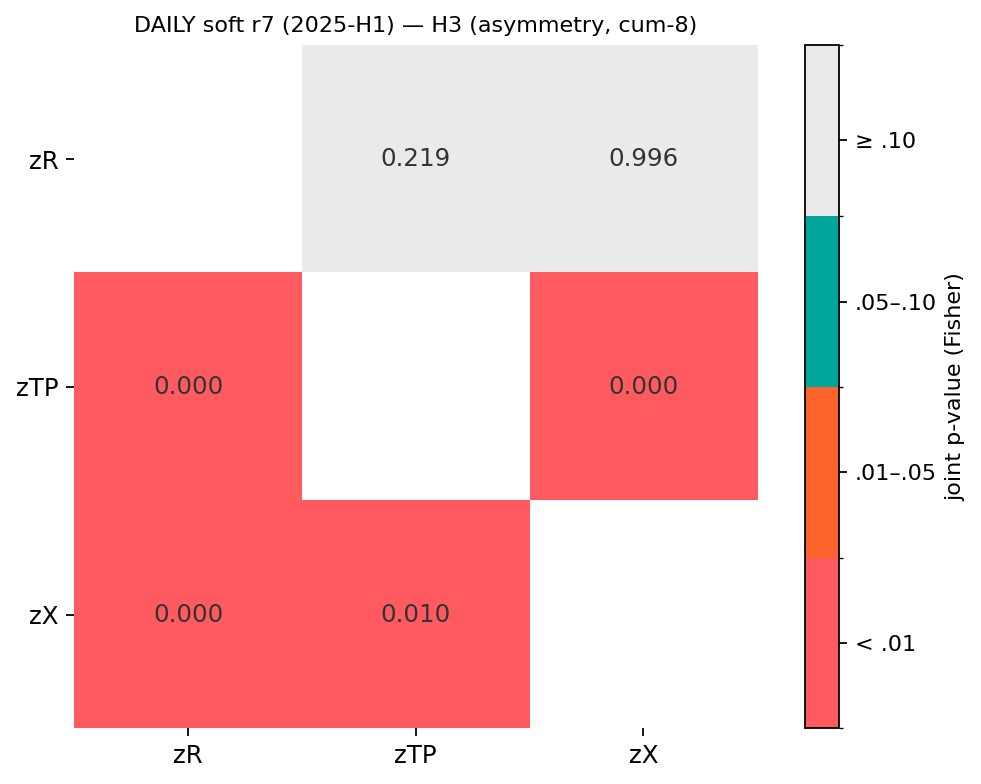

zR       zTP            zX
zR            NaN  0.219399  9.964674e-01
zTP  2.821839e-11       NaN  2.050738e-09
zX   1.249590e-04  0.009513           NaN

In [ ]:
# Weekly soft r4
run_lp_asymmetry_window(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4",
                        "WEEKLY soft r4 (Full)", H=8, cap=8, title_fs=10)
run_lp_asymmetry_window(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4",
                        "WEEKLY soft r4 (2024-H2)", start="2024-07-01", end="2024-12-31",
                        H=8, cap=8, title_fs=10)
run_lp_asymmetry_window(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4",
                        "WEEKLY soft r4 (2025-H1)", start="2025-01-01", end="2025-06-30",
                        H=8, cap=8, title_fs=10)

# Daily soft r7
run_lp_asymmetry_window(DAILY_SOFT_R7, "date", "sent_z_soft_r7",
                        "DAILY soft r7 (Full)", H=8, cap=8, title_fs=10)
run_lp_asymmetry_window(DAILY_SOFT_R7, "date", "sent_z_soft_r7",
                        "DAILY soft r7 (2024-H2)", start="2024-07-01", end="2024-12-31",
                        H=8, cap=8, title_fs=10)
run_lp_asymmetry_window(DAILY_SOFT_R7, "date", "sent_z_soft_r7",
                        "DAILY soft r7 (2025-H1)", start="2025-01-01", end="2025-06-30",
                        H=8, cap=8, title_fs=10)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


WEEKLY soft r4 (Full): LP with lag controls p=8, n=53, window=2024-07-01…2025-06-30


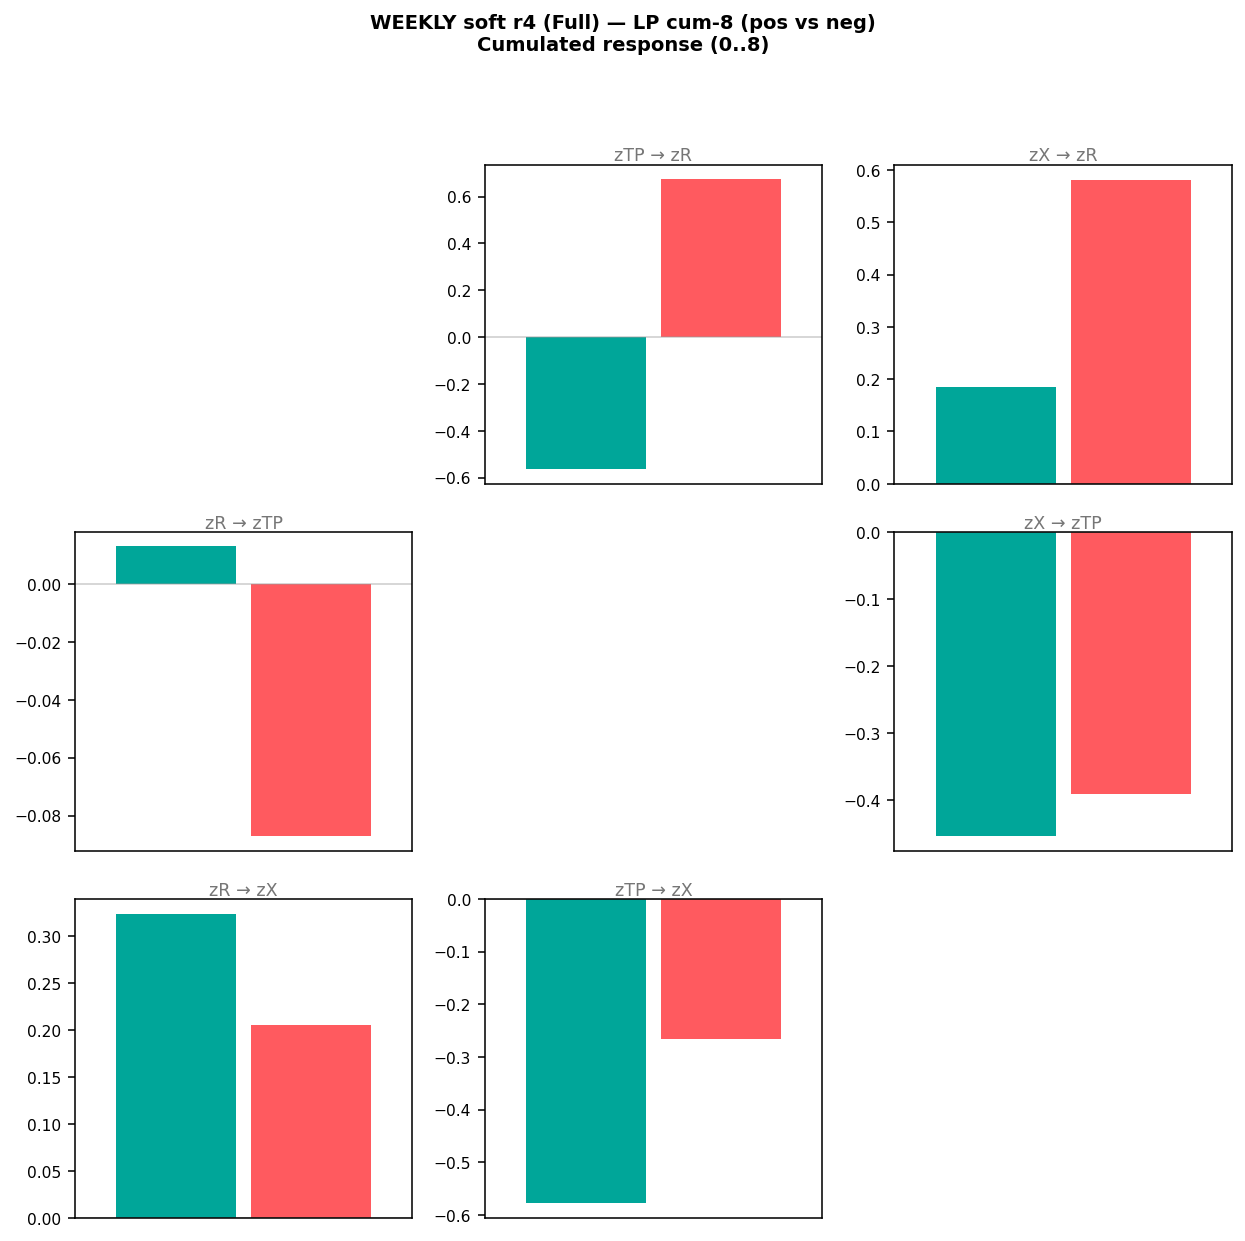

/tmp/ipython-input-3093374778.py:158: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(np.abs(show))


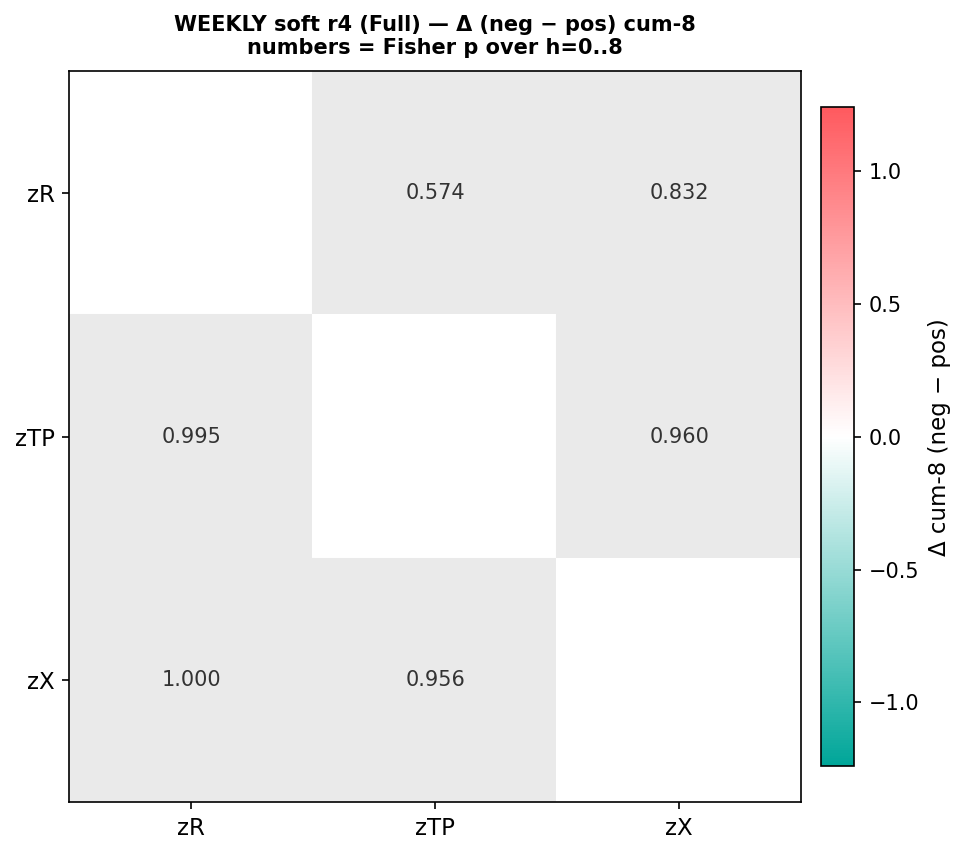

  Significant asymmetry @5%: 0 cells (neg>pos: 0, pos>neg: 0)
WEEKLY soft r4 (2024-H2): LP with lag controls p=2, n=27, window=2024-07-01…2024-12-30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


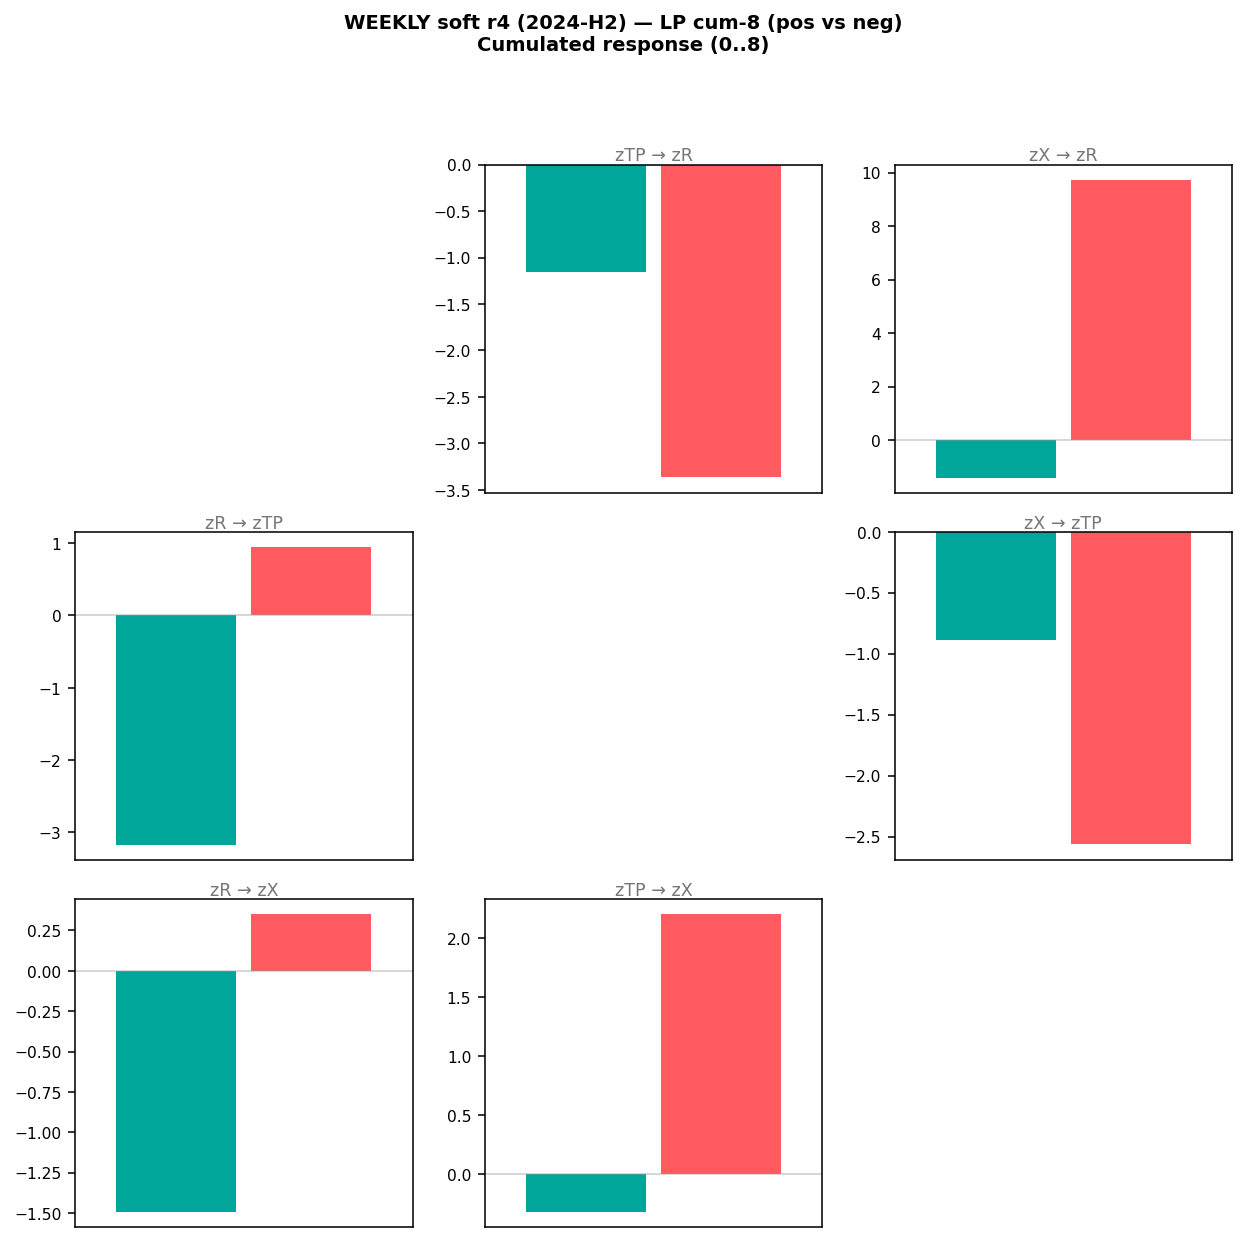

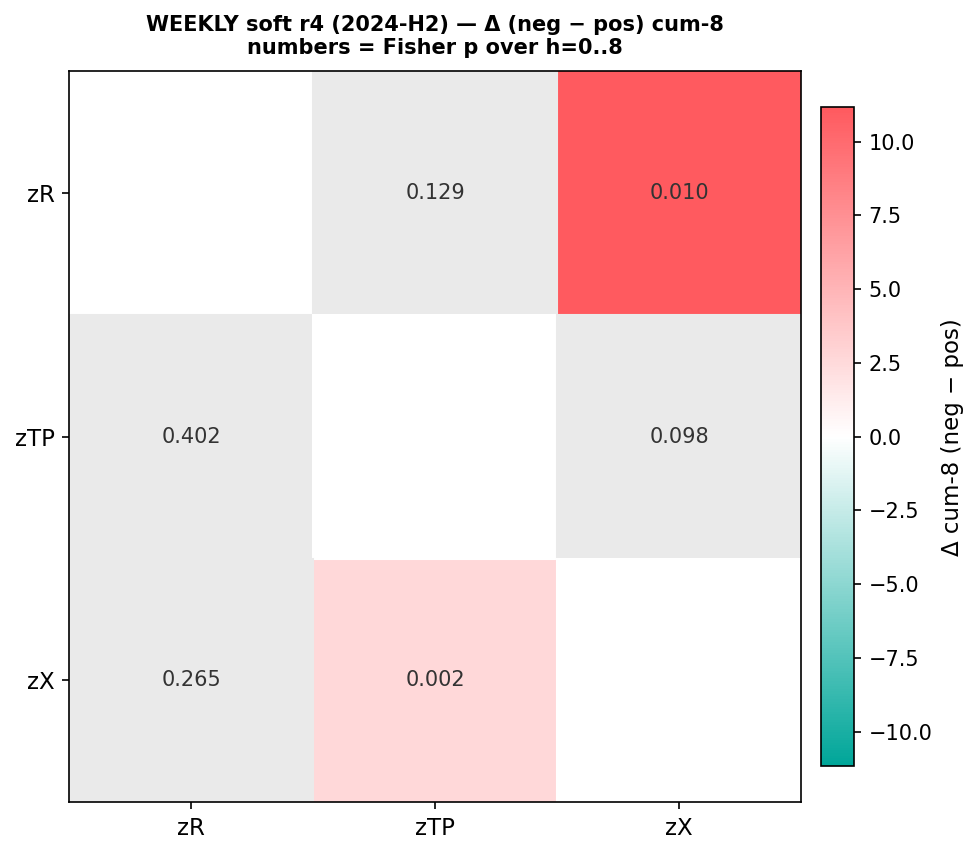

  Significant asymmetry @5%: 2 cells (neg>pos: 2, pos>neg: 0)
WEEKLY soft r4 (2025-H1): LP with lag controls p=2, n=26, window=2025-01-06…2025-06-30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


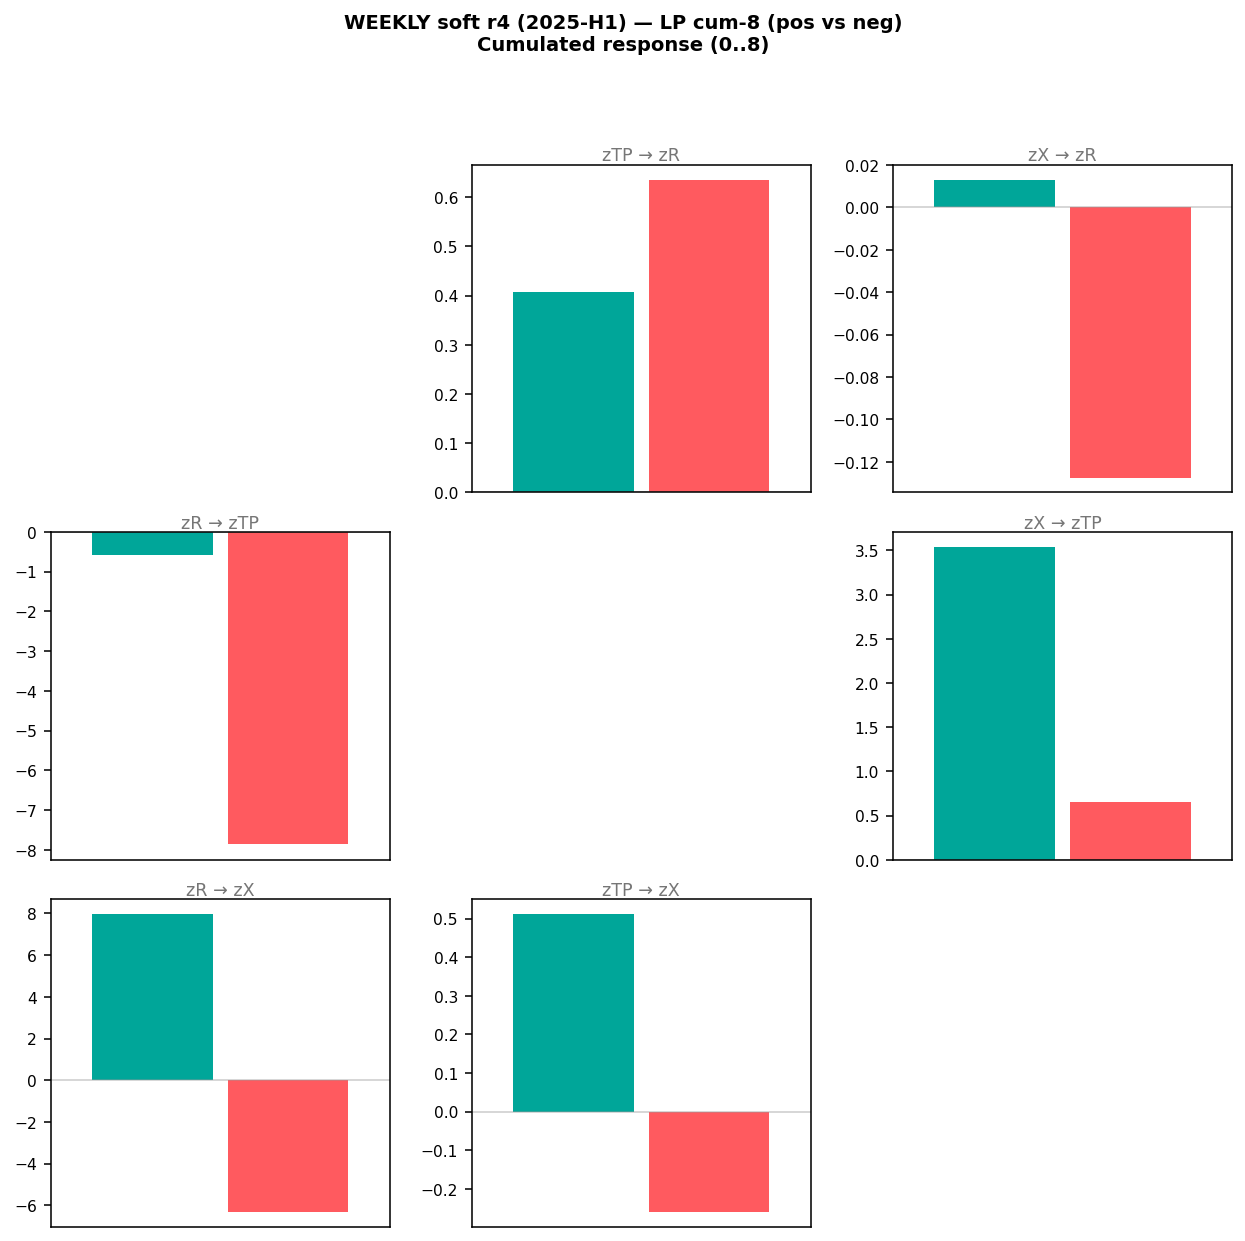

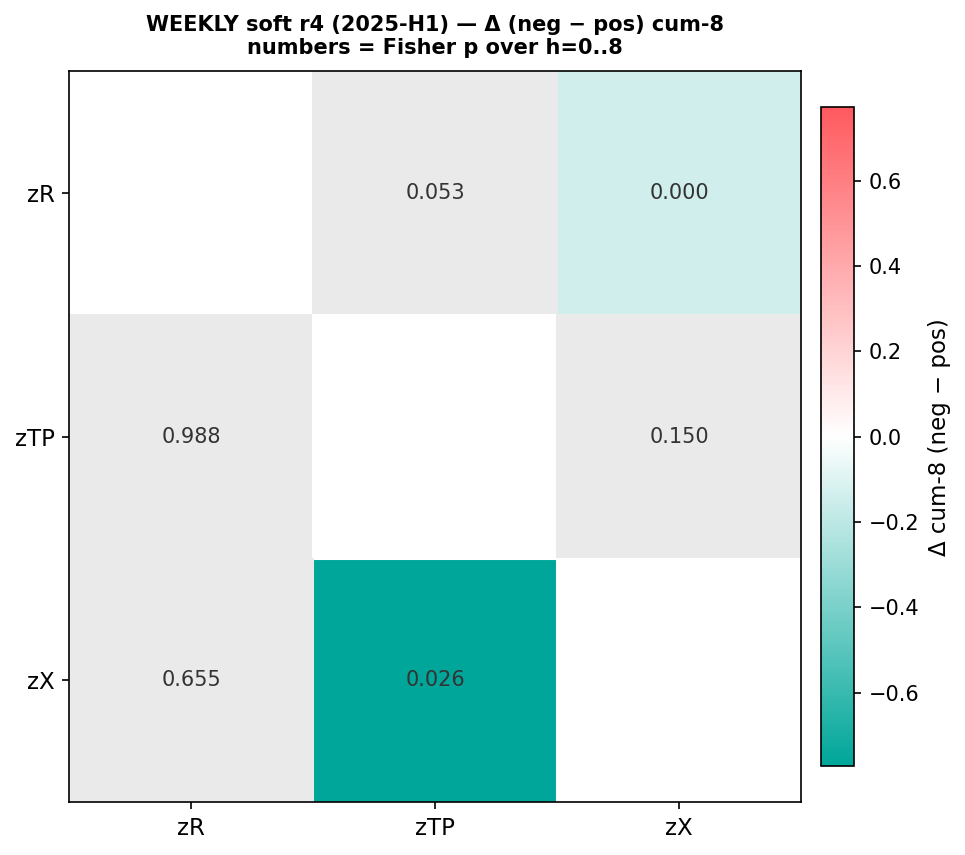

  Significant asymmetry @5%: 2 cells (neg>pos: 0, pos>neg: 2)
DAILY soft r7 (Full): LP with lag controls p=8, n=365, window=2024-07-01…2025-06-30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


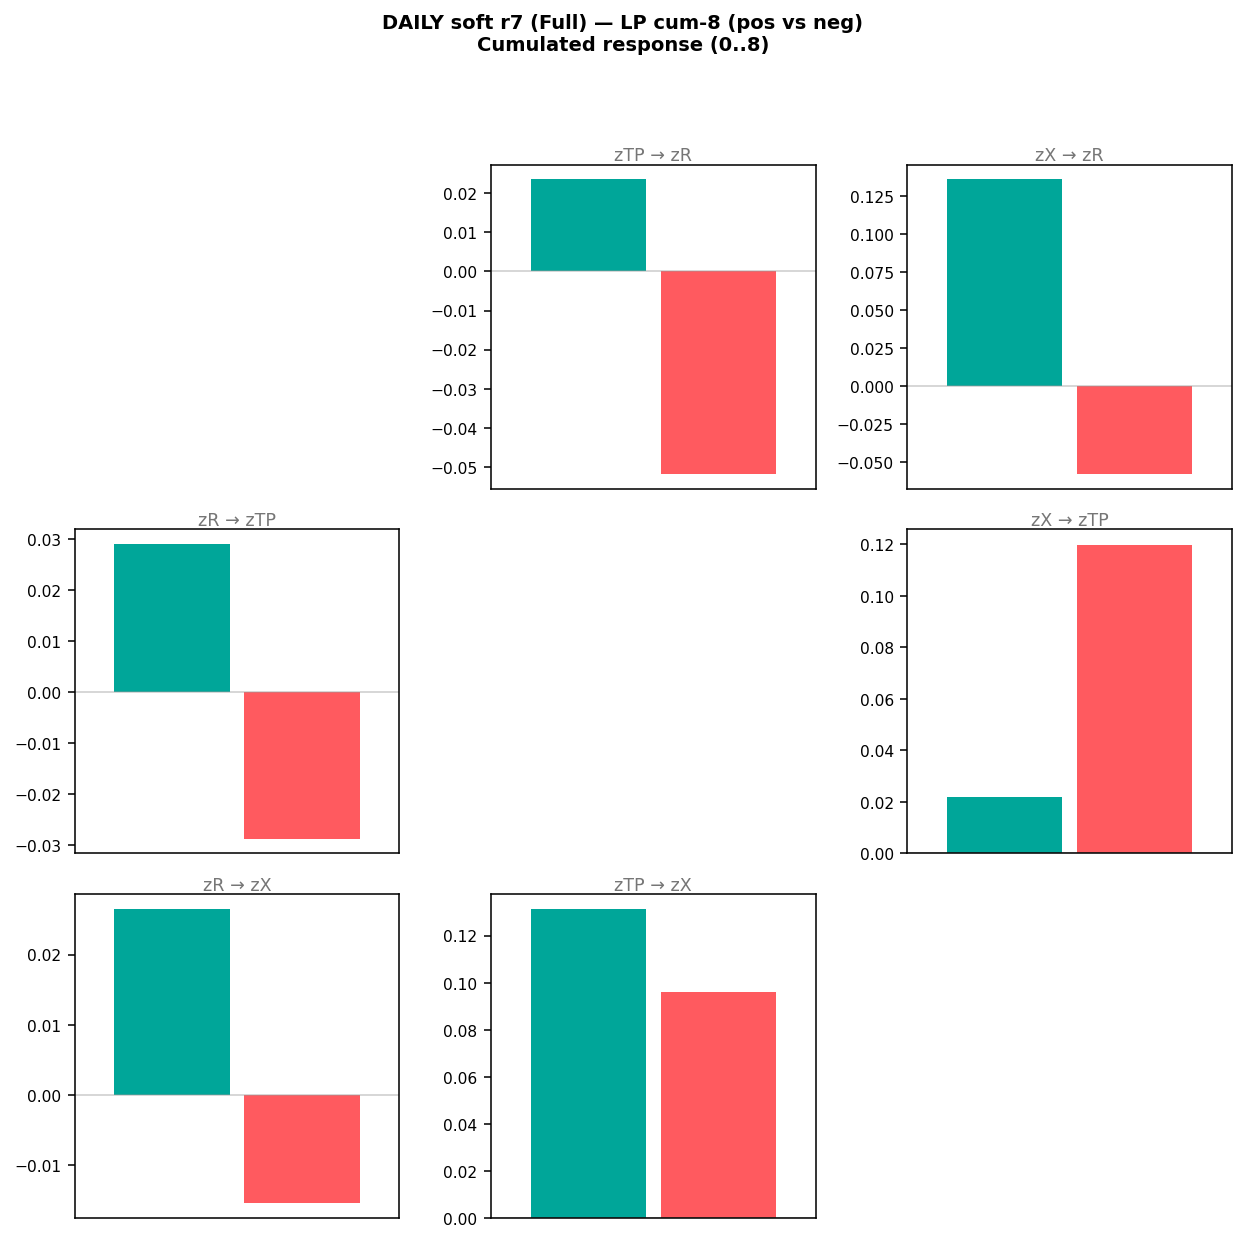

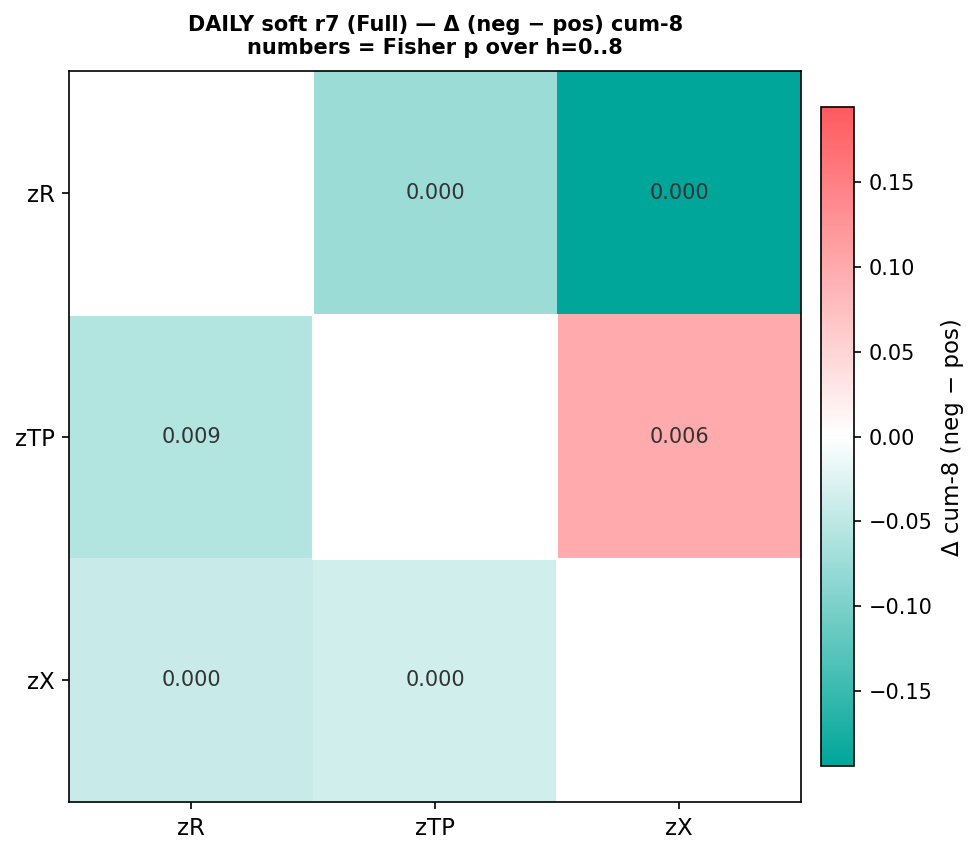

  Significant asymmetry @5%: 6 cells (neg>pos: 1, pos>neg: 5)
DAILY soft r7 (2024-H2): LP with lag controls p=8, n=184, window=2024-07-01…2024-12-31


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


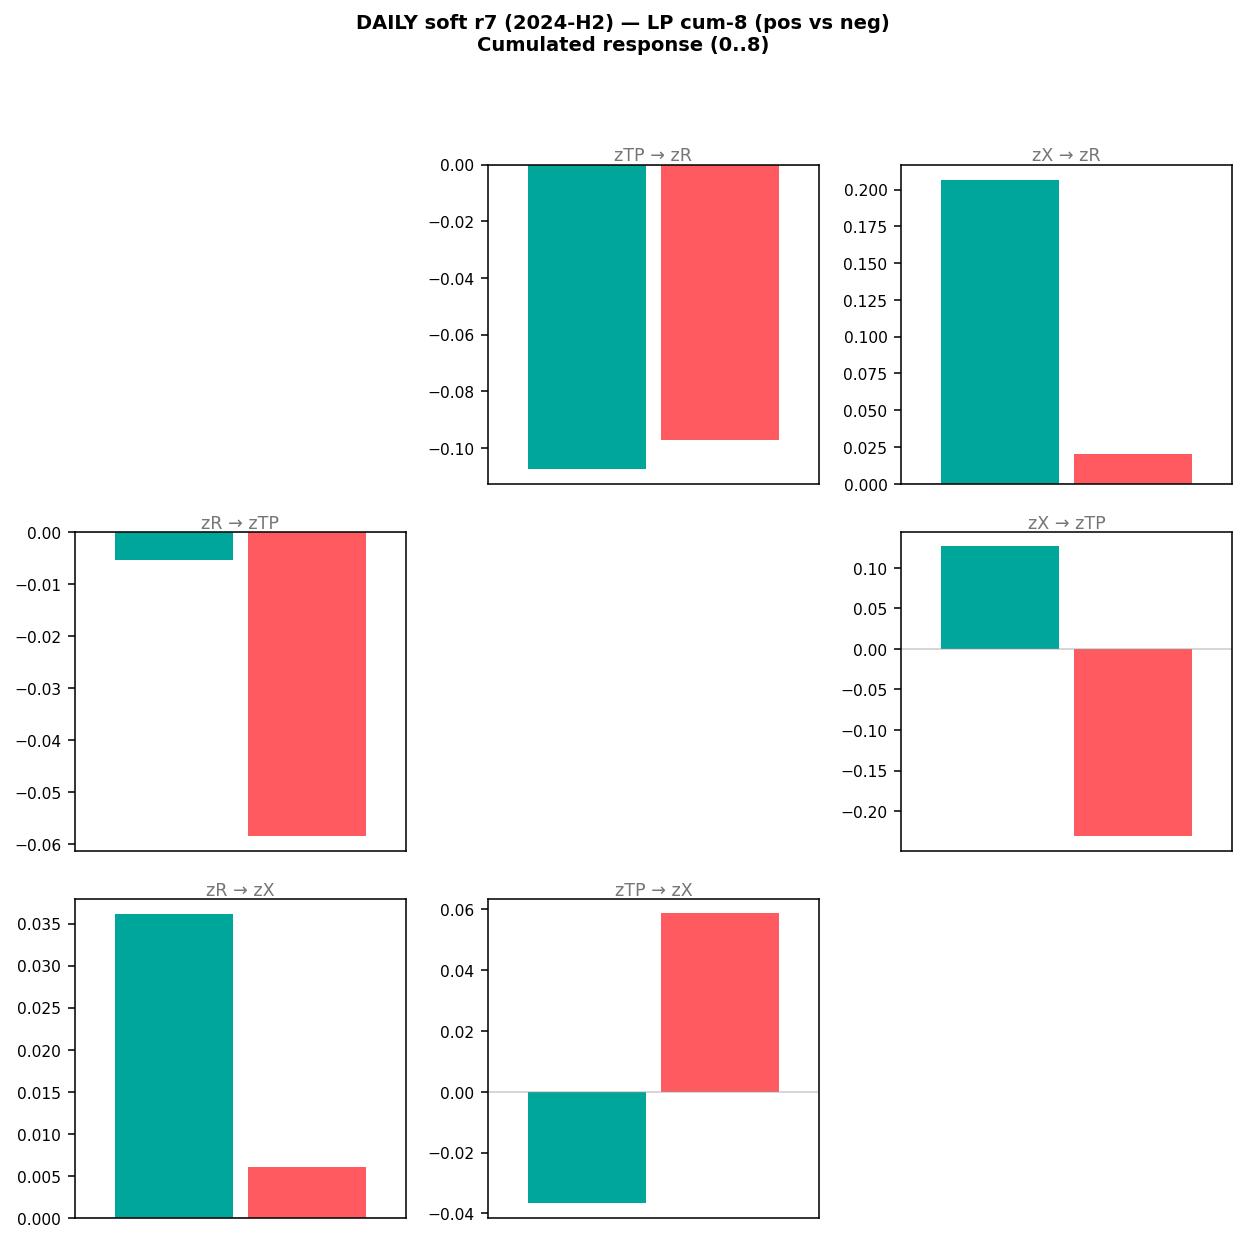

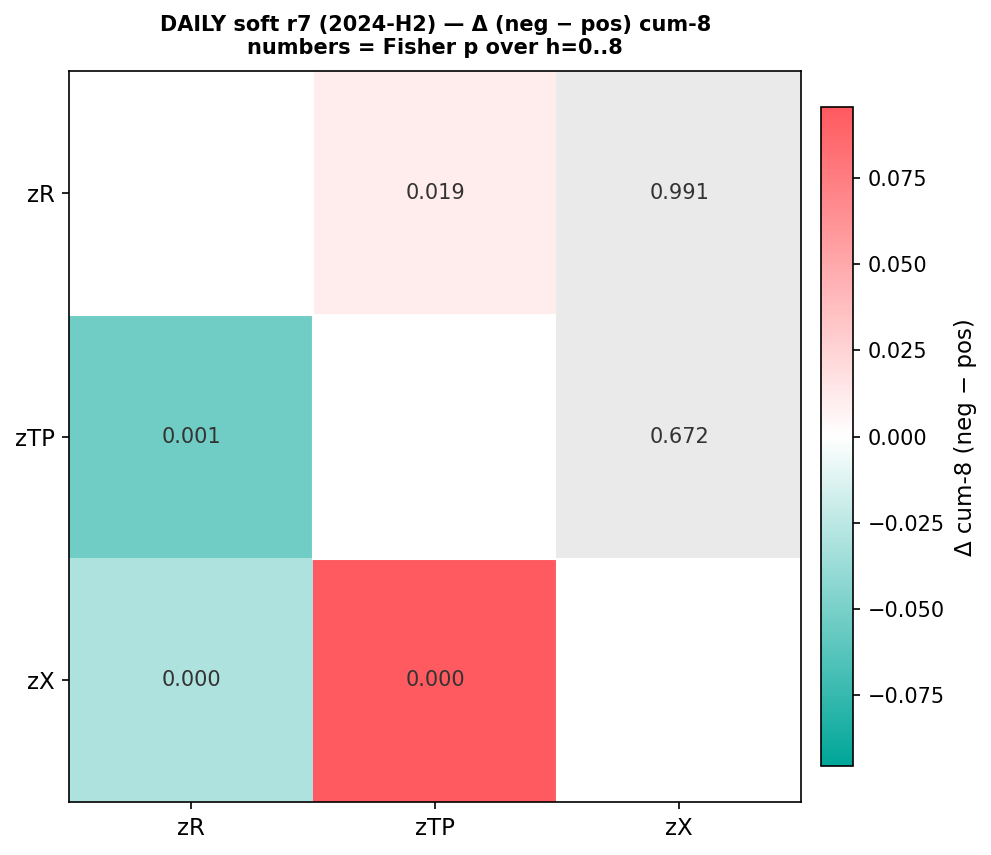

  Significant asymmetry @5%: 4 cells (neg>pos: 2, pos>neg: 2)
DAILY soft r7 (2025-H1): LP with lag controls p=8, n=181, window=2025-01-01…2025-06-30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


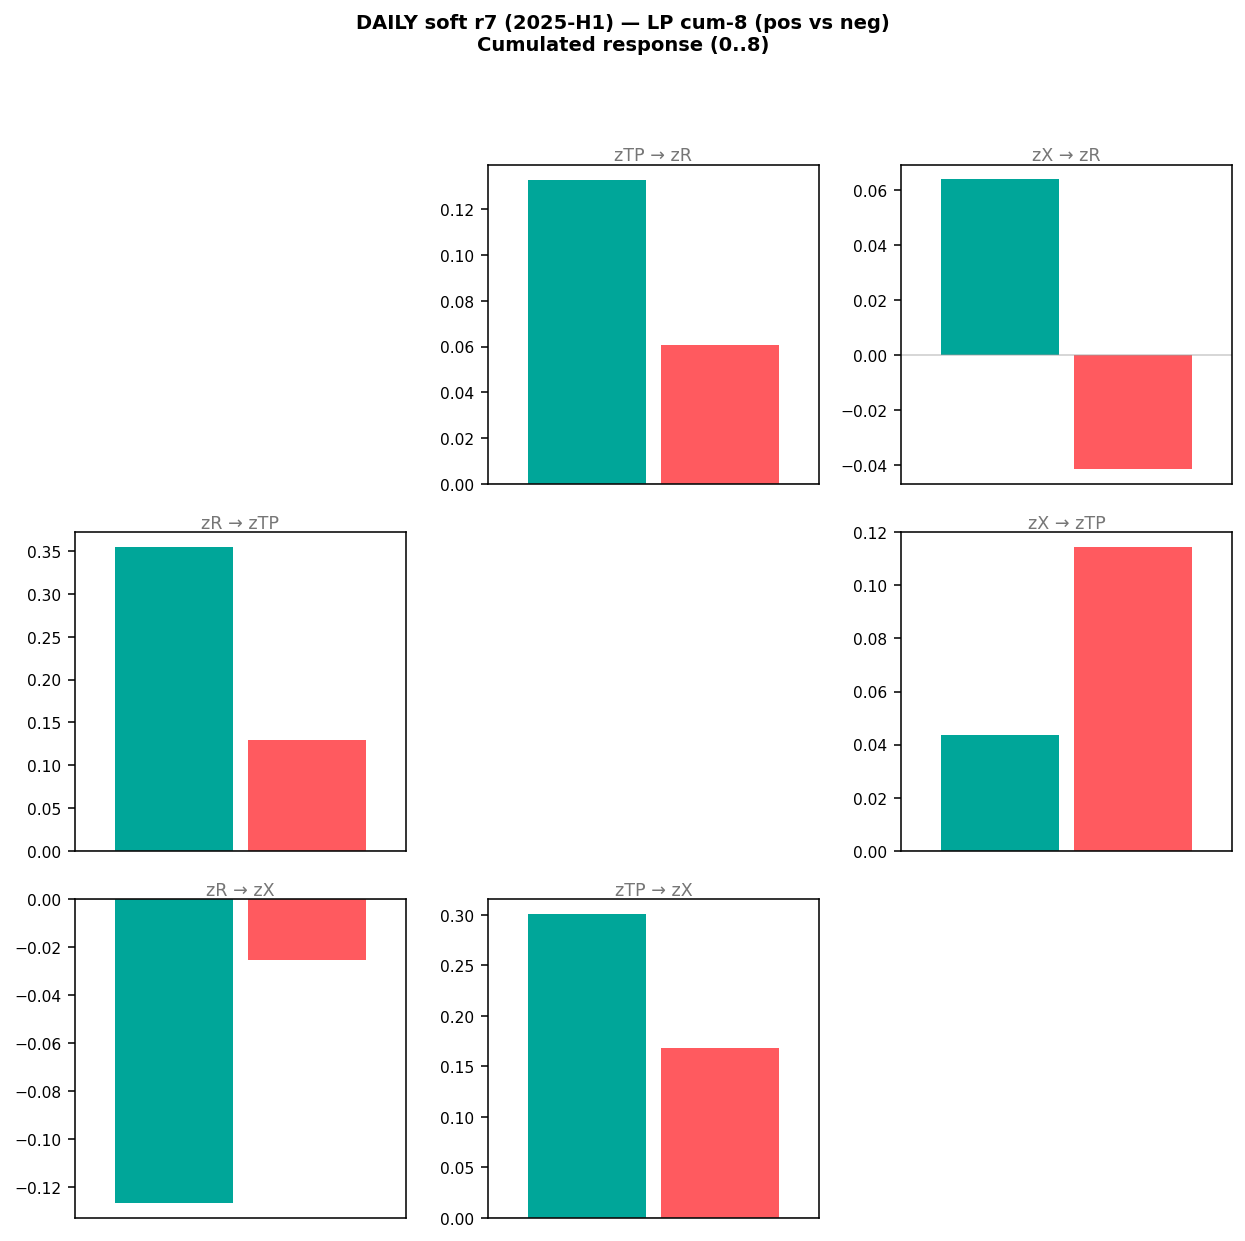

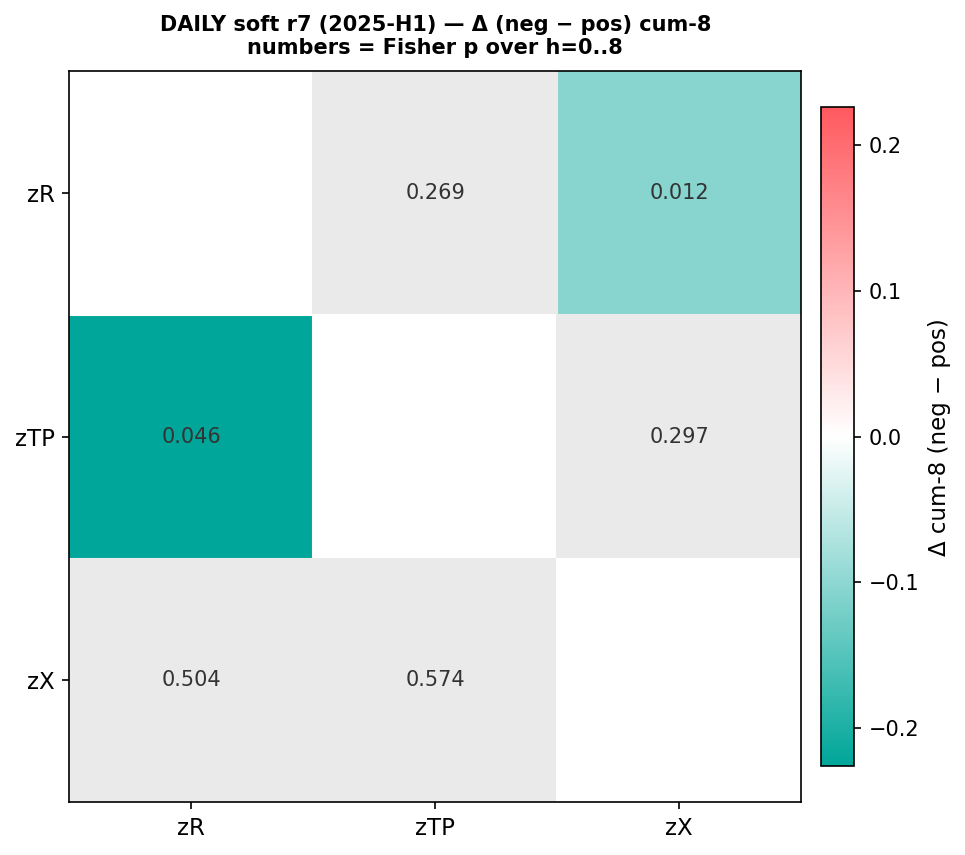

  Significant asymmetry @5%: 2 cells (neg>pos: 0, pos>neg: 2)


{'Y':                   zR       zTP        zX
 date                                    
 2025-01-01  0.036516  0.087937 -0.396610
 2025-01-02  0.039202  0.054678 -0.408131
 2025-01-03  0.072991  0.012686 -0.401777
 2025-01-04  0.466888  0.229867 -0.304791
 2025-01-05 -0.017692  0.033663 -0.087287
 ...              ...       ...       ...
 2025-06-26  0.319777  0.362773  0.207548
 2025-06-27  0.281473  0.191474  0.334640
 2025-06-28  0.384364  0.050990  0.597195
 2025-06-29  0.392941 -0.008466  0.366623
 2025-06-30  0.419113 -0.131808  0.372053
 
 [181 rows x 3 columns],
 'pos': array([[[ 1.00000000e+00,  1.32925181e-01,  6.39914880e-02],
         [ 3.55069031e-01,  1.00000000e+00,  4.37092969e-02],
         [-1.26643950e-01,  3.00877226e-01,  1.00000000e+00]],
 
        [[ 5.46576341e-16,  6.82365859e-17, -2.41781894e-16],
         [-5.07795708e-16, -6.30237075e-16,  2.93481847e-16],
         [ 1.17049776e-15, -2.19423421e-17,  2.47141568e-16]],
 
        [[ 6.03273329e-16,  5.3642074

In [ ]:
from scipy.stats import combine_pvalues, chi2
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

# Airbnb palette
AIRBNB = {
    "rausch": "#FF5A5F",
    "arches": "#FC642D",
    "babu":   "#00A699",
    "foggy":  "#767676",
    "ns":     "#EAEAEA",
}

OUTDIR_LP = (ARTIFACTS / "lp_asym"); OUTDIR_LP.mkdir(parents=True, exist_ok=True)

def _select_lag(Y: pd.DataFrame, cap=8) -> int:
    maxlags = min(cap, max(1, len(Y)//6))
    while maxlags >= 1:
        try:
            sel = sm.tsa.VAR(Y).select_order(maxlags=maxlags)
            p = int(sel.aic) if sel.aic is not None else 1
            return max(1, min(p, maxlags))
        except Exception:
            maxlags -= 1
    return 1

def _prep_wide(csv_path: Path, date_col: str, value_col: str, start=None, end=None) -> pd.DataFrame:
    df = pd.read_csv(csv_path, parse_dates=[date_col])
    if start is not None: df = df[df[date_col] >= pd.to_datetime(start)]
    if end   is not None: df = df[df[date_col] <= pd.to_datetime(end)]
    wide = (df.pivot(index=date_col, columns="source", values=value_col).sort_index())
    cols = [c for c in ORDER if c in wide.columns]
    Y = wide[cols].dropna().copy()
    Y.columns = NAMES[:len(cols)]
    return Y

def _make_lags(Y: np.ndarray, p: int):
    T, k = Y.shape
    Xlags = []
    for L in range(1, p+1):
        pad = np.full((L, k), np.nan)
        Xlags.append(np.vstack([pad, Y[:-L, :]]))
    return np.hstack(Xlags)  # (T, k*p)

def lp_pos_neg(Y: pd.DataFrame, H=8, p=2, cov_type="HC1"):
    Yv = Y.values
    T, k = Yv.shape
    lags = _make_lags(Yv, p)
    const = np.ones((T, 1))

    irf_pos = np.zeros((H+1, k, k))
    irf_neg = np.zeros((H+1, k, k))
    p_fisher = np.ones((k, k))

    for j in range(k):
        s = Yv[:, j].copy()
        s_pos = np.where(s > 0, s, 0.0)
        s_neg = np.where(s < 0, s, 0.0)

        for i in range(k):
            p_list = []
            for h in range(H+1):
                y_dep = np.concatenate([np.full(h, np.nan), Yv[:-h, i]]) if h > 0 else Yv[:, i]
                X = np.column_stack([const, s_pos, s_neg, lags])
                mat = np.column_stack([y_dep, X])
                mat = mat[~np.isnan(mat).any(axis=1)]
                y = mat[:, 0]
                Xr = mat[:, 1:]
                res = sm.OLS(y, Xr).fit(cov_type=cov_type)
                b_pos = res.params[1]
                b_neg = res.params[2]
                irf_pos[h, i, j] = b_pos
                irf_neg[h, i, j] = b_neg
                try:
                    w = res.wald_test(np.array([[0,1,-1] + [0]*(Xr.shape[1]-3)]))
                    p_list.append(float(w.pvalue))
                except Exception:
                    p_list.append(1.0)
            p_arr = np.clip(np.array(p_list), 1e-12, 1.0)
            stat = -2.0*np.sum(np.log(p_arr))
            p_joint = chi2.sf(stat, df=2*len(p_arr))
            p_fisher[i, j] = float(p_joint)

    return irf_pos, irf_neg, p_fisher

def cum_along_h(arr):
    return np.cumsum(arr, axis=0)

def bar_grid_cum8_posneg(cpos_cum, cneg_cum, names, title, save_path=None, title_fs=10):
    """
    Two bars per off-diagonal cell: pos (teal) vs neg (red). Uses cumulated value at H.
    """
    Hk = cpos_cum.shape[0]-1
    k  = cpos_cum.shape[1]
    fig, axes = plt.subplots(k, k, figsize=(9, 9), dpi=140)
    fig.suptitle(title + "\nCumulated response (0..8)", y=0.98, fontsize=title_fs, fontweight=600)

    for r in range(k):
        for c in range(k):
            ax = axes[r, c]
            if r == c:
                ax.axis("off"); continue
            y_pos = float(cpos_cum[Hk, r, c])
            y_neg = float(cneg_cum[Hk, r, c])
            ax.axhline(0, lw=0.8, color="#999", alpha=0.5)
            ax.bar([-0.18], [y_pos], width=0.32, color=AIRBNB["babu"],  edgecolor="none")
            ax.bar([+0.18], [y_neg], width=0.32, color=AIRBNB["rausch"], edgecolor="none")
            ax.set_xticks([]); ax.tick_params(axis="y", labelsize=8)
            ax.set_title(f"{names[c]} → {names[r]}", fontsize=9, color=AIRBNB["foggy"], pad=2)

    for ax in axes.ravel():
        if ax.has_data(): ax.set_xlim(-0.45, 0.45)
    plt.tight_layout(rect=[0,0,1,0.94])
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()
    return fig

def heatmap_delta_negminuspos(cpos_cum, cneg_cum, pmat, names, title,
                              alpha=0.05, save_path=None, title_fs=10):
    """
    Heatmap of Δ = (neg - pos) cum-8. Non-significant cells (p>=alpha) are set to light gray.
    Colors: red => neg > pos (stronger negative spillover), teal => pos > neg.
    """
    Hk = cpos_cum.shape[0]-1
    delta = (cneg_cum[Hk] - cpos_cum[Hk])
    k = delta.shape[0]

    cmap = LinearSegmentedColormap.from_list(
        "airbnb_div",
        [AIRBNB["babu"], "#FFFFFF", AIRBNB["rausch"]],
        N=256
    )

    show = delta.copy()
    for i in range(k):
        for j in range(k):
            if i == j: show[i, j] = np.nan
            elif pmat[i, j] >= alpha: show[i, j] = np.nan

    vmax = np.nanmax(np.abs(show))
    if not np.isfinite(vmax) or vmax == 0: vmax = np.nanmax(np.abs(delta))
    vmax = max(1e-6, float(vmax))

    fig, ax = plt.subplots(figsize=(7.2, 5.8), dpi=150)
    im = ax.imshow(delta, cmap=cmap, vmin=-vmax, vmax=+vmax)

    for i in range(k):
        for j in range(k):
            if i == j:
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="white"))
                continue
            p = pmat[i, j]
            if p >= alpha:
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color=AIRBNB["ns"]))
            ax.text(j, i, f"{p:.3f}", ha="center", va="center", color="#333", fontsize=10)

    ax.set_xticks(range(k)); ax.set_xticklabels(names, fontsize=11)
    ax.set_yticks(range(k)); ax.set_yticklabels(names, fontsize=11)
    ax.set_title(title + " — Δ (neg − pos) cum-8\nnumbers = Fisher p over h=0..8",
                 fontsize=title_fs, pad=8, fontweight=600)

    cbar = plt.colorbar(im, ax=ax, shrink=0.9, pad=0.02)
    cbar.set_label("Δ cum-8 (neg − pos)", fontsize=11)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()
    return fig

def run_lp_asymmetry_window(csv_path, date_col, value_col, title,
                            start=None, end=None, cap=8, H=8, title_fs=10):
    Y = _prep_wide(csv_path, date_col, value_col, start, end)
    if Y.shape[1] < 2:
        print(f"{title}: need >=2 series; got {Y.shape[1]}"); return None
    p = _select_lag(Y, cap=cap)
    print(f"{title}: LP with lag controls p={p}, n={len(Y):d}, window={Y.index.min().date()}…{Y.index.max().date()}")

    pos, neg, p_fisher = lp_pos_neg(Y, H=H, p=p, cov_type="HC1")
    cpos = cum_along_h(pos); cneg = cum_along_h(neg)

    bar_grid_cum8_posneg(
        cpos, cneg, list(Y.columns),
        f"{title} — LP cum-8 (pos vs neg)",
        save_path=(OUTDIR_LP / f"{title.replace(' ','_').replace('/','-')}_LP_bars.png"),
        title_fs=title_fs
    )

    heatmap_delta_negminuspos(
        cpos, cneg, p_fisher, list(Y.columns),
        f"{title}",
        alpha=0.05,
        save_path=(OUTDIR_LP / f"{title.replace(' ','_').replace('/','-')}_LP_asym.png"),
        title_fs=title_fs
    )

    sig05 = (p_fisher < 0.05) & ~np.eye(len(Y.columns), dtype=bool)
    sig10 = (p_fisher < 0.10) & ~np.eye(len(Y.columns), dtype=bool)
    d = (cneg[-1] - cpos[-1])
    neg_stronger = int(np.nansum((d > 0) & sig05))
    pos_stronger = int(np.nansum((d < 0) & sig05))
    print(f"  Significant asymmetry @5%: {sig05.sum()} cells "
          f"(neg>pos: {neg_stronger}, pos>neg: {pos_stronger})")
    return {"Y": Y, "pos": pos, "neg": neg, "p_fisher": p_fisher, "cum_pos": cpos, "cum_neg": cneg}

# Weekly soft r4
run_lp_asymmetry_window(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4",
                        "WEEKLY soft r4 (Full)", H=8, cap=8, title_fs=10)
run_lp_asymmetry_window(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4",
                        "WEEKLY soft r4 (2024-H2)", start="2024-07-01", end="2024-12-31",
                        H=8, cap=8, title_fs=10)
run_lp_asymmetry_window(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4",
                        "WEEKLY soft r4 (2025-H1)", start="2025-01-01", end="2025-06-30",
                        H=8, cap=8, title_fs=10)

# Daily soft r7
run_lp_asymmetry_window(DAILY_SOFT_R7, "date", "sent_z_soft_r7",
                        "DAILY soft r7 (Full)", H=8, cap=8, title_fs=10)
run_lp_asymmetry_window(DAILY_SOFT_R7, "date", "sent_z_soft_r7",
                        "DAILY soft r7 (2024-H2)", start="2024-07-01", end="2024-12-31",
                        H=8, cap=8, title_fs=10)
run_lp_asymmetry_window(DAILY_SOFT_R7, "date", "sent_z_soft_r7",
                        "DAILY soft r7 (2025-H1)", start="2025-01-01", end="2025-06-30",
                        H=8, cap=8, title_fs=10)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


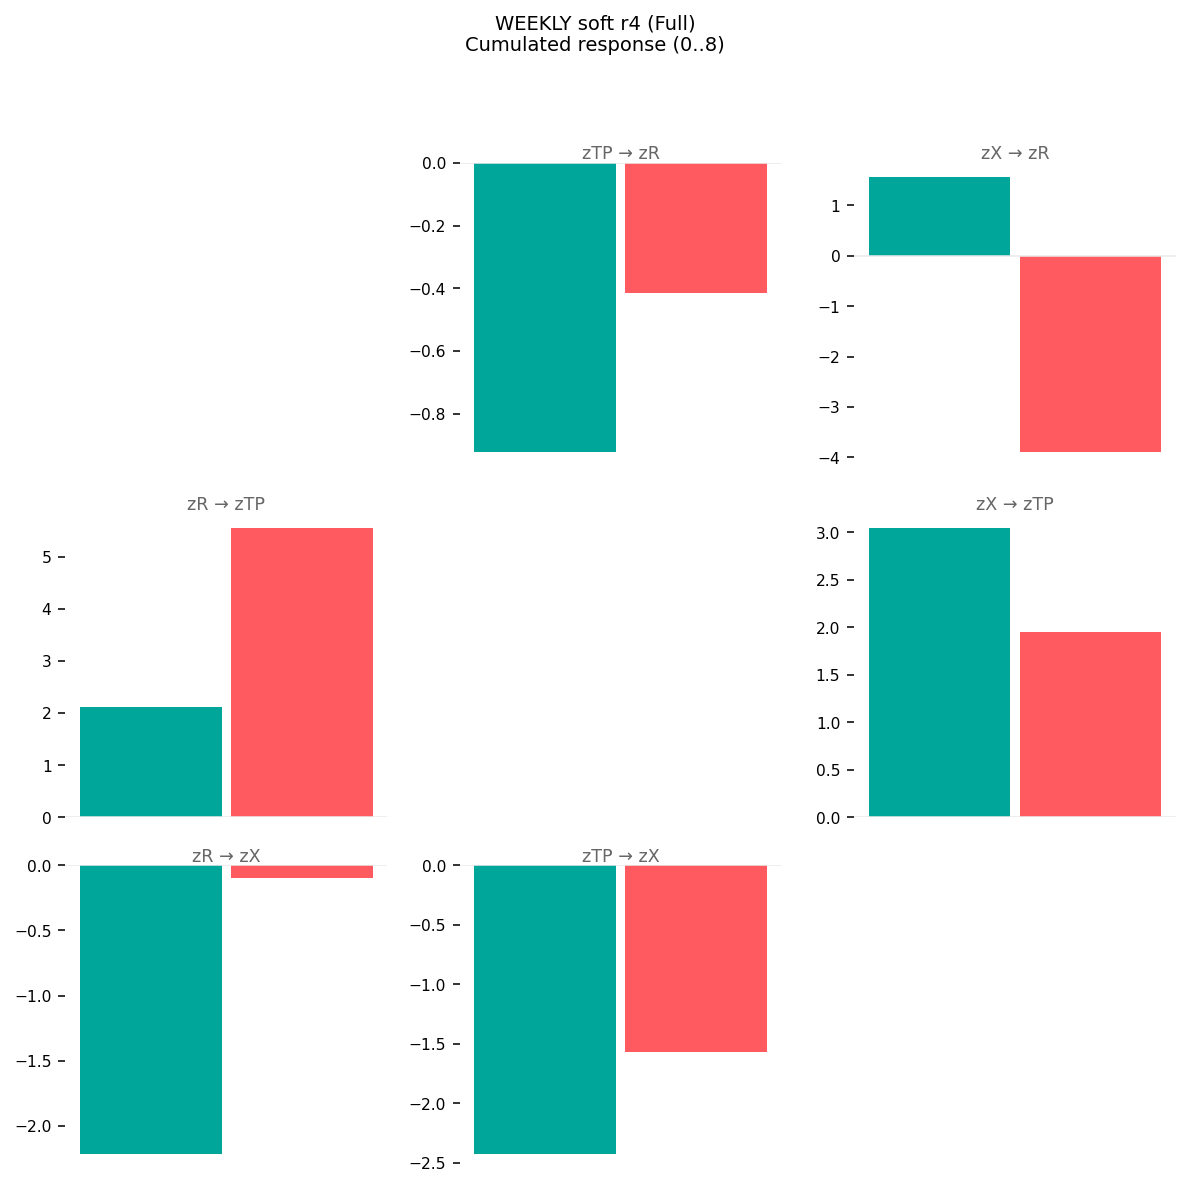

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


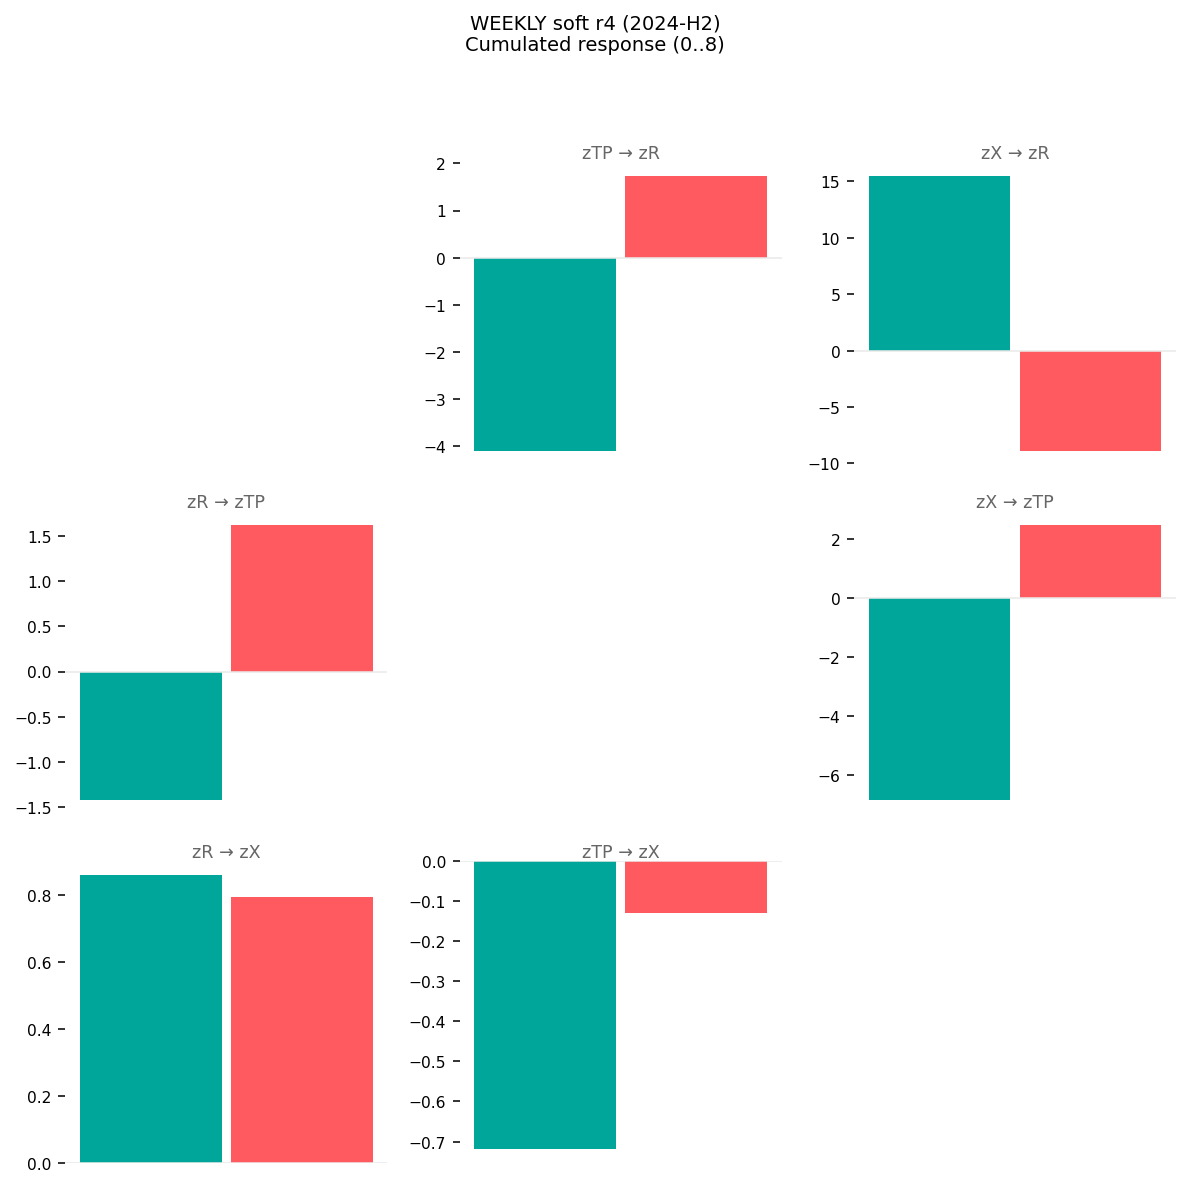

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


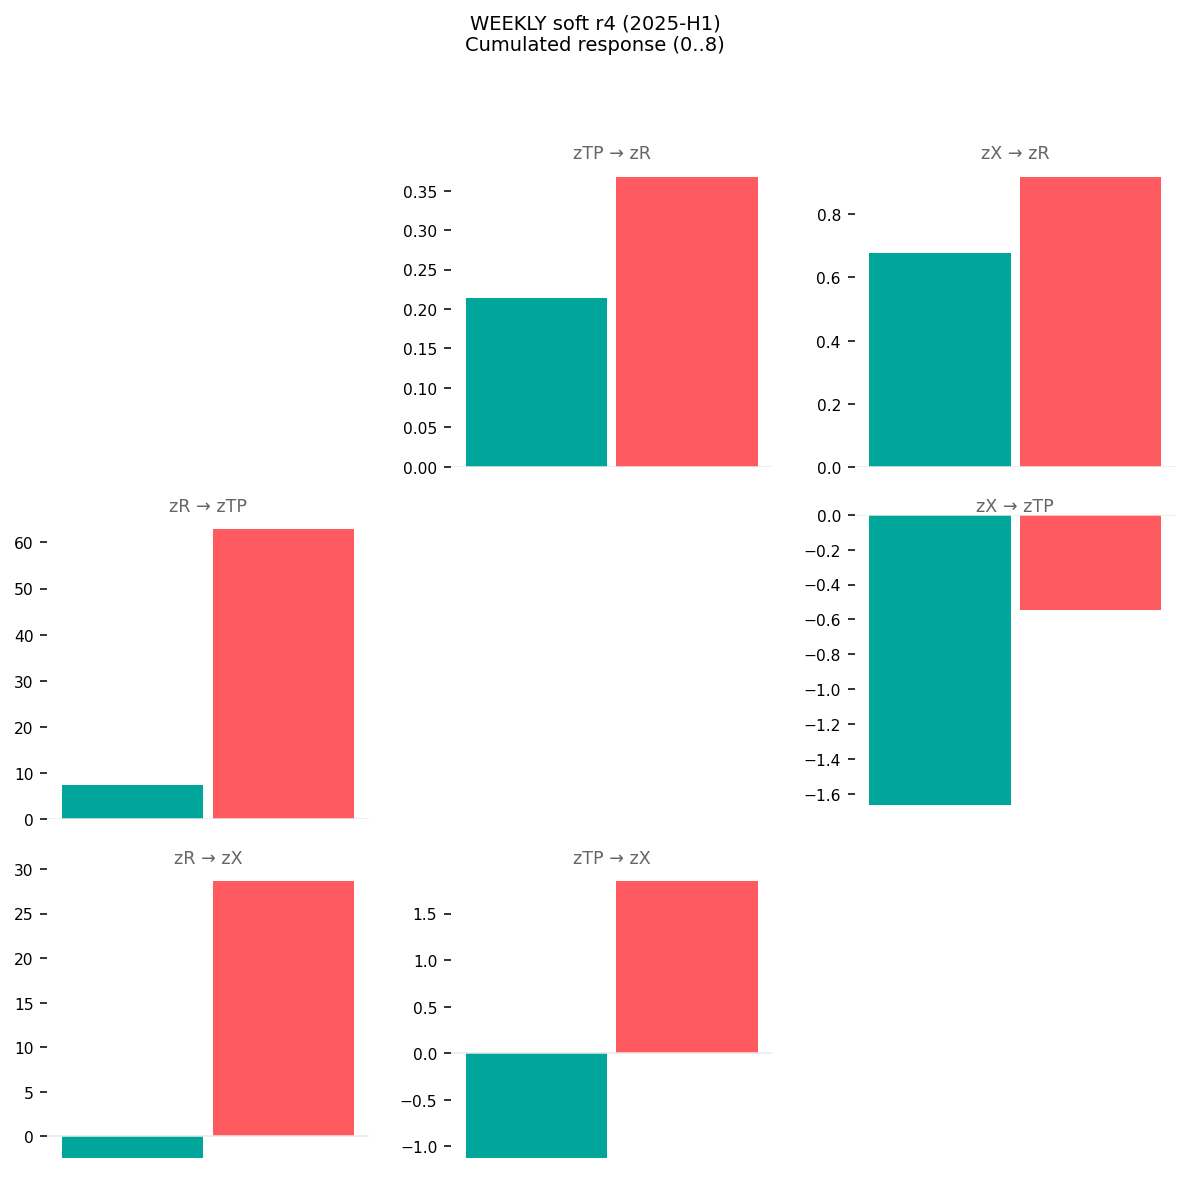

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


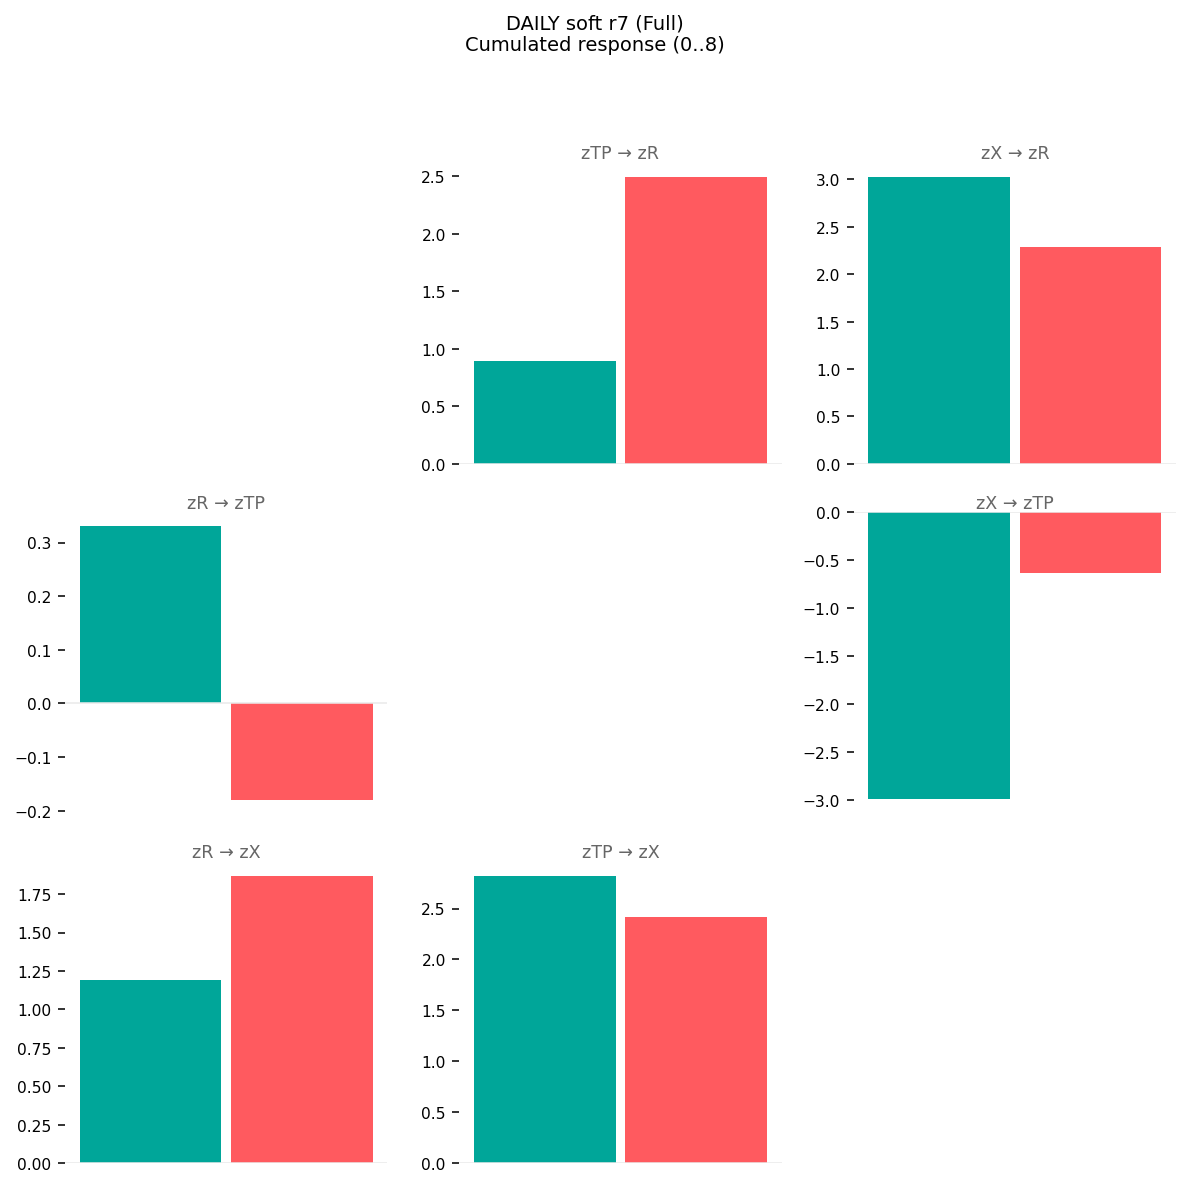

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


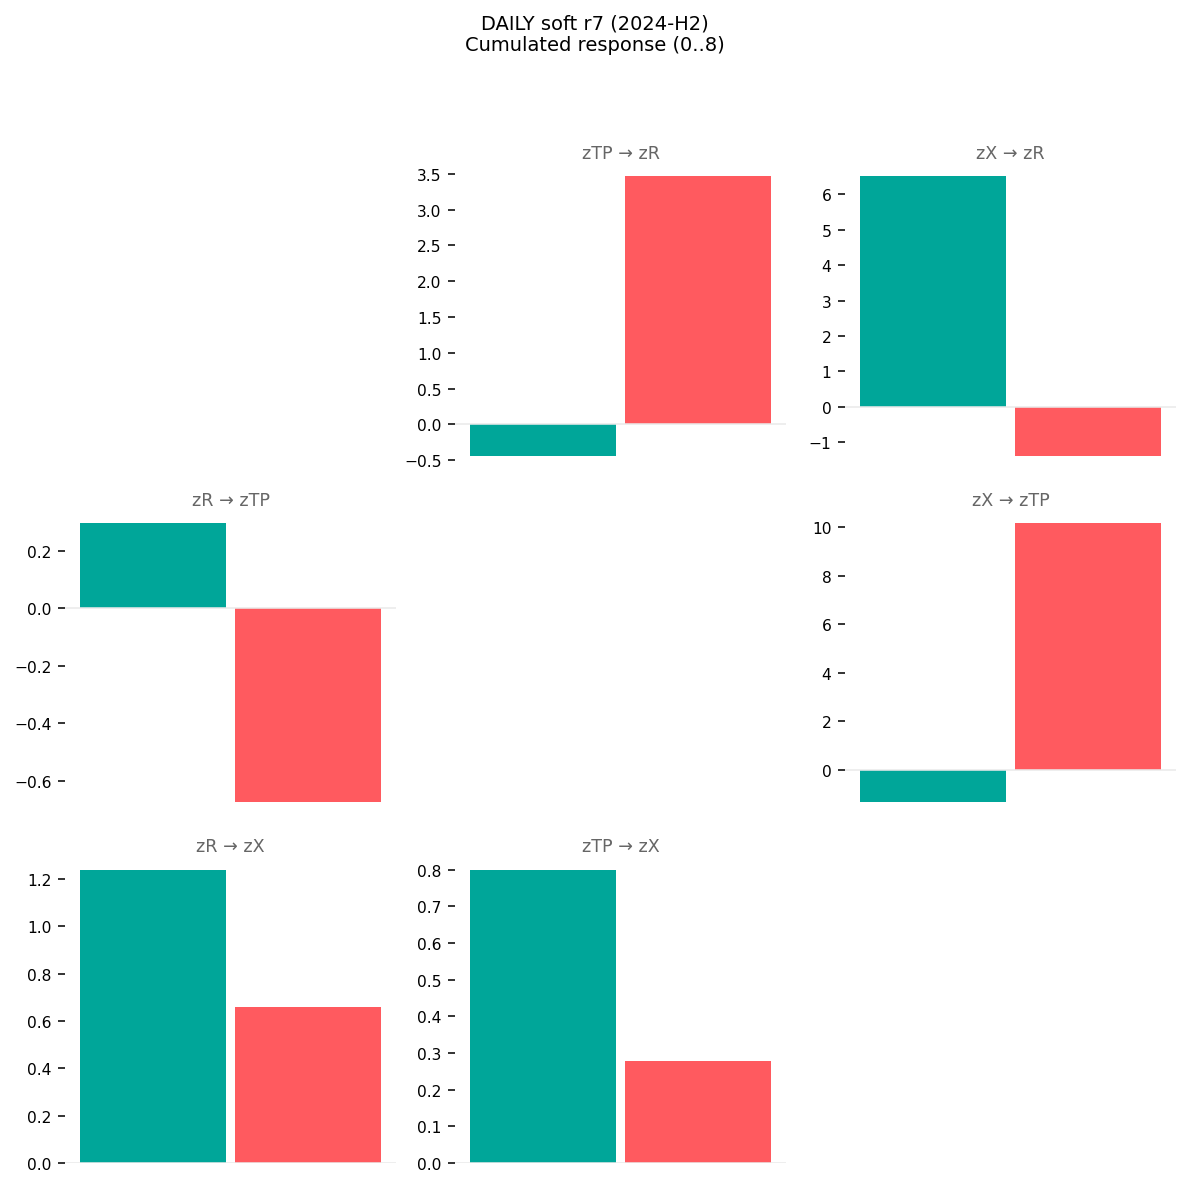

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


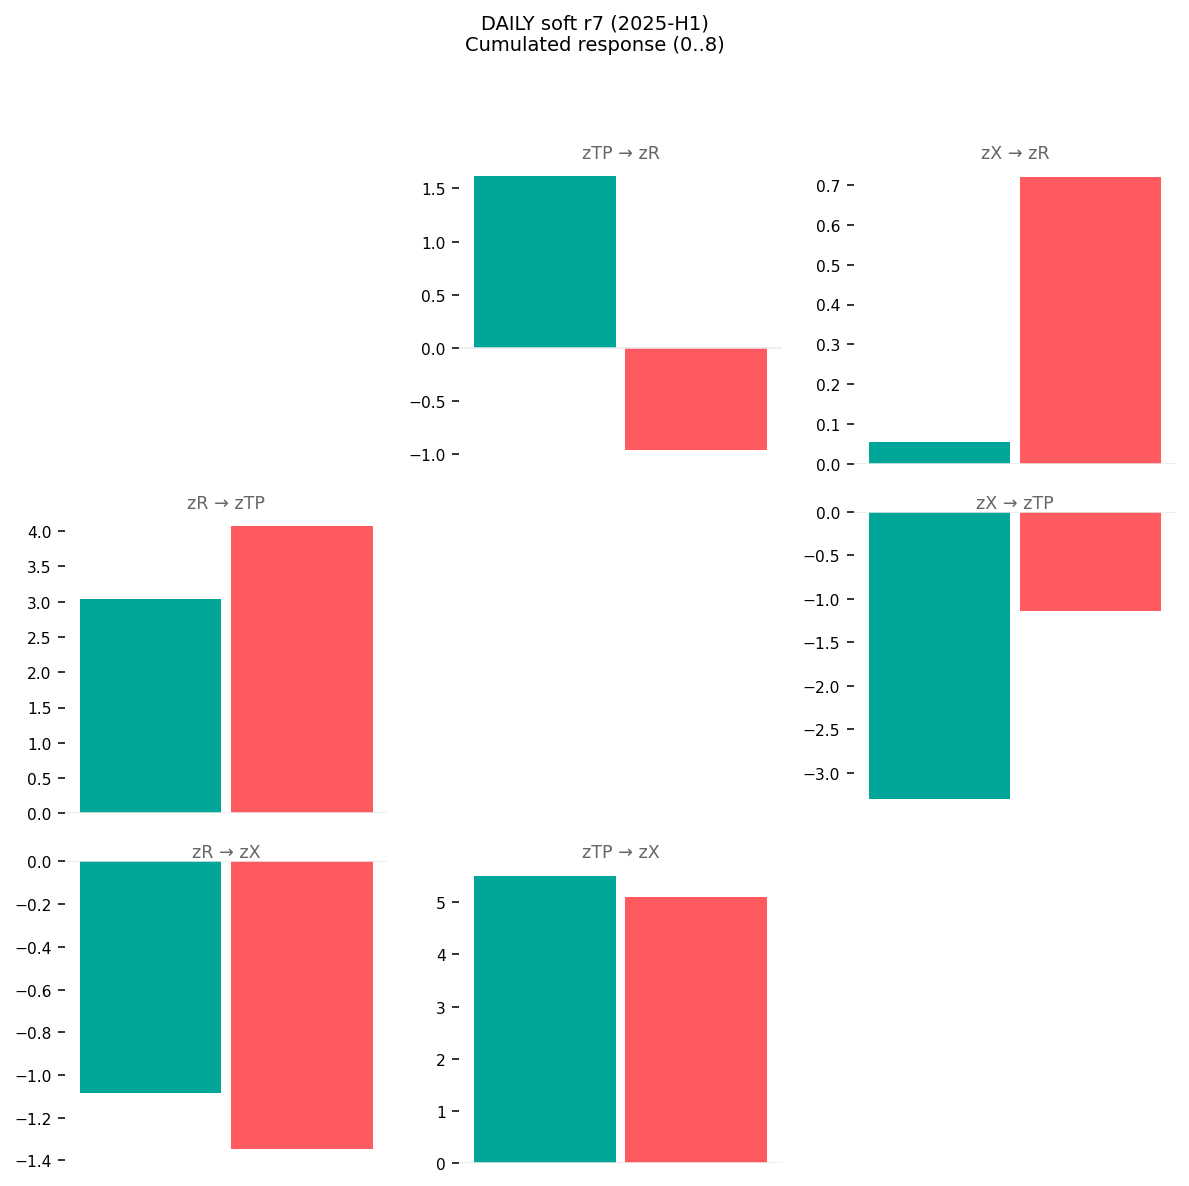

/tmp/ipython-input-923234877.py:239: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.94])


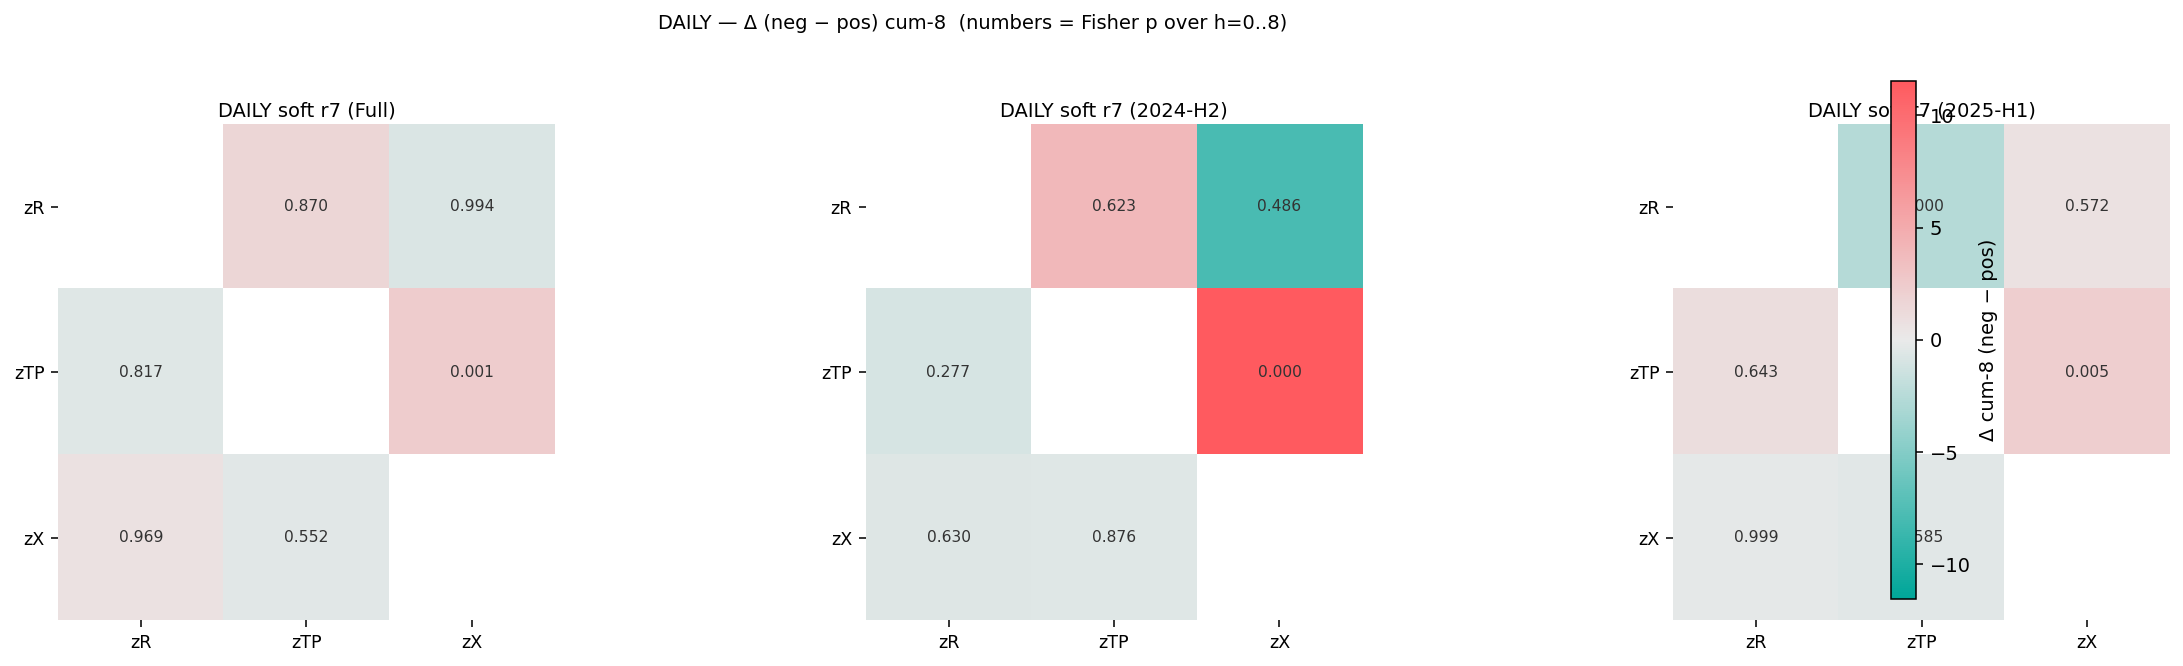

/tmp/ipython-input-923234877.py:239: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.94])


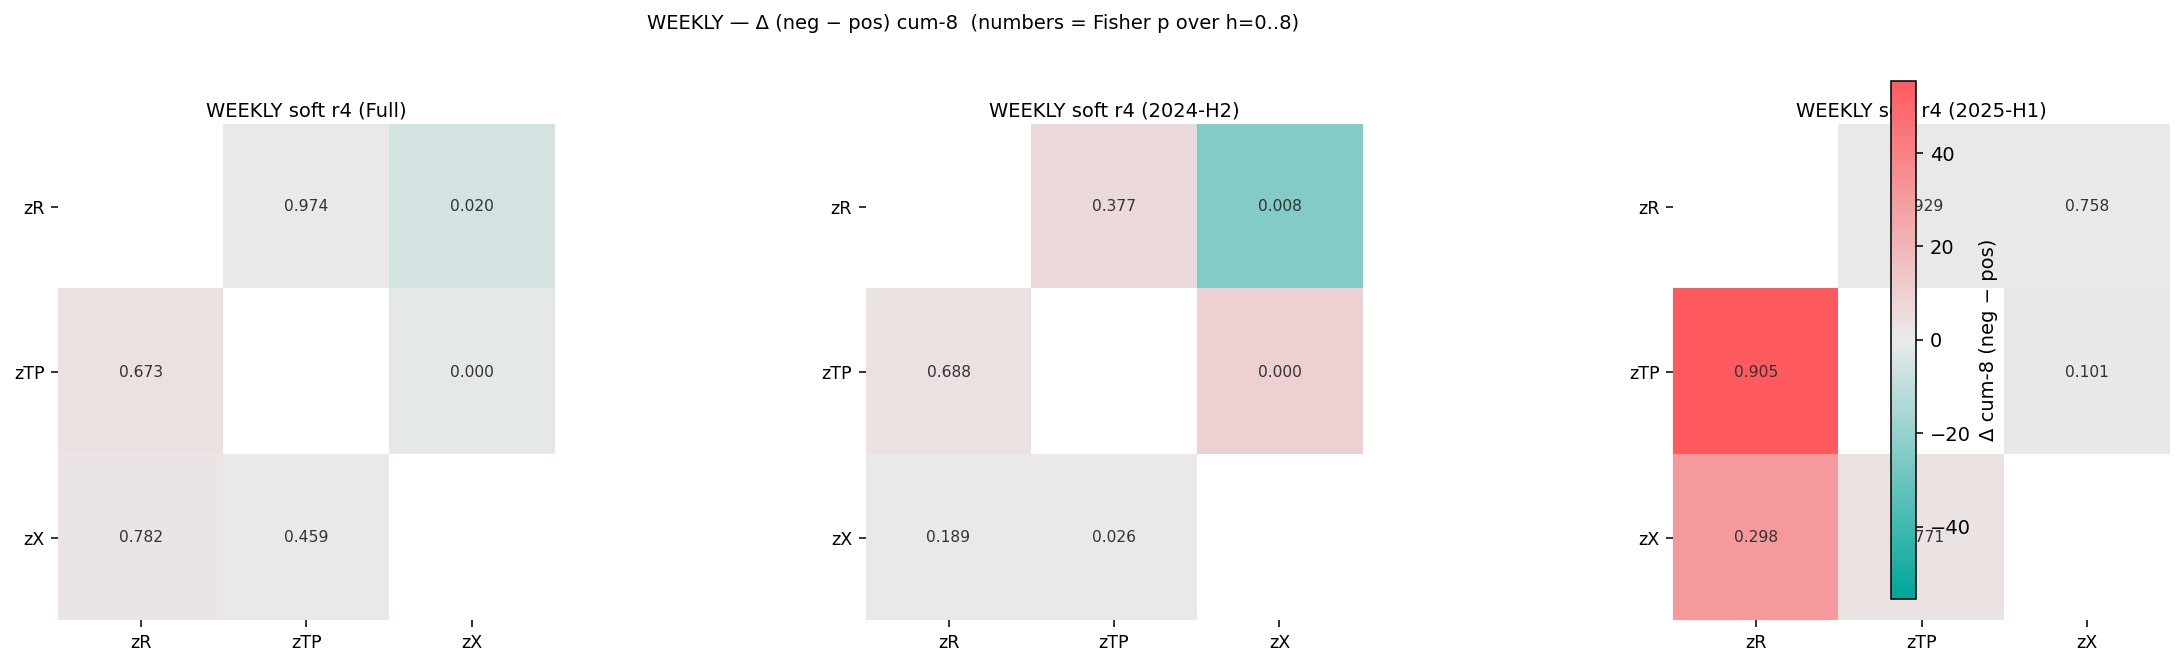

In [ ]:
AIRBNB = {
    "pos":   "#00A699",  # teal
    "neg":   "#FF5A5F",  # red
    "light": "#EAEAEA",  # light gray for guides
    "text":  "#666666",  # axis/title text
}

# If not set elsewhere, set output dir and naming helpers
OUTDIR = Path("spillovers/irf_fevd")
OUTDIR.mkdir(parents=True, exist_ok=True)

# If not set elsewhere, platform ordering and short names
ORDER = ["Reddit", "Trustpilot", "X (Twitter)"]
NAMES = ["zR", "zTP", "zX"]


# ---------- helpers ----------
def _prep_wide(csv_path: Path, date_col: str, value_col: str, start=None, end=None):
    df = pd.read_csv(csv_path, parse_dates=[date_col])
    if start is not None: df = df[df[date_col] >= pd.to_datetime(start)]
    if end   is not None: df = df[df[date_col] <= pd.to_datetime(end)]
    wide = df.pivot(index=date_col, columns="source", values=value_col).sort_index()
    cols = [c for c in ORDER if c in wide.columns]
    Y = wide[cols].dropna().copy()
    Y.columns = NAMES[:len(cols)]
    return Y

def _select_lag(Y: pd.DataFrame, cap=8) -> int:
    # small, robust lag selector (like before)
    maxlags = min(cap, max(1, len(Y)//6))
    p = 1
    while maxlags >= 1:
        try:
            sel = sm.tsa.VAR(Y).select_order(maxlags=maxlags)
            p = int(sel.aic) if sel.aic is not None else 1
            p = max(1, min(p, maxlags))
            break
        except Exception:
            maxlags -= 1
    return p

def _fisher_combine(pvals):
    """Fisher combine (ignore nan); return combined p."""
    pvals = [float(p) for p in pvals if np.isfinite(p) and p > 0]
    if len(pvals) == 0:
        return np.nan
    X2 = -2.0 * np.sum(np.log(pvals))
    return float(1.0 - chi2.cdf(X2, df=2*len(pvals)))


# ---------- core LP (sign-split) ----------
def _lp_coeffs_one_h(Y, to_i, from_j, h, p_lags):
    """
    Local projection for a single horizon h and a pair (to_i <- from_j).
    Outcome: y_{t+h, to}
    Regressors at t: pos_shock, neg_shock, p lags of ALL k vars + constant.
    Returns: beta_pos, beta_neg, pval(diff), where diff tests beta_neg - beta_pos = 0
    """
    k = Y.shape[1]
    # Build aligned arrays
    Yarr = Y.values
    T    = len(Yarr)

    # outcome y_{t+h}
    y_to = Yarr[p_lags + h : T, to_i]

    # contemporaneous "shock" = level of from_j at t (z-scored series)
    s    = Yarr[p_lags : T - h, from_j]
    pos  = np.where(s > 0,  s, 0.0)
    neg  = np.where(s < 0, -s, 0.0)  # magnitude for negative part

    # controls: p lags of all k series
    Xlags = []
    for L in range(1, p_lags+1):
        Xlags.append(Yarr[p_lags - L : T - h - L, :])
    Xlags = np.hstack(Xlags) if Xlags else np.empty((len(pos), 0))

    X = np.column_stack([pos, neg, Xlags])
    X = sm.add_constant(X, has_constant='add')

    model = sm.OLS(y_to, X).fit()

    beta_pos = model.params[1]
    beta_neg = model.params[2]

    R = np.zeros_like(model.params)
    R[2] = 1.0
    R[1] = -1.0
    w = model.wald_test(R)
    p_diff = float(w.pvalue) if np.ndim(w.pvalue)==0 else float(np.asarray(w.pvalue).ravel()[0])

    return beta_pos, beta_neg, p_diff


def run_lp_asymmetry_window(csv_path, date_col, value_col, title,
                            start=None, end=None, H=8, cap=8, title_fs=11):
    """
    Runs LP sign-split for a window; returns dict with:
      - 'title', 'names', 'delta' (k×k, Δ cum-8 = neg - pos), 'p_fisher' (k×k Fisher p over h=0..H)
    Also saves a compact “pos vs neg cum-8” bar-grid for the window.
    """
    Y = _prep_wide(csv_path, date_col, value_col, start, end)
    names = list(Y.columns)
    k     = len(names)
    p_lags = _select_lag(Y, cap=cap)

    # store per-horizon results
    bet_pos = {(i,j): [] for i in range(k) for j in range(k) if i!=j}
    bet_neg = {(i,j): [] for i in range(k) for j in range(k) if i!=j}
    p_diff  = {(i,j): [] for i in range(k) for j in range(k) if i!=j}

    for h in range(0, H+1):
        for i in range(k):
            for j in range(k):
                if i == j:
                    continue
                bp, bn, pval = _lp_coeffs_one_h(Y, to_i=i, from_j=j, h=h, p_lags=p_lags)
                bet_pos[(i,j)].append(bp)
                bet_neg[(i,j)].append(bn)
                p_diff[(i,j)].append(pval)

    pos_cum = np.full((k,k), np.nan)
    neg_cum = np.full((k,k), np.nan)
    delta_cum8 = np.full((k,k), np.nan)
    p_fisher   = np.full((k,k), np.nan)

    for i in range(k):
        for j in range(k):
            if i == j:
                continue
            pos_cum[i,j]    = np.nansum(bet_pos[(i,j)])
            neg_cum[i,j]    = np.nansum(bet_neg[(i,j)])
            delta_cum8[i,j] = neg_cum[i,j] - pos_cum[i,j]
            p_fisher[i,j]   = _fisher_combine(p_diff[(i,j)])

    def _bar_grid_posneg(pos_mat, neg_mat, names, title, title_fs=10, save_bars=True):
        fig, axes = plt.subplots(k, k, figsize=(8.6, 8.6), dpi=140)
        for r in range(k):
            for c in range(k):
                ax = axes[r, c]
                if r == c:
                    ax.axis("off"); continue
                ax.axhline(0, lw=0.8, color=AIRBNB["light"])
                y1, y2 = pos_mat[r,c], neg_mat[r,c]
                ax.bar([-0.16],[y1], width=0.30, color=AIRBNB["pos"], edgecolor="none")
                ax.bar([+0.16],[y2], width=0.30, color=AIRBNB["neg"], edgecolor="none")
                ax.set_xticks([]); ax.tick_params(axis="y", labelsize=8)
                ax.set_title(f"{names[c]} → {names[r]}", fontsize=9, color=AIRBNB["text"], pad=2)
        for ax in axes.ravel():
            for s in ax.spines.values(): s.set_visible(False)
        fig.suptitle(title + "\nCumulated response (0..8)", fontsize=title_fs, y=0.98)
        fig.tight_layout(rect=[0,0,1,0.94])
        if save_bars:
            safe = title.replace(" ","_").replace("/","-")
            (OUTDIR / f"{safe}_LP_bars.png").write_bytes(fig_to_png_bytes(fig))
        plt.show()

    _bar_grid_posneg(pos_cum, neg_cum, names, title, title_fs=title_fs, save_bars=False)

    pos_df   = pd.DataFrame(pos_cum,    index=names, columns=names)
    neg_df   = pd.DataFrame(neg_cum,    index=names, columns=names)
    delta_df = pd.DataFrame(delta_cum8, index=names, columns=names)
    pf_df    = pd.DataFrame(p_fisher,   index=names, columns=names)

    return {
        "title":    title,
        "names":    names,
        "pos_cum":  pos_df,
        "neg_cum":  neg_df,
        "delta":    delta_df,
        "p_fisher": pf_df,
    }


def fig_to_png_bytes(fig):
    import io
    bio = io.BytesIO()
    fig.savefig(bio, format="png", bbox_inches="tight", dpi=180)
    return bio.getvalue()


DIV = LinearSegmentedColormap.from_list(
    "div_airbnb",
    [AIRBNB["pos"], AIRBNB["light"], AIRBNB["neg"]]
)

def combined_asymmetry_panels(run_results, group_title, title_fs=11, save_name=None):
    n = len(run_results)
    k = len(run_results[0]["names"])

    vmax = max(np.nanmax(np.abs(r["delta"].values)) for r in run_results)
    vmax = 1e-12 if vmax == 0 or not np.isfinite(vmax) else vmax

    fig, axes = plt.subplots(1, n, figsize=(5.8*n, 4.8), dpi=140, squeeze=False)
    axes = axes[0]

    last_im = None
    for ax, r in zip(axes, run_results):
        D = r["delta"].copy()
        P = r["p_fisher"].copy()
        np.fill_diagonal(D.values, np.nan)

        im = ax.imshow(D.values, cmap=DIV, vmin=-vmax, vmax=vmax)
        last_im = im

        ax.set_xticks(range(k)); ax.set_xticklabels(r["names"], fontsize=9)
        ax.set_yticks(range(k)); ax.set_yticklabels(r["names"], fontsize=9)
        ax.set_title(r["title"], fontsize=title_fs, pad=4)

        for i in range(k):
            for j in range(k):
                if i == j:
                    continue
                p = P.iat[i,j]
                ax.text(j, i, f"{p:.3f}", ha="center", va="center", fontsize=8, color="#333")

        for s in ax.spines.values(): s.set_visible(False)

    cbar = fig.colorbar(last_im, ax=axes, fraction=0.03, pad=0.04)
    cbar.set_label("Δ cum-8 (neg − pos)")

    fig.suptitle(group_title, fontsize=title_fs, y=0.98)
    fig.tight_layout(rect=[0,0,1,0.94])

    if save_name:
        fig.savefig(OUTDIR / save_name, dpi=180, bbox_inches="tight")
    plt.show()

# Weekly soft r4
W_full  = run_lp_asymmetry_window(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4",
                                  "WEEKLY soft r4 (Full)",    H=8, cap=8, title_fs=10)
W_2024  = run_lp_asymmetry_window(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4",
                                  "WEEKLY soft r4 (2024-H2)", H=8, cap=8, title_fs=10,
                                  start="2024-07-01", end="2024-12-31")
W_2025  = run_lp_asymmetry_window(WEEKLY_SOFT_R4, "week_start", "sent_z_soft_r4",
                                  "WEEKLY soft r4 (2025-H1)", H=8, cap=8, title_fs=10,
                                  start="2025-01-01", end="2025-06-30")

# Daily soft r7
D_full  = run_lp_asymmetry_window(DAILY_SOFT_R7, "date", "sent_z_soft_r7",
                                  "DAILY soft r7 (Full)",    H=8, cap=8, title_fs=10)
D_2024  = run_lp_asymmetry_window(DAILY_SOFT_R7, "date", "sent_z_soft_r7",
                                  "DAILY soft r7 (2024-H2)", H=8, cap=8, title_fs=10,
                                  start="2024-07-01", end="2024-12-31")
D_2025  = run_lp_asymmetry_window(DAILY_SOFT_R7, "date", "sent_z_soft_r7",
                                  "DAILY soft r7 (2025-H1)", H=8, cap=8, title_fs=10,
                                  start="2025-01-01", end="2025-06-30")

combined_asymmetry_panels(
    [D_full, D_2024, D_2025],
    group_title="DAILY — Δ (neg − pos) cum-8  (numbers = Fisher p over h=0..8)",
    title_fs=10,
    save_name="LP_summary_daily.png"
)

combined_asymmetry_panels(
    [W_full, W_2024, W_2025],
    group_title="WEEKLY — Δ (neg − pos) cum-8  (numbers = Fisher p over h=0..8)",
    title_fs=10,
    save_name="LP_summary_weekly.png"
)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

DIV = LinearSegmentedColormap.from_list(
    "div_airbnb", ["#00A699", "#EAEAEA", "#FF5A5F"]
)

def _fmt_p(p):
    if p is None or not np.isfinite(p):
        return ""
    if p < 1e-3:
        return "<.001"
    return f"{p:.3f}".lstrip("0")

def _stars(p):
    if not np.isfinite(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "＊"
    return ""

def combined_asymmetry_panels(
    run_results,
    group_title,
    annotate="p",           # "p" | "delta" | "both" | "p+stars"
    clip_pct=98,            # robust color limit (percentile of |Δ|)
    title_fs=10,            # per-panel title
    cell_fs=9,              # annotation font size
    tick_fs=9,              # axis tick size
    suptitle_fs=12,         # main title size
    save_name=None
):
    assert len(run_results) > 0, "Need at least one window."

    names = run_results[0]["names"]
    k = len(names)
    n = len(run_results)

    # Robust shared limits across all panels
    all_vals = np.concatenate([r["delta"].values.flatten() for r in run_results])
    all_vals = all_vals[np.isfinite(all_vals)]
    vmax = np.nanpercentile(np.abs(all_vals), clip_pct) if all_vals.size else 1.0
    vmax = float(max(vmax, 1e-12))

    fig, axes = plt.subplots(
        1, n, figsize=(5.6 * n, 4.2), dpi=140, constrained_layout=True
    )
    if n == 1:
        axes = [axes]

    last_im = None
    for ax, r in zip(axes, run_results):
        D = r["delta"].copy()     # Δ = neg − pos
        P = r["p_fisher"].copy()  # Fisher p over h=0..H
        np.fill_diagonal(D.values, np.nan)

        im = ax.imshow(D.values, cmap=DIV, vmin=-vmax, vmax=vmax)
        last_im = im

        # Ticks / labels
        ax.set_xticks(range(k)); ax.set_xticklabels(names, fontsize=tick_fs)
        ax.set_yticks(range(k)); ax.set_yticklabels(names, fontsize=tick_fs)
        ax.set_title(r["title"], fontsize=title_fs, pad=4)
        ax.set_aspect("equal")

        # Annotations
        for i in range(k):
            for j in range(k):
                if i == j:
                    continue
                p = P.iat[i, j]
                d = D.iat[i, j]
                if annotate == "p":
                    txt = _fmt_p(p)
                elif annotate == "delta":
                    txt = f"{d:.2f}" if np.isfinite(d) else ""
                elif annotate == "both":
                    txt = f"{_fmt_p(p)}\n{d:.2f}" if np.isfinite(d) else _fmt_p(p)
                elif annotate == "p+stars":
                    txt = f"{_fmt_p(p)} {_stars(p)}"
                else:
                    txt = ""
                ax.text(j, i, txt, ha="center", va="center",
                        fontsize=cell_fs, color="#333")

        # cleaner frame
        for s in ax.spines.values():
            s.set_visible(False)

    cbar = fig.colorbar(last_im, ax=axes, fraction=0.035, pad=0.02)
    cbar.set_label("Δ cum-8 (neg − pos)")

    fig.suptitle(group_title, fontsize=suptitle_fs, y=1.02)
    if save_name:
        fig.savefig(OUTDIR / save_name, dpi=180, bbox_inches="tight")
    plt.show()

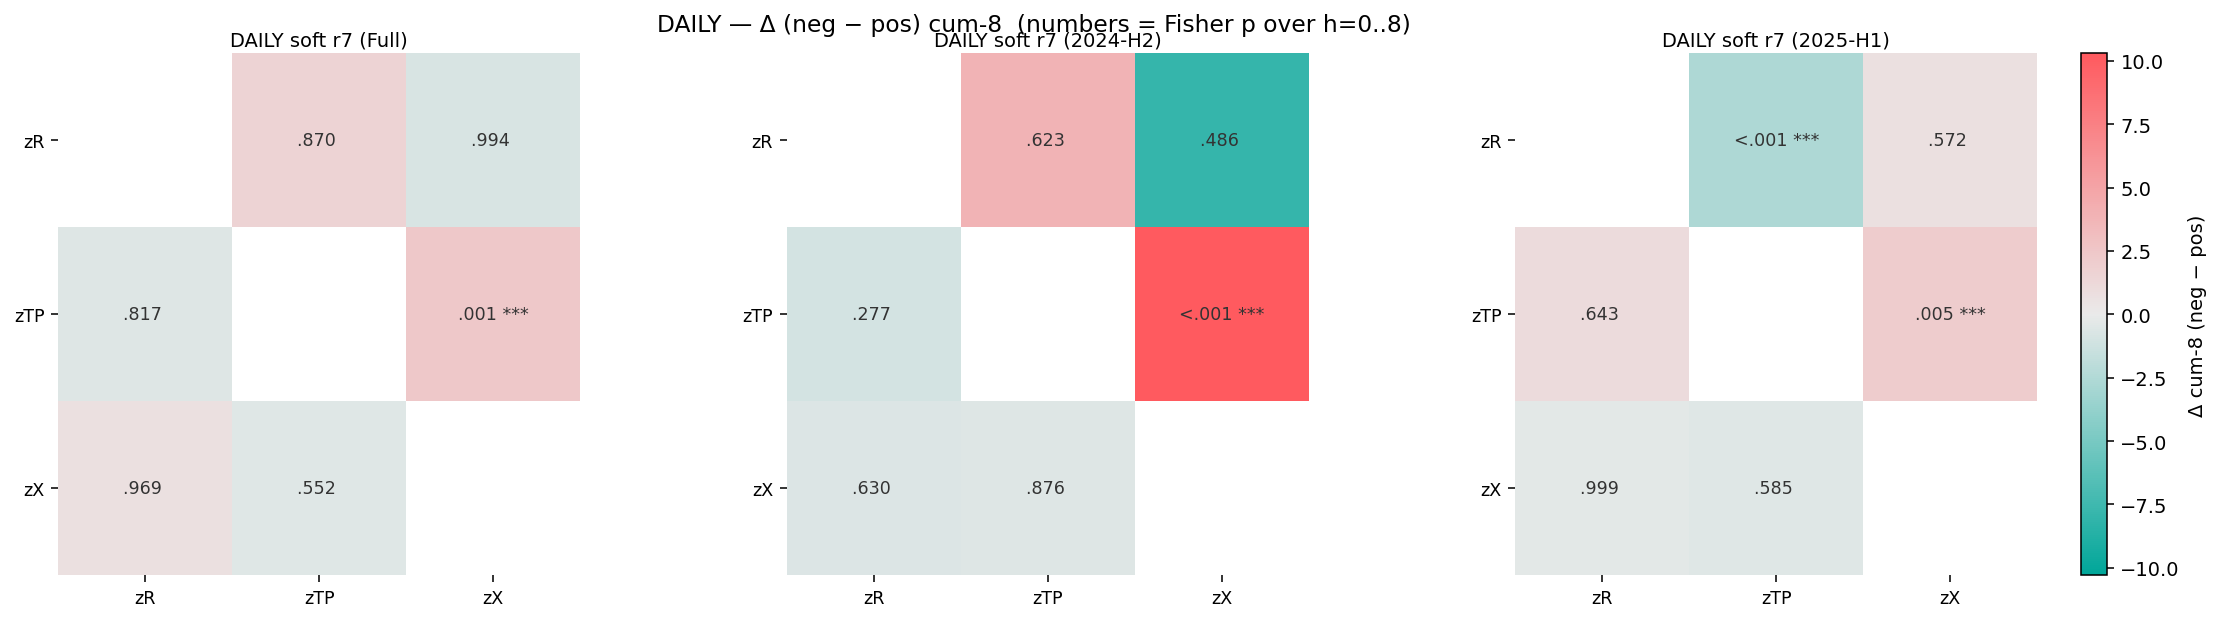

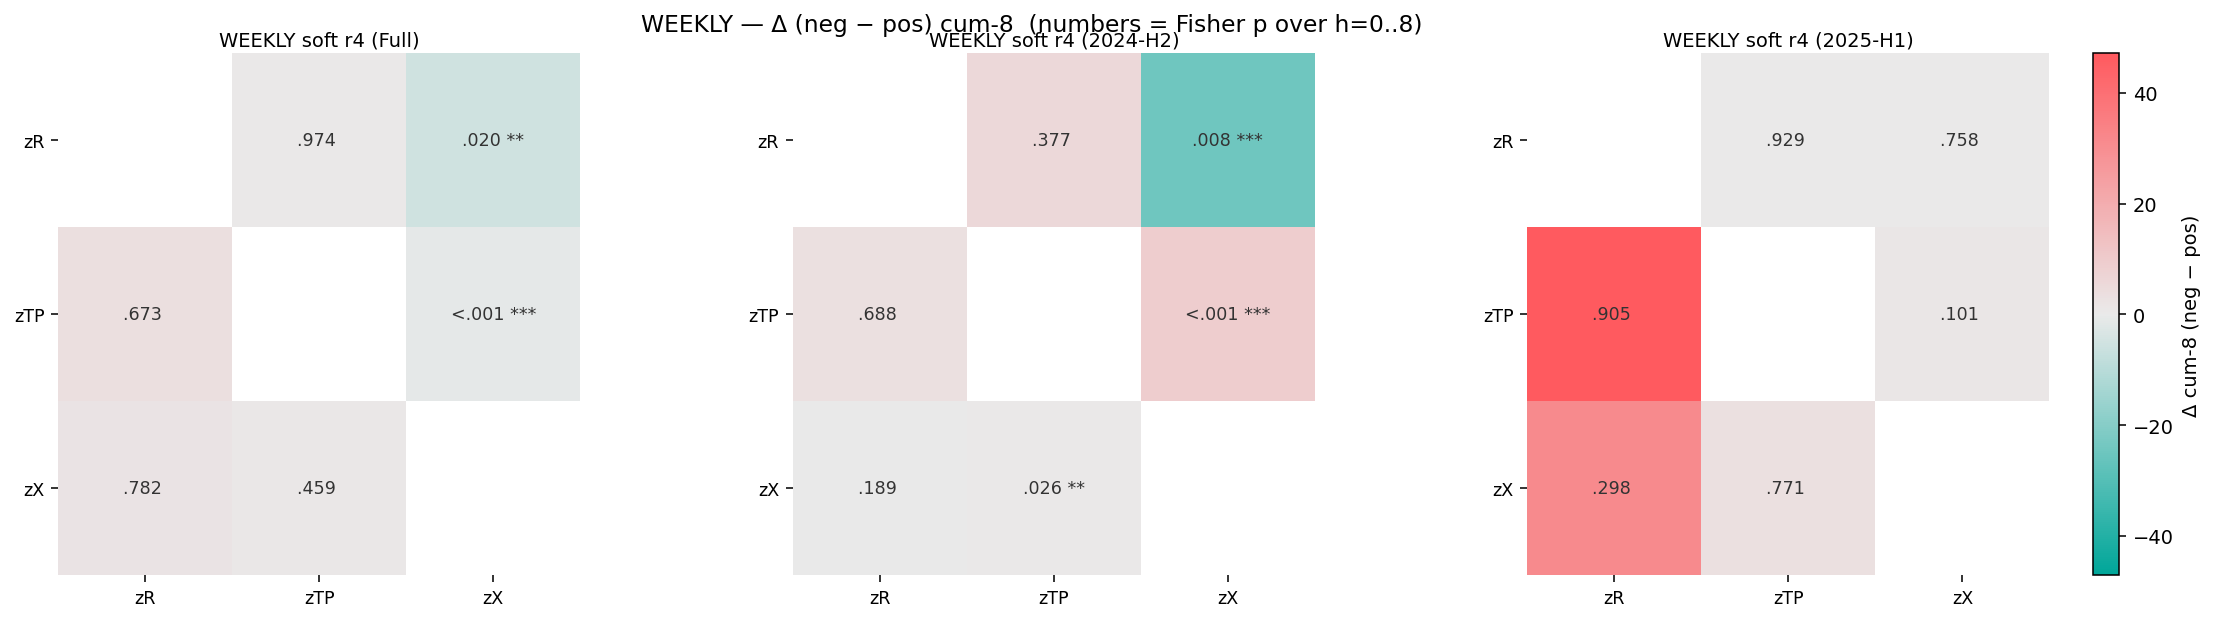

In [ ]:
# Daily panels (robust color scale, show p-values with stars)
combined_asymmetry_panels(
    [D_full, D_2024, D_2025],
    group_title="DAILY — Δ (neg − pos) cum-8  (numbers = Fisher p over h=0..8) \n",
    annotate="p+stars", clip_pct=98, title_fs=10, save_name="LP_summary_daily.png"
)

# Weekly panels (same scale rule so columns are comparable)
combined_asymmetry_panels(
    [W_full, W_2024, W_2025],
    group_title="WEEKLY — Δ (neg − pos) cum-8  (numbers = Fisher p over h=0..8)",
    annotate="p+stars", clip_pct=98, title_fs=10, save_name="LP_summary_weekly.png"
)

In [ ]:
# overwrite the function to accept vscale
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

DIV = LinearSegmentedColormap.from_list("div_airbnb", ["#00A699", "#EAEAEA", "#FF5A5F"])

def _p_stars(p: float) -> str:
    if not np.isfinite(p): return ""
    if p < 0.001: return " ***"
    if p < 0.01:  return " **"
    if p < 0.05:  return " *"
    return ""

def _fmt_p(p: float) -> str:
    if not np.isfinite(p): return ""
    return ("0.000" if p < 0.001 else f"{p:.3f}") + _p_stars(p)

def _text_color_for_bg(val, vmin, vmax, cmap=DIV) -> str:
    if not np.isfinite(val): return "#222"
    norm = Normalize(vmin=vmin, vmax=vmax)
    r, g, b, _ = cmap(norm(val))
    L = 0.2126*r + 0.7152*g + 0.0722*b
    return "#ffffff" if L < 0.55 else "#222222"

def show_or_save(fig, save_path=None, dpi=220):
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
        print(f"Saved → {save_path}")
    plt.show()

def plot_asymmetry_summary_pretty(
    run_results,
    group_title,
    title_fs=18, label_fs=12, number_fs=12,
    cbar_label="Δ cum-8 (neg − pos)",
    figsize_per_panel=(6.2, 3.6),
    vscale="max",
    show=True
):
    assert len(run_results) >= 1, "run_results must be a non-empty list"
    names = run_results[0]["names"]; k = len(names)

    all_vals = np.concatenate([np.ravel(r["delta"].values) for r in run_results])
    all_vals = all_vals[np.isfinite(all_vals)]
    if all_vals.size == 0:
        vmax = 1.0
    else:
        vmax = (float(np.nanpercentile(np.abs(all_vals), 95)) if vscale == "p95"
                else float(np.nanmax(np.abs(all_vals))))
        vmax = 1e-12 if (vmax == 0 or not np.isfinite(vmax)) else vmax

    n = len(run_results)
    w = figsize_per_panel[0] * n
    h = figsize_per_panel[1]

    fig, axes = plt.subplots(1, n, figsize=(w, h), dpi=150, squeeze=False, constrained_layout=True)
    axes = axes[0]

    last_im = None
    for ax, r in zip(axes, run_results):
        D = r["delta"].copy()
        P = r["p_fisher"].copy()
        np.fill_diagonal(D.values, np.nan)

        im = ax.imshow(D.values, cmap=DIV, vmin=-vmax, vmax=vmax)
        last_im = im

        ax.set_xticks(range(k)); ax.set_xticklabels(names, fontsize=label_fs)
        ax.set_yticks(range(k)); ax.set_yticklabels(names, fontsize=label_fs)
        ax.set_title(r["title"], fontsize=label_fs+2, fontweight=400, pad=6)
        for s in ax.spines.values(): s.set_visible(False)

        for i in range(k):
            for j in range(k):
                if i == j:
                    continue
                val = D.iat[i, j]
                p   = P.iat[i, j]
                ax.text(j, i, _fmt_p(p),
                        ha="center", va="center",
                        fontsize=number_fs,
                        color=_text_color_for_bg(val, -vmax, vmax))

    cbar = fig.colorbar(last_im, ax=axes, fraction=0.035, pad=0.04)
    cbar.set_label(cbar_label, fontsize=label_fs)
    cbar.ax.tick_params(labelsize=label_fs-1)

    fig.suptitle(group_title, fontsize=title_fs, fontweight=400, y=1.02)
    if show or save_path:
        show_or_save(fig, save_path=save_path)
    return fig


Saved → spillovers/irf_fevd/LP_summary_daily_pretty.png


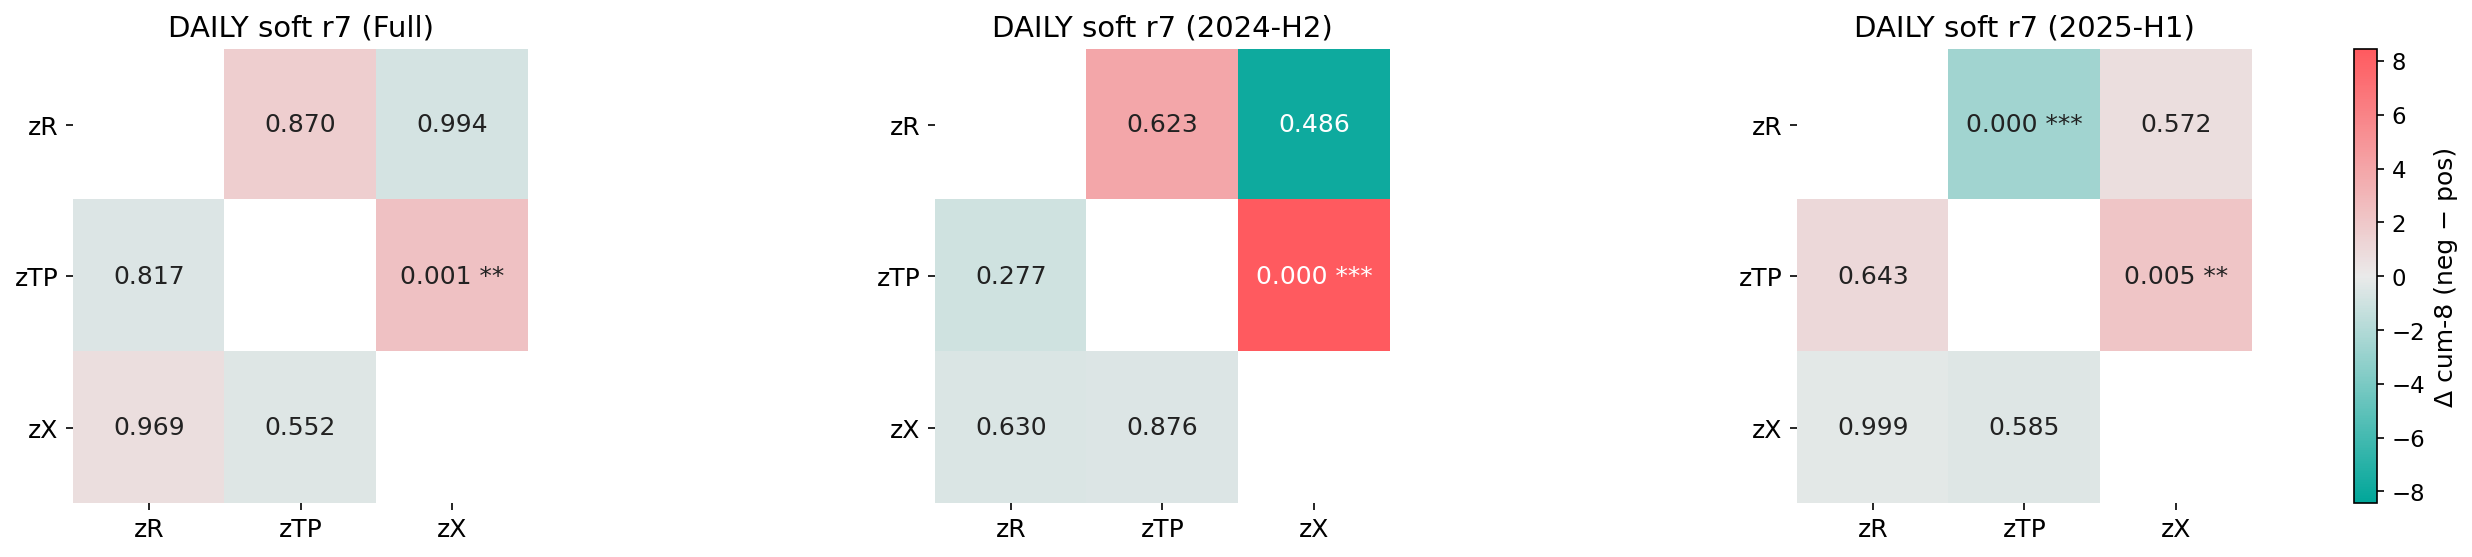

Saved → spillovers/irf_fevd/LP_summary_weekly_pretty.png


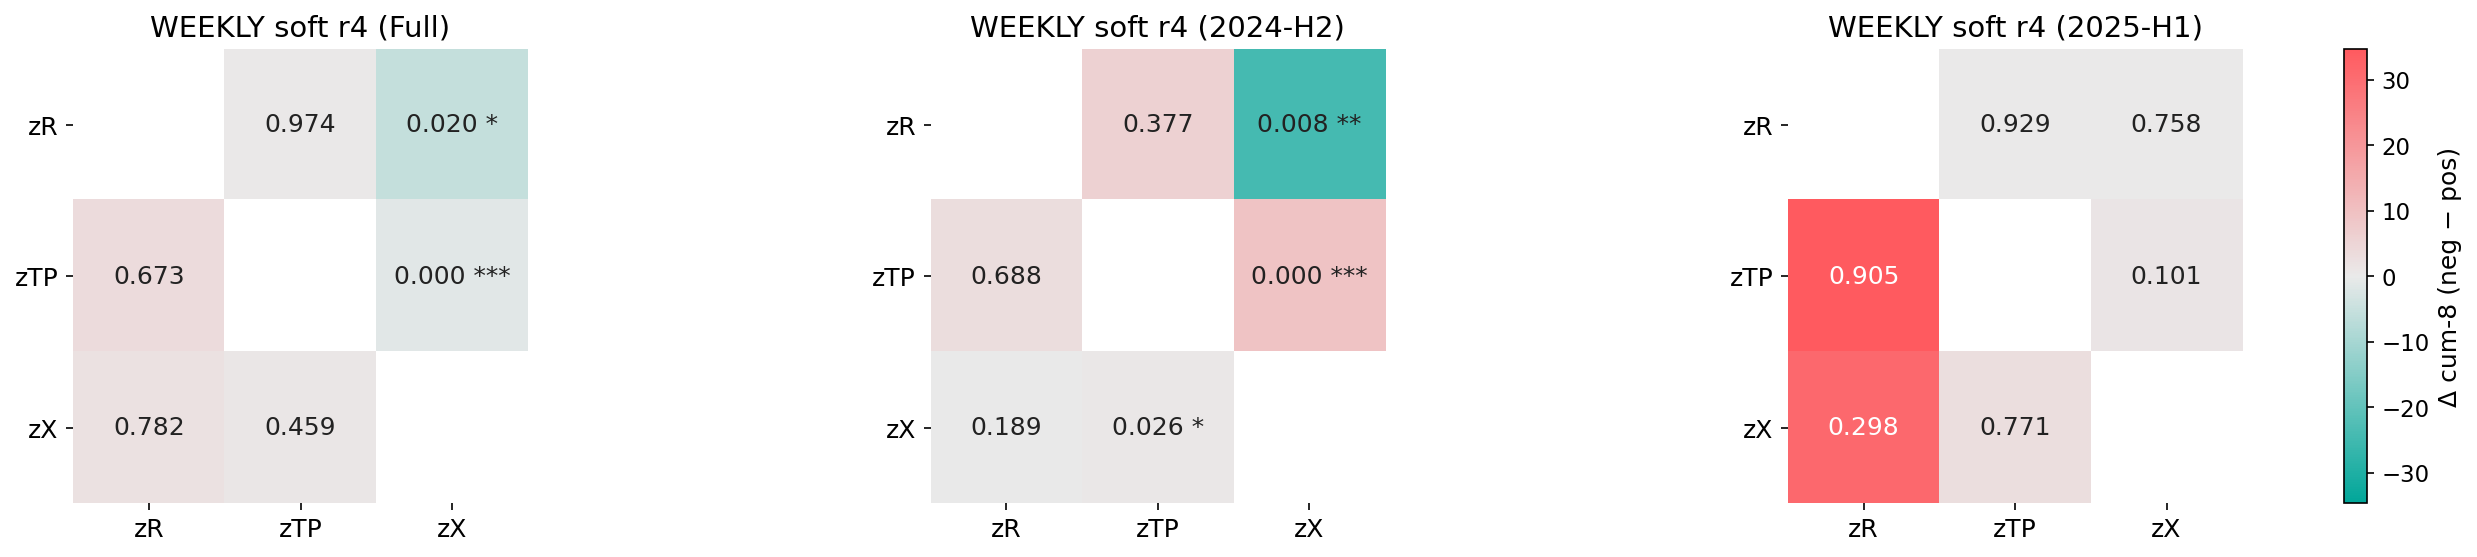

In [ ]:
# DAILY
fig_daily = plot_asymmetry_summary_pretty(
    [D_full, D_2024, D_2025],
    group_title="",
    title_fs=20, label_fs=12, number_fs=12,
    vscale="p95",
    save_path=OUTDIR / "LP_summary_daily_pretty.png",
    show=True
)

# WEEKLY
fig_weekly = plot_asymmetry_summary_pretty(
    [W_full, W_2024, W_2025],
    group_title="",
    title_fs=20, label_fs=12, number_fs=12,
    vscale="p95",
    save_path=OUTDIR / "LP_summary_weekly_pretty.png",
    show=True
)

In [ ]:
OUT_LP = Path("artifacts/event_only/spillovers/lp_asym")
OUT_LP.mkdir(parents=True, exist_ok=True)

def _save_lp_dict(run_dict, prefix):
    for key in ["pos_cum","neg_cum","delta","p_fisher"]:
        df = run_dict[key]
        df.to_csv(OUT_LP / f"{prefix}_{key}.csv")

# Weekly
_save_lp_dict(W_full,  "WEEKLY_full")
_save_lp_dict(W_2024,  "WEEKLY_2024H2")
_save_lp_dict(W_2025,  "WEEKLY_2025H1")

# Daily
_save_lp_dict(D_full,  "DAILY_full")
_save_lp_dict(D_2024,  "DAILY_2024H2")
_save_lp_dict(D_2025,  "DAILY_2025H1")

print(f"Saved LP matrices to: {OUT_LP.resolve()}")

Saved LP matrices to: /content/artifacts/event_only/spillovers/lp_asym


In [ ]:
import re

LP_DIR  = Path("artifacts/event_only/spillovers/lp_asym")
OUT_DIR = LP_DIR / "combined"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def _load_matrix_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, index_col=0)
    df.index   = [str(x) for x in df.index]
    df.columns = [str(x) for x in df.columns]
    # keep/ensure zR, zTP, zX order if present
    rows = [r for r in ["zR","zTP","zX"] if r in df.index]
    cols = [c for c in ["zR","zTP","zX"] if c in df.columns]
    return df.loc[rows, cols]

# find DAILY/WEEKLY + window + metric
files = list(LP_DIR.glob("*_delta.csv")) + list(LP_DIR.glob("*_p_fisher.csv"))
if not files:
    raise FileNotFoundError(f"No LP CSVs found in {LP_DIR.resolve()}")

records = []  # (freq, window, kind, df)
for f in files:
    m = re.match(r"^(DAILY|WEEKLY)_(.+)_(delta|p_fisher)\.csv$", f.name, re.I)
    if not m:
        continue
    freq   = m.group(1).upper()
    window = m.group(2)         # e.g., "full", "2024H2", "2025H1"
    kind   = m.group(3).lower() # "delta" or "p_fisher"
    records.append((freq, window, kind, _load_matrix_csv(f)))

# ---- save four WIDE tables
for freq in ["DAILY","WEEKLY"]:
    for kind in ["delta","p_fisher"]:
        subset = [(w, df) for (f,w,k,df) in records if f==freq and k==kind]
        if not subset:
            continue
        # order windows: Full → 2024H2 → 2025H1 (if present)
        win_order = ["full","2024H2","2025H1","2024H1","2025H2"]
        subset.sort(key=lambda t: (win_order.index(t[0]) if t[0] in win_order else 99, t[0]))

        blocks = []
        for w, df in subset:
            tmp = df.copy()
            tmp.columns = pd.MultiIndex.from_product([[w], tmp.columns], names=["window","to"])
            blocks.append(tmp)
        wide = pd.concat(blocks, axis=1)
        wide.index.name = "from"
        out_path = OUT_DIR / f"{freq}_{kind}_wide.csv"
        wide.to_csv(out_path)

# ---- save one TIDY table (both frequencies + both kinds)
tidy_parts = []
for freq, window, kind, df in records:
    t = df.reset_index().rename(columns={"index":"from"}).melt(
        id_vars="from", var_name="to", value_name="value"
    )
    t["freq"]   = freq
    t["window"] = window
    t["kind"]   = kind
    tidy_parts.append(t[["freq","window","kind","from","to","value"]])

tidy = pd.concat(tidy_parts, ignore_index=True).sort_values(["freq","window","kind","from","to"])
tidy_path = OUT_DIR / "LP_combined_tidy.csv"
tidy.to_csv(tidy_path, index=False)

print("Saved:")
print(f"  {OUT_DIR / 'DAILY_delta_wide.csv'}")
print(f"  {OUT_DIR / 'DAILY_p_fisher_wide.csv'}")
print(f"  {OUT_DIR / 'WEEKLY_delta_wide.csv'}")
print(f"  {OUT_DIR / 'WEEKLY_p_fisher_wide.csv'}")
print(f"  {tidy_path}")

Saved:
  artifacts/event_only/spillovers/lp_asym/combined/DAILY_delta_wide.csv
  artifacts/event_only/spillovers/lp_asym/combined/DAILY_p_fisher_wide.csv
  artifacts/event_only/spillovers/lp_asym/combined/WEEKLY_delta_wide.csv
  artifacts/event_only/spillovers/lp_asym/combined/WEEKLY_p_fisher_wide.csv
  artifacts/event_only/spillovers/lp_asym/combined/LP_combined_tidy.csv


In [ ]:
pd.read_csv("artifacts/event_only/spillovers/lp_asym/combined/DAILY_delta_wide.csv", header=[0,1], index_col=0)

window      full                       2024H2                         2025H1  \
to            zR      zTP        zX        zR       zTP         zX        zR   
from                                                                           
zR           NaN  1.60089 -0.741367       NaN  3.904340  -7.899733       NaN   
zTP    -0.511044      NaN  2.353458 -0.972377       NaN  11.532155  1.037093   
zX      0.681328 -0.40488       NaN -0.577625 -0.519741        NaN -0.260822   

window                      
to           zTP        zX  
from                        
zR     -2.578794  0.666027  
zTP          NaN  2.163344  
zX     -0.403828       NaN

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# ====== Paths ======
BASE = Path("artifacts/event_only/spillovers/lp_asym")
COMBINED = BASE / "combined"
COMBINED.mkdir(parents=True, exist_ok=True)

TIDY_IN = COMBINED / "LP_combined_tidy.csv"
OUT_CSV_DAILY  = COMBINED / "LP_bigtable_DAILY.csv"
OUT_CSV_WEEKLY = COMBINED / "LP_bigtable_WEEKLY.csv"
OUT_XLSX       = COMBINED / "LP_bigtable_ALL.xlsx"

# ====== Helpers ======
def pstars(p):
    if pd.isna(p): return ""
    if p < 0.001:  return "***"
    if p < 0.01:   return "**"
    if p < 0.05:   return "*"
    return ""

def norm_window_label(s):
    """Extract 'Full' / '2024-H2' / '2025-H1' from titles like 'DAILY soft r7 (Full)'."""
    s = str(s)
    if "(" in s and s.endswith(")"):
        return s.rsplit("(", 1)[1][:-1]
    return s

def make_big_table(df_tidy, freq):
    d = df_tidy[df_tidy["freq"].str.upper() == freq.upper()].copy()
    if d.empty:
        return pd.DataFrame()

    D = d[d["kind"] == "delta"][["window", "from", "to", "value"]].rename(columns={"value":"delta"})
    P = d[d["kind"] == "p_fisher"][["window", "from", "to", "value"]].rename(columns={"value":"p"})

    M = pd.merge(D, P, on=["window","from","to"], how="outer")
    M["pair"] = M["from"] + " \u2192 " + M["to"]               # pretty arrow

    def fmt_cell(row):
        d = "" if pd.isna(row["delta"]) else f"{row['delta']:.3f}"
        if pd.isna(row["p"]):
            ptxt = ""
        else:
            pv = "0.000" if row["p"] < 0.001 else f"{row['p']:.3f}"
            ptxt = pv + pstars(row["p"])
        if d and ptxt: return f"{d} | {ptxt}"
        return d or ptxt

    M["cell"] = M.apply(fmt_cell, axis=1)
    M["win_short"] = M["window"].map(norm_window_label)

    # Column order: Full, 2024-H2, 2025-H1, then any others (if present)
    wanted = ["Full", "2024-H2", "2025-H1"]
    have = list(M["win_short"].dropna().unique())
    col_order = [w for w in wanted if w in have] + sorted([w for w in have if w not in wanted])

    T = M.pivot_table(index="pair", columns="win_short", values="cell", aggfunc="first")
    T = T.reindex(columns=col_order).sort_index()
    T.index.name = ""
    return T

# ====== Load tidy OR rebuild from per-window CSVs ======
if TIDY_IN.exists():
    tidy = pd.read_csv(TIDY_IN)
else:

    def add_block(freq, win_tag, label):
        rows = []
        for kind, colname in [("delta","delta"), ("p_fisher","p_fisher")]:
            f = BASE / f"{freq}_{win_tag}_{kind}.csv"
            if not f.exists():
                continue
            df = pd.read_csv(f)
            if set(["from","to","value"]).issubset(df.columns):
                long_df = df[["from","to","value"]].copy()
            else:
                if "index" in df.columns:
                    df = df.set_index("index")
                long_df = df.reset_index().melt(id_vars=df.index.name or "index",
                                                var_name="to", value_name="value")
                long_df = long_df.rename(columns={df.index.name or "index": "from"})
            long_df["freq"]   = freq.split("_")[0].upper()
            long_df["window"] = f"{freq.split('_')[0].upper()} soft {('r4' if freq.startswith('WEEKLY') else 'r7')} ({label})"
            long_df["kind"]   = kind
            rows.append(long_df[["freq","window","kind","from","to","value"]])
        return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

    parts = []
    for freq in ["DAILY", "WEEKLY"]:
        parts.append(add_block(f"{freq}_full",   "full",   "Full"))
        parts.append(add_block(f"{freq}_2024H2", "2024H2", "2024-H2"))
        parts.append(add_block(f"{freq}_2025H1", "2025H1", "2025-H1"))

    tidy = pd.concat([p for p in parts if p is not None and not p.empty], ignore_index=True)
    tidy.to_csv(TIDY_IN, index=False)

daily_table  = make_big_table(tidy, "DAILY")
weekly_table = make_big_table(tidy, "WEEKLY")

if not daily_table.empty:  daily_table.to_csv(OUT_CSV_DAILY)
if not weekly_table.empty: weekly_table.to_csv(OUT_CSV_WEEKLY)
with pd.ExcelWriter(OUT_XLSX) as xl:
    if not daily_table.empty:  daily_table.to_excel(xl, sheet_name="DAILY")
    if not weekly_table.empty: weekly_table.to_excel(xl, sheet_name="WEEKLY")

print("Saved:")
print(" -", OUT_CSV_DAILY if daily_table is not None else "(no DAILY)")
print(" -", OUT_CSV_WEEKLY if weekly_table is not None else "(no WEEKLY)")
print(" -", OUT_XLSX)
daily_table.head(10) if not daily_table.empty else "(No DAILY data)"

Saved:
 - artifacts/event_only/spillovers/lp_asym/combined/LP_bigtable_DAILY.csv
 - artifacts/event_only/spillovers/lp_asym/combined/LP_bigtable_WEEKLY.csv
 - artifacts/event_only/spillovers/lp_asym/combined/LP_bigtable_ALL.xlsx


win_short             2024H2             2025H1             full
                                                                
zR → zR                                                         
zR → zTP       3.904 | 0.623  -2.579 | 0.000***    1.601 | 0.870
zR → zX       -7.900 | 0.486      0.666 | 0.572   -0.741 | 0.994
zTP → zR      -0.972 | 0.277      1.037 | 0.643   -0.511 | 0.817
zTP → zTP                                                       
zTP → zX   11.532 | 0.000***    2.163 | 0.005**  2.353 | 0.001**
zX → zR       -0.578 | 0.630     -0.261 | 0.999    0.681 | 0.969
zX → zTP      -0.520 | 0.876     -0.404 | 0.585   -0.405 | 0.552
zX → zX

**ADF FIX**

In [ ]:
import os, numpy as np, pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

OUT_FIG  = Path("artifacts/figures"); OUT_FIG.mkdir(parents=True, exist_ok=True)
OUT_APP  = Path("artifacts/appendix"); OUT_APP.mkdir(parents=True, exist_ok=True)

p_adf = Path("artifacts/weekly_sentiment_wide_ADF.parquet")
p_raw = Path("artifacts/weekly_sentiment_wide.parquet")

if p_adf.exists():
    Y_sta = pd.read_parquet(p_adf)
    print("Loaded stationary weekly series:", p_adf)
else:
    print("Stationary file not found; applying ADF to raw weekly table.")
    weekly_wide = pd.read_parquet(p_raw)

    def adf_transform(s, maxlag=8, alpha=0.05):
        s = pd.Series(s).astype(float).dropna()
        if len(s) < 20: return s, "as_is"
        p_c  = adfuller(s, maxlag=maxlag, regression="c",  autolag="AIC")[1]
        if p_c < alpha: return s, "as_is"
        p_ct = adfuller(s, maxlag=maxlag, regression="ct", autolag="AIC")[1]
        if p_ct < alpha:
            t = np.arange(len(s), dtype=float)
            X = np.column_stack([np.ones(len(s)), t])
            beta = np.linalg.lstsq(X, s.values, rcond=None)[0]
            resid = s.values - X.dot(beta)
            return pd.Series(resid, index=s.index), "detrended"
        return s.diff().dropna(), "diffed"

    cols = [c for c in ["X (Twitter)","Reddit","Trustpilot"] if c in weekly_wide.columns]
    sta, steps = {}, {}
    for c in cols:
        sta[c], steps[c] = adf_transform(weekly_wide[c])
    Y_sta = pd.DataFrame(sta).dropna()
    pd.Series(steps, name="ADF_transform").to_csv(OUT_APP/"adf_transform_platforms_from_spillover.csv")
    print("ADF decisions saved:", OUT_APP/"adf_transform_platforms_from_spillover.csv")

# Ensure column order used for identification later
cols = [c for c in ["X (Twitter)","Reddit","Trustpilot"] if c in Y_sta.columns]
Y_sta = Y_sta[cols]
display(Y_sta.tail())
display(Y_sta.head())

Stationary file not found; applying ADF to raw weekly table.
ADF decisions saved: artifacts/appendix/adf_transform_platforms_from_spillover.csv


X (Twitter)    Reddit  Trustpilot
week_start                                   
2025-05-26     0.009956 -0.307499   -0.500198
2025-06-02    -0.125626 -0.121966   -0.442622
2025-06-09    -0.025751 -0.163824   -0.602722
2025-06-16    -0.051014 -0.144200   -0.437405
2025-06-23     0.095906 -0.138996   -0.513360

X (Twitter)    Reddit  Trustpilot
week_start                                   
2024-07-01     0.010276 -0.183719   -0.438714
2024-07-08    -0.037925 -0.332633   -0.564501
2024-07-15    -0.035408 -0.317691   -0.456049
2024-07-22    -0.011103 -0.432790   -0.486620
2024-07-29    -0.036696 -0.308537   -0.481295

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

from           to      pval  lag  n_obs
0  X (Twitter)       Reddit  0.689475    8     52
1  X (Twitter)   Trustpilot  0.748244    8     52
2       Reddit  X (Twitter)  0.742839    8     52
3       Reddit   Trustpilot  0.807568    8     52
4   Trustpilot  X (Twitter)  0.298943    8     52
5   Trustpilot       Reddit  0.535990    8     52

to             Reddit  Trustpilot  X (Twitter)
from                                          
Reddit            NaN    0.807568     0.742839
Trustpilot   0.535990         NaN     0.298943
X (Twitter)  0.689475    0.748244          NaN

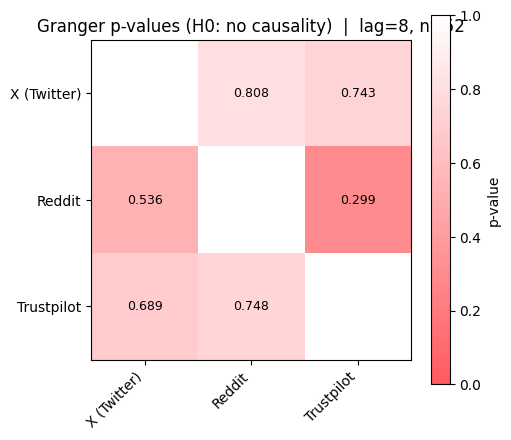

Saved: artifacts/appendix/granger_pairwise_fixedp.csv | artifacts/figures/granger_heatmap_airbnb_fixedp.png


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

SERIES = [c for c in ["X (Twitter)", "Reddit", "Trustpilot"] if c in Y_sta.columns]
Z = Y_sta[SERIES].dropna().copy()


def granger_fixed_lag(df, cause, effect, p=P):
    sub = df[[effect, cause]]
    res = grangercausalitytests(sub, maxlag=p, verbose=False)
    return res[p][0]['ssr_ftest'][1]

rows = []
for cause in SERIES:
    for effect in SERIES:
        if cause == effect:
            continue
        pval = granger_fixed_lag(Z, cause, effect, p=P)
        rows.append({"from": cause, "to": effect, "pval": pval, "lag": P, "n_obs": len(Z)})

gr_df = pd.DataFrame(rows)
gr_pivot = gr_df.pivot(index="from", columns="to", values="pval")
display(gr_df)
display(gr_pivot)

# Airbnb red heatmap
airbnb_red = "#FF5A5F"
cmap_airbnb = LinearSegmentedColormap.from_list("airbnb_red_r", [airbnb_red, "#FFFFFF"], N=256)

fig, ax = plt.subplots(figsize=(5.2, 4.6))
im = ax.imshow(gr_pivot.values, cmap=cmap_airbnb, vmin=0, vmax=1)
ax.set_xticks(range(len(SERIES))); ax.set_yticks(range(len(SERIES)))
ax.set_xticklabels(SERIES, rotation=45, ha="right"); ax.set_yticklabels(SERIES)

for i in range(len(SERIES)):
    for j in range(len(SERIES)):
        if i == j:
            continue
        val = gr_pivot.values[i, j]
        txt = f"{val:.3f}"
        ax.text(j, i, txt, ha="center", va="center",
                color=("white" if val <= 0.25 else "black"), fontsize=9)

ax.set_title(f"Granger p-values (H0: no causality)  |  lag={P}, n={len(Z)}")
cbar = fig.colorbar(im, ax=ax); cbar.set_label("p-value")
plt.tight_layout()
plt.savefig(OUT_FIG/"granger_heatmap_airbnb_fixedp.png", dpi=200)
plt.show()

gr_df.to_csv(OUT_APP/"granger_pairwise_fixedp.csv", index=False)
print("Saved:", OUT_APP/"granger_pairwise_fixedp.csv", "|", OUT_FIG/"granger_heatmap_airbnb_fixedp.png")

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib.colors import LinearSegmentedColormap

weekly_wide = pd.read_parquet("artifacts/weekly_sentiment_wide.parquet")
SERIES = [c for c in ["X (Twitter)","Reddit","Trustpilot"] if c in weekly_wide.columns]

r4 = weekly_wide[SERIES].rolling(4, min_periods=1).mean()

# lock common sample and fixed lag p=8
Z = r4.dropna().copy()
P = 8

def granger_fixed(df, cause, effect, p=P):
    out = grangercausalitytests(df[[effect, cause]], maxlag=p, verbose=False)
    return out[p][0]["ssr_ftest"][1]

rows = []
for cause in SERIES:
    for effect in SERIES:
        if cause == effect:
            continue
        rows.append({"from": cause, "to": effect, "pval": granger_fixed(Z, cause, effect), "lag": P, "n": len(Z)})
old_gr = pd.DataFrame(rows)
display(old_gr)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

from           to      pval  lag   n
0  X (Twitter)       Reddit  0.692664    8  53
1  X (Twitter)   Trustpilot  0.161116    8  53
2       Reddit  X (Twitter)  0.246708    8  53
3       Reddit   Trustpilot  0.198435    8  53
4   Trustpilot  X (Twitter)  0.552477    8  53
5   Trustpilot       Reddit  0.564281    8  53

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

BASE = Path("artifacts")
P_WIDE = BASE / "weekly_sentiment_wide.parquet"
P_ADF  = BASE / "weekly_sentiment_wide_ADF.parquet"

def adf_transform(s: pd.Series, maxlag=8, alpha=0.05):
    """as_is if ADF(c) < alpha; detrend if ADF(ct) < alpha; else first diff."""
    s = pd.Series(s).astype(float).dropna()
    if len(s) < 20:
        return s, "as_is"
    p_c  = adfuller(s, maxlag=maxlag, regression="c",  autolag="AIC")[1]
    if p_c < alpha:
        return s, "as_is"
    p_ct = adfuller(s, maxlag=maxlag, regression="ct", autolag="AIC")[1]
    if p_ct < alpha:
        t = np.arange(len(s), dtype=float)
        X = np.column_stack([np.ones(len(s)), t])
        beta = np.linalg.lstsq(X, s.values, rcond=None)[0]
        resid = s.values - X.dot(beta)
        return pd.Series(resid, index=s.index), "detrended"
    return s.diff().dropna(), "diffed"

if P_ADF.exists():
    Y_sta = pd.read_parquet(P_ADF)
    print("Loaded stationary weekly series:", P_ADF)
else:
    print("Stationary file not found — creating it from", P_WIDE)
    weekly_wide = pd.read_parquet(P_WIDE)

    SERIES = [c for c in ["X (Twitter)", "Reddit", "Trustpilot"] if c in weekly_wide.columns]
    weekly_wide = weekly_wide[SERIES]
    weekly_wide = weekly_wide.dropna()  # enforce common sample

    sta, steps = {}, {}
    for c in SERIES:
        sta[c], steps[c] = adf_transform(weekly_wide[c], maxlag=8, alpha=0.05)

    Y_sta = pd.DataFrame(sta).dropna()  # common index after transforms
    Y_sta.to_parquet(P_ADF)
    pd.Series(steps, name="ADF_transform").to_csv(BASE / "adf_transform_platforms.csv")
    print("Saved:", P_ADF, "and", BASE / "adf_transform_platforms.csv")

# Keep a consistent column order for later steps
SERIES = [c for c in ["X (Twitter)", "Reddit", "Trustpilot"] if c in Y_sta.columns]
Y_sta = Y_sta[SERIES]
display(Y_sta.tail())
print("n_obs:", len(Y_sta), "| columns:", Y_sta.columns.tolist())

Stationary file not found — creating it from artifacts/weekly_sentiment_wide.parquet
Saved: artifacts/weekly_sentiment_wide_ADF.parquet and artifacts/adf_transform_platforms.csv


X (Twitter)    Reddit  Trustpilot
week_start                                   
2025-05-26     0.009956 -0.307499   -0.500198
2025-06-02    -0.125626 -0.121966   -0.442622
2025-06-09    -0.025751 -0.163824   -0.602722
2025-06-16    -0.051014 -0.144200   -0.437405
2025-06-23     0.095906 -0.138996   -0.513360

n_obs: 52 | columns: ['X (Twitter)', 'Reddit', 'Trustpilot']


In [ ]:
# ADF stationary series you created earlier
Y_sta = pd.read_parquet("artifacts/weekly_sentiment_wide_ADF.parquet")
SERIES = [c for c in ["X (Twitter)","Reddit","Trustpilot"] if c in Y_sta.columns]
Z = Y_sta[SERIES].dropna()

def granger_at_p(df, cause, effect, p):
    out = grangercausalitytests(df[[effect, cause]], maxlag=p, verbose=False)
    return out[p][0]['ssr_ftest'][1]

grid = []
for p in range(1, 9):
    for cause in SERIES:
        for effect in SERIES:
            if cause == effect:
                continue
            try:
                pv = granger_at_p(Z, cause, effect, p)
            except Exception:
                pv = np.nan
            grid.append({"lag": p, "from": cause, "to": effect, "pval": pv, "n": len(Z)})
gr_grid = pd.DataFrame(grid)
display(gr_grid.pivot(index="from", columns=["to","lag"], values="pval").round(3))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

to          Reddit Trustpilot X (Twitter) Reddit Trustpilot X (Twitter)  \
lag              1          1           1      2          2           2   
from                                                                      
Reddit         NaN      0.706       0.389    NaN      0.221       0.667   
Trustpilot   0.994        NaN       0.242  0.985        NaN       0.406   
X (Twitter)  0.808      0.075         NaN  0.832      0.146         NaN   

to          Reddit Trustpilot X (Twitter) Reddit  ... X (Twitter) Reddit  \
lag              3          3           3      4  ...           5      6   
from                                              ...                      
Reddit         NaN      0.314       0.602    NaN  ...       0.747    NaN   
Trustpilot   0.850        NaN       0.763  0.953  ...       0.387  0.984   
X (Twitter)  0.867      0.133         NaN  0.909  ...         NaN  0.964   

to          Trustpilot X (Twitter) Reddit Trustpilot X (Twitter) Reddit  \
lag                  6           6      7          7           7      8   
from                                                                      
Reddit           0.658       0.707    NaN      0.763       0.896    NaN   
Trustpilot         NaN       0.287  0.828        NaN       0.334  0.536   
X (Twitter)      0.555         NaN  0.774      0.673         NaN  0.689   

to          Trustpilot X (Twitter)  
lag                  8           8  
from                                
Reddit           0.808       0.743  
Trustpilot         NaN       0.299  
X (Twitter)      0.748         NaN  

[3 rows x 24 columns]

In [ ]:
from statsmodels.tsa.api import VAR

SERIES = [c for c in ["X (Twitter)","Reddit","Trustpilot"] if c in Y_sta.columns]
Z = Y_sta[SERIES].dropna()

# choose p by AIC (or set p=8 to mirror the old figure)
best, best_aic, best_p = None, np.inf, None
for p in range(2, 9):
    try:
        res = VAR(Z).fit(p)
        if res.aic < best_aic:
            best, best_aic, best_p = res, res.aic, p
    except Exception:
        pass

print(f"Selected VAR lag p={best_p}, AIC={best_aic:.3f}")

def cause_test(res, caused, causing):
    tst = res.test_causality(caused=caused, causing=causing, kind='f')
    return {"to": caused, "from": causing, "pval": tst.pvalue, "df": tst.df, "lag": res.k_ar, "n": res.nobs}

rows = []
rows.append(cause_test(best, "Trustpilot", ["Reddit"]))
rows.append(cause_test(best, "Trustpilot", ["X (Twitter)"]))
rows.append(cause_test(best, "Reddit", ["X (Twitter)"]))
rows.append(cause_test(best, "X (Twitter)", ["Reddit"]))
var_caus = pd.DataFrame(rows)
display(var_caus)
var_caus.to_csv("artifacts/appendix/var_block_exogeneity.csv", index=False)

Selected VAR lag p=2, AIC=-13.850


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  

to           from      pval        df  lag   n
0   Trustpilot       [Reddit]  0.052584  (2, 129)    2  50
1   Trustpilot  [X (Twitter)]  0.034123  (2, 129)    2  50
2       Reddit  [X (Twitter)]  0.814454  (2, 129)    2  50
3  X (Twitter)       [Reddit]  0.615885  (2, 129)    2  50

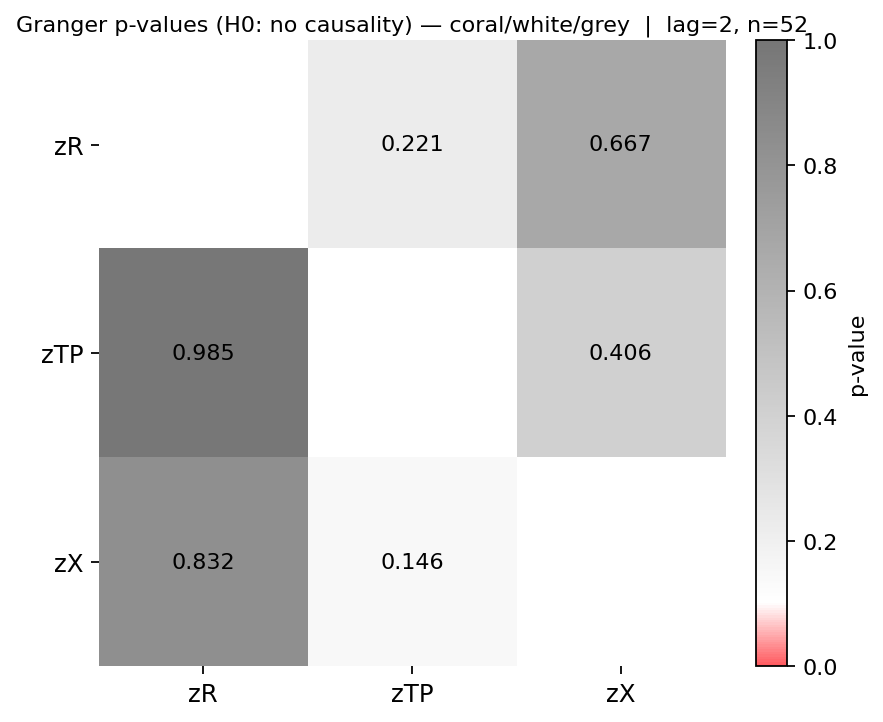

Saved: artifacts/figures/granger_heatmap_coralwhitegrey_p2.png


In [ ]:
OUT_FIG = Path("artifacts/figures"); OUT_FIG.mkdir(parents=True, exist_ok=True)

ORDER_PLAT = ["Reddit", "Trustpilot", "X (Twitter)"]
ORDER_Z    = ["zR", "zTP", "zX"]
NAME_TO_Z  = {"Reddit": "zR", "Trustpilot": "zTP", "X (Twitter)": "zX"}

CORAL_WHITE_GREY = LinearSegmentedColormap.from_list(
    "coral_white_grey",
    [(0.00, "#FF5A5F"),
     (0.10, "#FFFFFF"),
     (1.00, "#767676")]
)

def heatmap_granger_coralwhitegrey_pairwise(gr_df, title, save_path=None,
                                            figsize=(5.8, 4.4), title_size=10):
    df = gr_df.copy()
    df["from"] = df["from"].map(NAME_TO_Z)
    df["to"]   = df["to"].map(NAME_TO_Z)
    mat = (df.pivot(index="from", columns="to", values="pval")
             .reindex(index=ORDER_Z, columns=ORDER_Z))

    fig, ax = plt.subplots(figsize=figsize, dpi=160, constrained_layout=True)
    im = ax.imshow(mat.values, cmap=CORAL_WHITE_GREY, vmin=0, vmax=1)

    ax.set_xticks(range(mat.shape[1])); ax.set_xticklabels(ORDER_Z, fontsize=11)
    ax.set_yticks(range(mat.shape[0])); ax.set_yticklabels(ORDER_Z, fontsize=11)
    ax.set_title(title, fontsize=title_size, fontweight=400, pad=4)

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            v = mat.iat[i, j]
            if pd.notna(v):
                ax.text(j, i, f"{v:.3f}",
                        ha="center", va="center",
                        color=("#FFFFFF" if v < 0.05 else "#000000"),
                        fontweight=("bold" if v < 0.05 else "normal"),
                        fontsize=10)

    cbar = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.04)
    cbar.set_label("p-value")
    ax.set_aspect("equal")
    for spine in ax.spines.values():
        spine.set_visible(False)

    if save_path:
        fig.savefig(save_path, dpi=220, bbox_inches="tight")
    plt.show()
    return fig, ax

title = f"Granger p-values (H0: no causality) — coral/white/grey  |  lag={P}, n={N}"
png_path = OUT_FIG / f"granger_heatmap_coralwhitegrey_p{P}.png"
heatmap_granger_coralwhitegrey_pairwise(gr_p2, title, save_path=png_path)
print("Saved:", png_path)

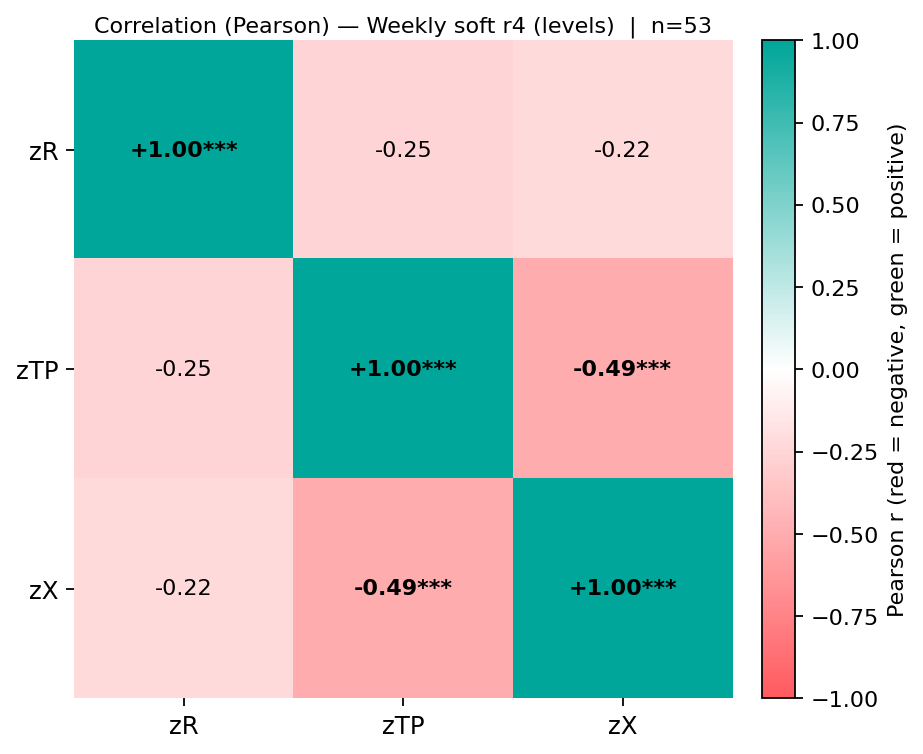

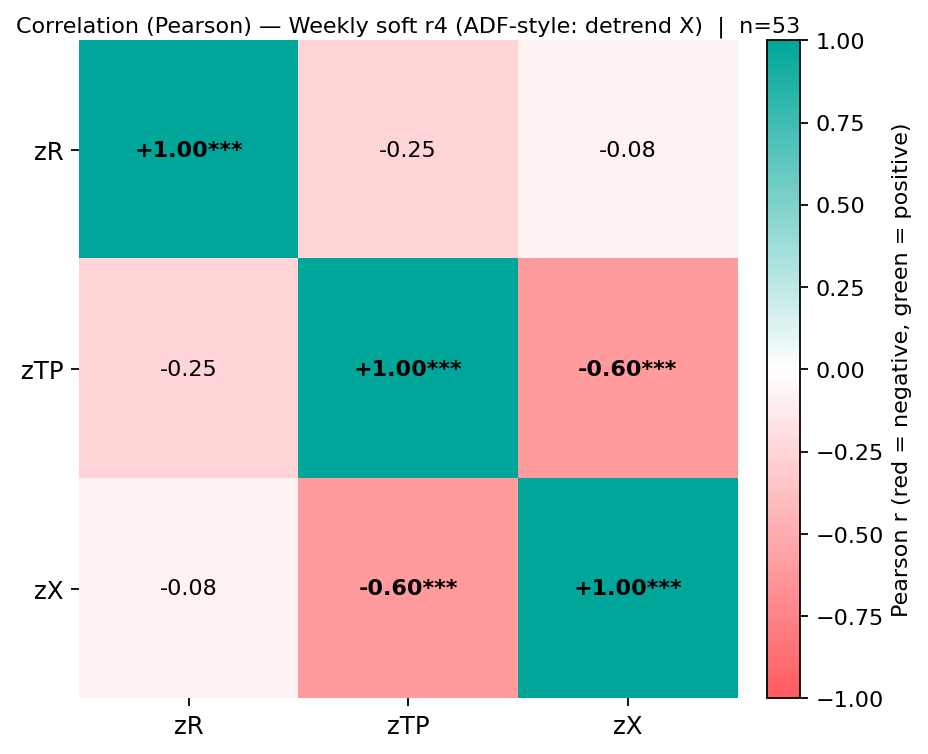

In [ ]:
from scipy.stats import pearsonr, spearmanr
from statsmodels.api import OLS, add_constant

BASE = Path("artifacts/event_only")
IN_SP = BASE / "spillovers"
OUT_APP = BASE / "appendix"; OUT_APP.mkdir(parents=True, exist_ok=True)

CSV_WEEKLY_R4 = IN_SP / "sentiment_weekly_soft_r4.csv"   # main pipeline file
assert CSV_WEEKLY_R4.exists(), f"Missing {CSV_WEEKLY_R4}"

ORDER = ["Reddit", "Trustpilot", "X (Twitter)"]
NAMES = ["zR","zTP","zX"]
NAME_TO_Z = dict(zip(ORDER, NAMES))

def prep_weekly_wide(csv_path: Path, start="2024-07-01", end="2025-06-30"):
    df = pd.read_csv(csv_path, parse_dates=["week_start"])
    # pick the r4 column that exists
    cand_cols = ["sent_z_soft_r4","sentiment_soft_r4","sent_soft_r4"]
    val_col = next((c for c in cand_cols if c in df.columns), None)
    if val_col is None:
        raise KeyError(f"Could not find any of {cand_cols} in {csv_path.name}")
    d = df[(df["week_start"]>=pd.to_datetime(start)) & (df["week_start"]<=pd.to_datetime(end))].copy()

    wide = d.pivot(index="week_start", columns="source", values=val_col).sort_index()
    cols = [c for c in ORDER if c in wide.columns]
    Y = wide[cols].dropna().copy()
    Y.columns = [NAME_TO_Z[c] for c in cols]  # zR, zTP, zX
    return Y

def detrend(series: pd.Series) -> pd.Series:
    t = np.arange(len(series), dtype=float)
    X = add_constant(t)
    resid = OLS(series.values, X, missing="drop").fit().resid
    return pd.Series(resid, index=series.index, name=series.name)

def corr_with_p(df: pd.DataFrame, method="pearson"):
    names = df.columns.tolist()
    R = pd.DataFrame(np.eye(len(names)), index=names, columns=names, dtype=float)
    P = pd.DataFrame(np.zeros((len(names),len(names))), index=names, columns=names, dtype=float)
    for i, a in enumerate(names):
        for j, b in enumerate(names):
            if j < i:  # fill symmetric
                R.iat[i,j] = R.iat[j,i]
                P.iat[i,j] = P.iat[j,i]
                continue
            x, y = df[a].values, df[b].values
            if method=="pearson":
                r, p = pearsonr(x, y)
            else:
                r, p = spearmanr(x, y)
            R.iat[i,j] = R.iat[j,i] = r
            P.iat[i,j] = P.iat[j,i] = p
    return R, P

RED_WHITE_GREEN = LinearSegmentedColormap.from_list(
    "red_white_green",
    [
        (0.0, "#FF5A5F"),  # red for negative correlations
        (0.5, "#FFFFFF"),  # white at zero
        (1.0, "#00A699"),  # green for positive correlations
    ],
    N=256,
)

def plot_corr_heatmap(R: pd.DataFrame, P: pd.DataFrame, title: str, save_png: Path):
    fig, ax = plt.subplots(figsize=(5.8, 4.6), dpi=160, constrained_layout=True)
    im = ax.imshow(R.values, vmin=-1, vmax=1, cmap=RED_WHITE_GREEN)
    ax.set_xticks(range(len(R.columns))); ax.set_xticklabels(R.columns, fontsize=11)
    ax.set_yticks(range(len(R.index)));   ax.set_yticklabels(R.index, fontsize=11)
    ax.set_title(title, fontsize=10, fontweight=400, pad=4)

    # annotate r with stars for p<.05
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            r = R.iat[i,j]; p = P.iat[i,j]
            stars = "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else ""))
            ax.text(j, i, f"{r:+.2f}{stars}", ha="center", va="center",
                    color="#000000", fontweight=("bold" if p<0.05 else "normal"), fontsize=10)

    cbar = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.04)
    cbar.set_label("Pearson r (red = negative, green = positive)")
    ax.set_aspect("equal")
    for s in ax.spines.values(): s.set_visible(False)
    fig.savefig(save_png, dpi=220, bbox_inches="tight")
    plt.show()

# --------- 1) Weekly r4 (levels) ---------
Y = prep_weekly_wide(CSV_WEEKLY_R4)
R_lev, P_lev = corr_with_p(Y, method="pearson")
R_lev.to_csv(OUT_APP / "corr_weekly_r4_levels_pearson.csv")
P_lev.to_csv(OUT_APP / "corr_weekly_r4_levels_pearson_pvals.csv")
plot_corr_heatmap(R_lev, P_lev,
                  title=f"Correlation (Pearson) — Weekly soft r4 (levels)  |  n={len(Y)}",
                  save_png=OUT_APP / "corr_heatmap_weekly_r4_levels.png")

Y_sta = Y.copy()
if "zX" in Y_sta.columns:
    Y_sta["zX"] = detrend(Y_sta["zX"])
R_sta, P_sta = corr_with_p(Y_sta, method="pearson")
R_sta.to_csv(OUT_APP / "corr_weekly_r4_ADFstyle_pearson.csv")
P_sta.to_csv(OUT_APP / "corr_weekly_r4_ADFstyle_pearson_pvals.csv")
plot_corr_heatmap(R_sta, P_sta,
                  title=f"Correlation (Pearson) — Weekly soft r4 (ADF-style: detrend X)  |  n={len(Y_sta)}",
                  save_png=OUT_APP / "corr_heatmap_weekly_r4_ADFstyle.png")

DO_SPEARMAN = False
if DO_SPEARMAN:
    R_s, P_s = corr_with_p(Y, method="spearman")
    R_s.to_csv(OUT_APP / "corr_weekly_r4_levels_spearman.csv")
    P_s.to_csv(OUT_APP / "corr_weekly_r4_levels_spearman_pvals.csv")